<a href="https://www.kaggle.com/code/sebastianusradhya/titanic-competition-w-ml?scriptVersionId=191782391" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h2 id="heading" style="font-family:verdana; font-weight:bold"> <center>Titanic - Machine Learning from Disaster</center> </h2>
<center><b>Competition Citation</center>
<center>Will Cukierski. (2012). Titanic - Machine Learning from Disaster. Kaggle. https://kaggle.com/competitions/titanic</center><br>
<center><img src = "https://img.freepik.com/free-vector/shipwreck-accident-ship-run-aground-sink-ocean_33099-2210.jpg?w=1380&t=st=1719139088~exp=1719139688~hmac=b69ee9936d3c71b6c33ebad159cdc383c3dc9ce3fd0a1ea33ff304a7c78e46f6" width="900"/></center>
<center>Image by vectorpouch on Freepik</center>

## Data Dictionary
**survival:**: Survival, 0 = No, 1 = Yes <br>
**pclass:** Ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd <br>
**sex:** Sex, male or female<br>
**age:** Age in years<br>
**sibsp:** num siblings / spouses aboard the Titanic<br>
**parch:** num parents / children aboard the Titanic<br>
**ticket:** Ticket number<br>
**fare:** Passenger fare<br>
**cabin:** Cabin number<br>
**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton<br>

In [1]:
!pip install MissForest
!pip install tabpfn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.6/156.6 kB 1.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, StratifiedKFold
import optuna
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, DMatrix
import lightgbm as lgb
import catboost as cb
from sklearn import tree, naive_bayes, ensemble
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from sklearn import metrics
from missforest.missforest import MissForest
from sklearn.inspection import permutation_importance

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df_train_raw = df_train.copy()
df_test_raw = df_test.copy()

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Survival Count Distribution
Did Not Survive:  549
Survived:  342


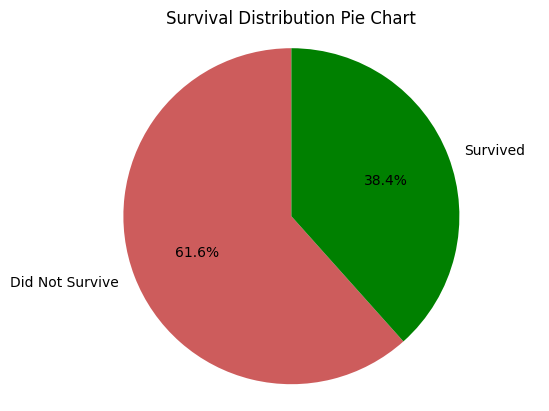

In [8]:
print("Survival Count Distribution")
print("Did Not Survive: ",df_train['Survived'].value_counts()[0])
print("Survived: ",df_train['Survived'].value_counts()[1])

labels= ['Did Not Survive', 'Survived']
colors=['indianred', 'green']
survival = [df_train['Survived'].value_counts()[0],df_train['Survived'].value_counts()[1]]
plt.pie(survival,labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Survival Distribution Pie Chart')
plt.show()

From the target class 'Survival' distribution, we can see that the data is mildly imbalance (Proportion of Minority Class = ~38.4%). I chose to implement SMOTE to handle this, which will be included inside a pipeline.

## Handling Missing Values Part 1
Features with Missing Values in Order of Count Missing Values:<br>
**Cabin, Age, Embarked**

In addition, in the test set, Age and Fare are also missing.

In [9]:
percent_missing = df_train.isnull().sum() * 100 / len(df_train)
print(percent_missing)

print('-' * 50)

missing_value = pd.DataFrame({
    'col_name': df_train.columns,
    'percent_missing': percent_missing
})

print(missing_value[percent_missing>0])

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64
--------------------------------------------------
          col_name  percent_missing
Age            Age        19.865320
Cabin        Cabin        77.104377
Embarked  Embarked         0.224467


Due to the high number of missing values in cabin (77% of the whole training dataset) I decided to drop this feature.

In [10]:
df_train = df_train.drop(['Cabin'], axis=1)
df_test = df_test.drop(['Cabin'], axis=1)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [12]:
df_train[df_train['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,Q
...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,S


## Encoding

In [13]:
df_train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [14]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

For embarked, I decided to label encode this first before handling the missing values, where later I will one-hot encode this feature.

In [15]:
sex_mapping = {'male': 0, 'female': 1}
embarked_mapping = {'C': 0, 'Q': 1, 'S': 2}
df_train['Sex'] = df_train['Sex'].map(sex_mapping)
df_train['Embarked'] = df_train['Embarked'].map(embarked_mapping)
df_test['Sex'] = df_test['Sex'].map(sex_mapping)
df_test['Embarked'] = df_test['Embarked'].map(embarked_mapping)

In [16]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,2.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,0.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,2.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,2.0
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,2.0
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,2.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.4500,2.0
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,0.0


In [17]:
df_train['Embarked'].unique()

array([ 2.,  0.,  1., nan])

## EDAs & Feature Engineering

Next, from the names there are titles of the person. Therefore, I would like to extract the titles for each person and investigate further.

### Title

In [18]:
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )+1
        end = s.index( last, start )+1
        return s[start:end]
    except ValueError:
        return ""

In [19]:
title_arr = []
for i in pd.concat([df_train['Name'],df_test['Name']]):
    title = find_between(i,',','.')
    title_arr.append(title)

In [20]:
title_unique = (list(set(title_arr)))
print(title_unique)

['Dr.', 'Don.', 'Lady.', 'Jonkheer.', 'Mme.', 'Ms.', 'Mlle.', 'Mrs.', 'Rev.', 'Mr.', 'Capt.', 'the Countess.', 'Master.', 'Major.', 'Sir.', 'Dona.', 'Col.', 'Miss.']


In [21]:
title_counts = {title: 0 for title in title_unique}
title_counts['No Title'] = 0

for name in pd.concat([df_train['Name'],df_test['Name']]):
    title_found = False
    for title in title_unique:
        if title in name:
            title_counts[title] += 1
            title_found = True
            break
    if not title_found:
        title_counts['No Title'] += 1

In [22]:
print(sorted(title_counts.items(), key=lambda kv: kv[1]))

[('No Title', 0), ('Don.', 1), ('Lady.', 1), ('Jonkheer.', 1), ('Mme.', 1), ('Capt.', 1), ('the Countess.', 1), ('Sir.', 1), ('Dona.', 1), ('Ms.', 2), ('Mlle.', 2), ('Major.', 2), ('Col.', 4), ('Dr.', 8), ('Rev.', 8), ('Master.', 61), ('Mrs.', 197), ('Miss.', 260), ('Mr.', 757)]


Here we can see that there are many different titles, with the most common ones being "Mr.", "Mrs.", and "Miss.". Since this is a non-ordinal categorical feature, I would like to implement One-Hot Encoding. To reduce the dimensionality, I choose to keep the three most common values and group the other values as "Other".

In [23]:
#make sure total rows are the same
print(sum(title_counts.values()))
print(len(pd.concat([df_train['Name'],df_test['Name']])))

1309
1309


In [24]:
df_train['Title'] = df_train['Name'].apply(lambda x: find_between(x,',','.'))
df_test['Title'] = df_test['Name'].apply(lambda x: find_between(x,',','.'))

In [25]:
df_train['Title'] = df_train['Title'].where(df_train['Title'].isin(['Mr.', 'Miss.', 'Mrs.']), 'Other')
df_test['Title'] = df_test['Title'].where(df_test['Title'].isin(['Mr.', 'Miss.', 'Mrs.']), 'Other')

In [26]:
df_train['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Other'], dtype=object)

In [27]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,2.0,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,0.0,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,2.0,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,2.0,Mrs.
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,2.0,Mr.
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,2.0,Other
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,2.0,Miss.
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.4500,2.0,Miss.
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,0.0,Mr.


In [28]:
df_train = pd.get_dummies(df_train, columns=['Title'], dtype='int')
df_test = pd.get_dummies(df_test, columns=['Title'], dtype='int')

In [29]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,2.0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,0.0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,2.0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,2.0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,2.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,2.0,0,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,2.0,1,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.4500,2.0,1,0,0,0
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,0.0,0,1,0,0


In [30]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,1,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,2,0,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,1,0,1,0,0
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,2,0,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",0,NaN,0,0,A.5. 3236,8.0500,2,0,1,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.9000,0,0,0,0,1
415,1307,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,2,0,1,0,0
416,1308,3,"Ware, Mr. Frederick",0,NaN,0,0,359309,8.0500,2,0,1,0,0


In [31]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,2.0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,0.0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,2.0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,2.0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,2.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,2.0,0,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,2.0,1,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.4500,2.0,1,0,0,0
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,0.0,0,1,0,0


Next I would like to look into combining SibSp and Parch into a single feature denoting the size of the family aboard the titanic.

**SibSp**: num siblings / spouses aboard the Titanic<br>
**Parch**: num parents / children aboard the Titanic

In [32]:
df_train['FamSize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamSize'] = df_test['SibSp'] + df_test['Parch'] + 1

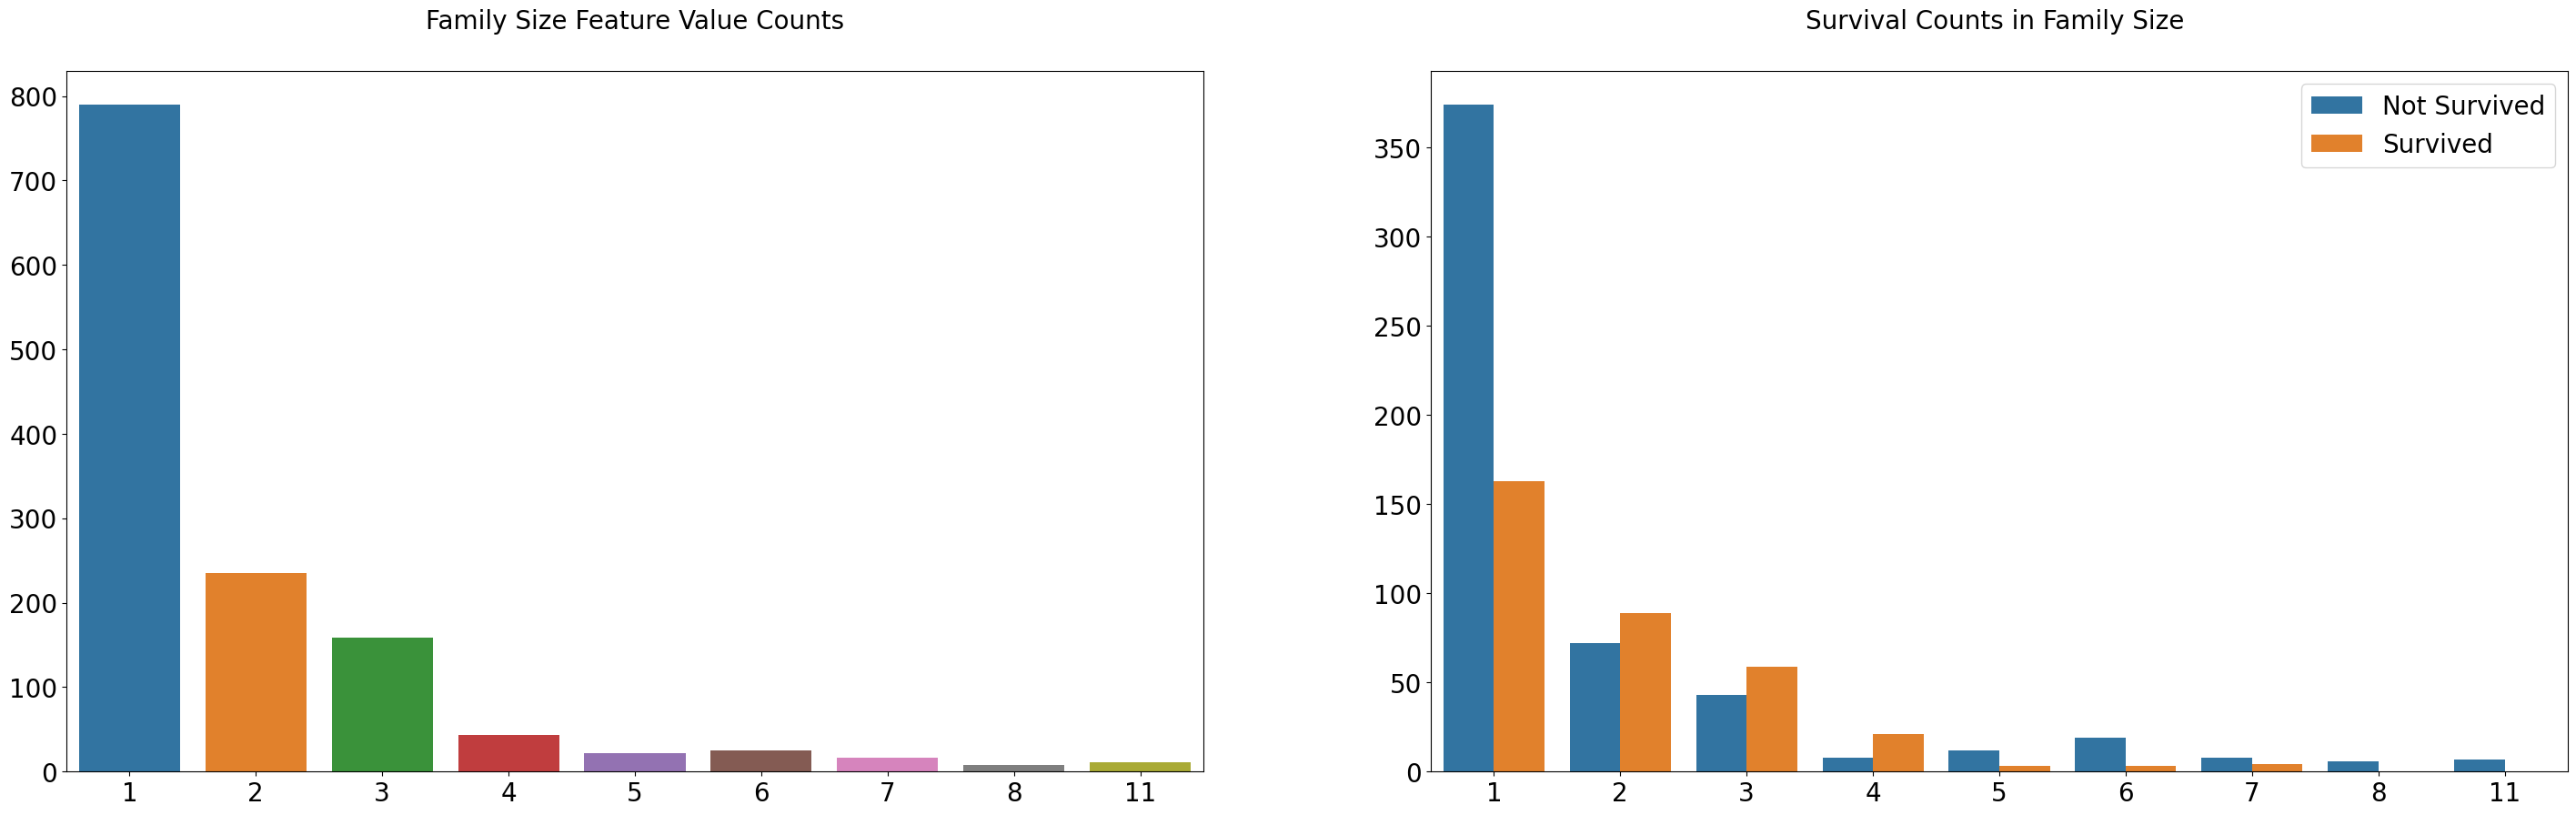

In [33]:
fig, axs = plt.subplots(figsize=(20, 10), ncols=2, nrows=1)
plt.subplots_adjust(right=1.5)

sns.barplot(x=pd.concat([df_train['FamSize'],df_test['FamSize']]).value_counts().index, y=pd.concat([df_train['FamSize'],df_test['FamSize']]).value_counts().values, ax=axs[0])
sns.countplot(x='FamSize', hue='Survived', data=df_train, ax=axs[1])

axs[0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

axs[1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
for j in range(2):
    axs[j].tick_params(axis='x', labelsize=20)
    axs[j].tick_params(axis='y', labelsize=20)
    axs[j].set_xlabel('')
    axs[j].set_ylabel('')

plt.show()

By looking at the survival rate, there is a correlation with the size of the family, where a family size of 2, 3, and 4 shows higher survival rates. Since 5, 6, and 7 share similar rates of survival, as well as 8 and 11, I decided to group this feature as follows:

**Alone:** 1<br>
**Small:** 2, 3, 4<br>
**Medium:** 5, 6, 7<br>
**Large:** 8, 11<br>

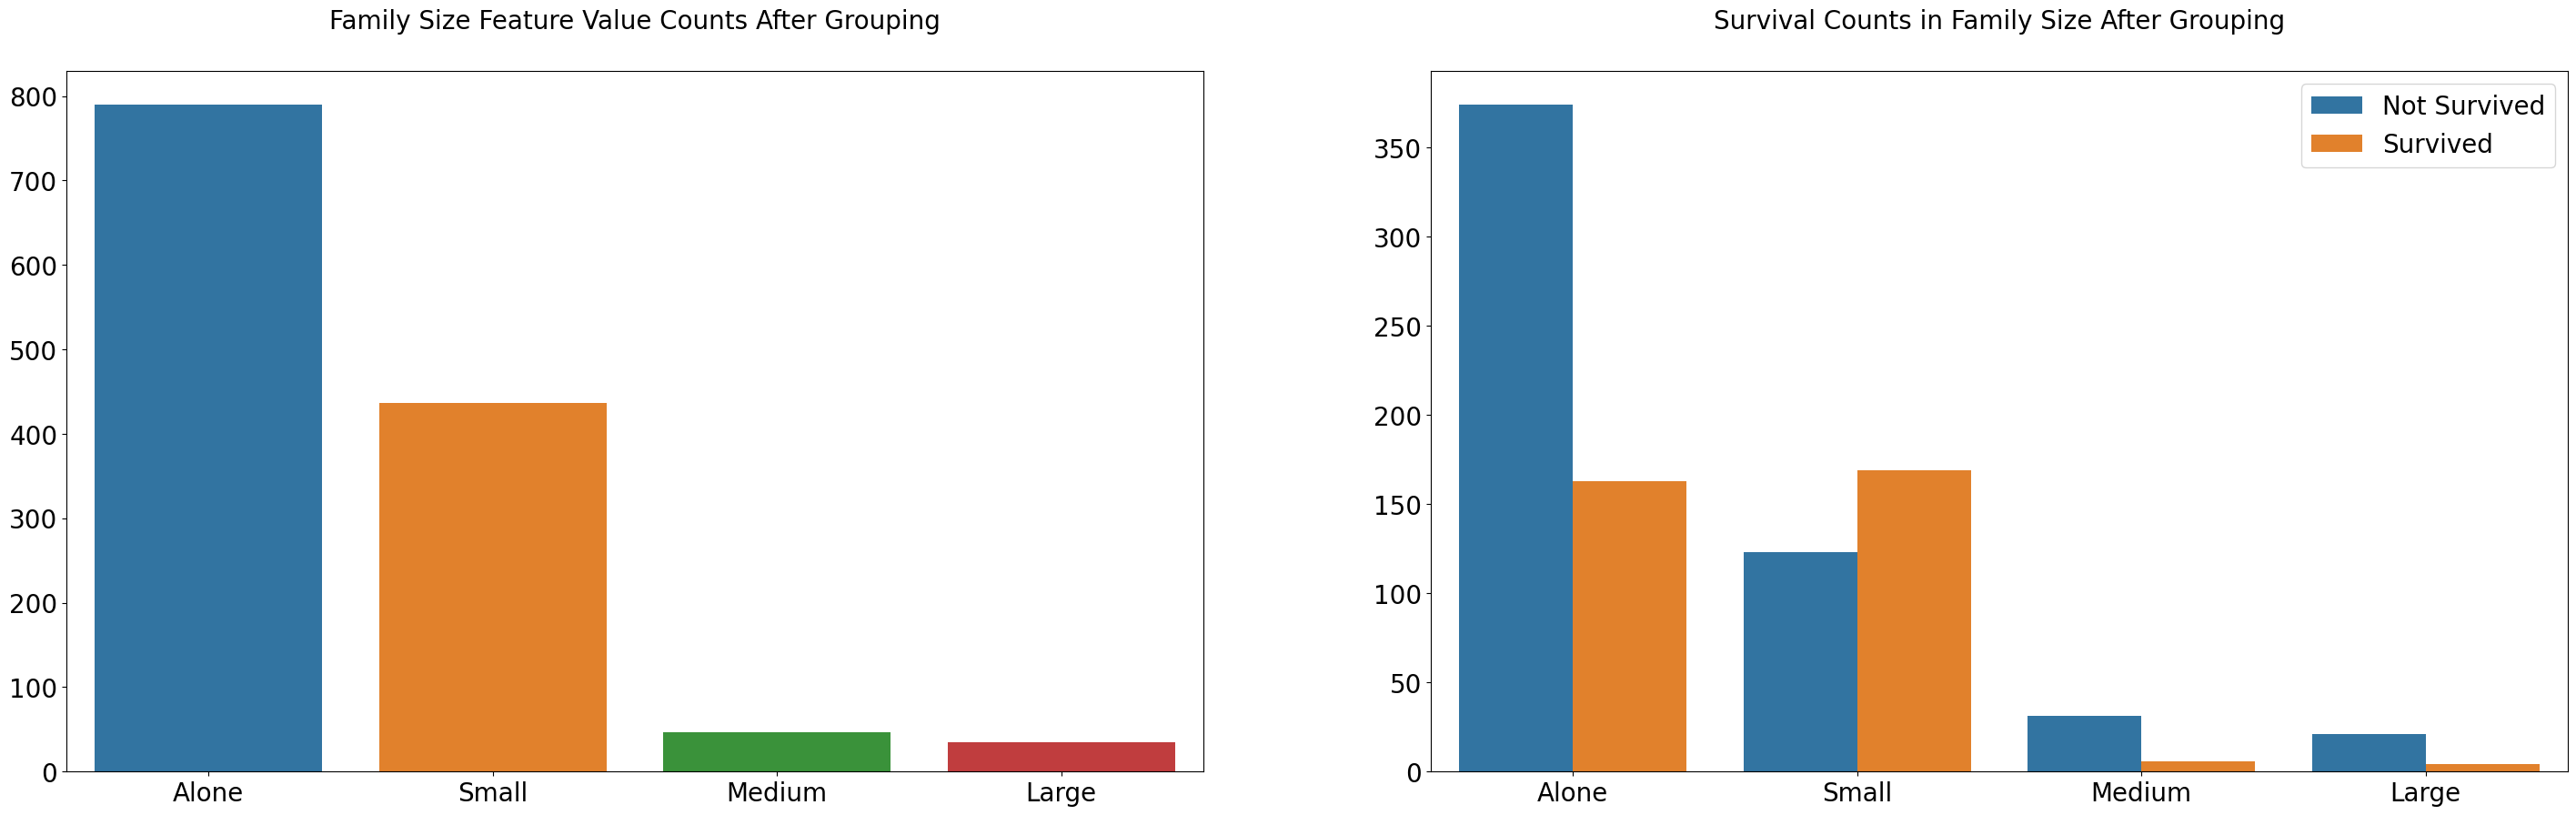

In [34]:
fig, axs = plt.subplots(figsize=(20, 10), ncols=2, nrows=1)
plt.subplots_adjust(right=1.5)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_train['FamSize_Grouped'] = df_train['FamSize'].map(family_map)
df_test['FamSize_Grouped'] = df_test['FamSize'].map(family_map)

sns.barplot(x=pd.concat([df_train['FamSize_Grouped'],df_test['FamSize_Grouped']]).value_counts().index, y=pd.concat([df_train['FamSize_Grouped'],df_test['FamSize_Grouped']]).value_counts().values, ax=axs[0])
sns.countplot(x='FamSize_Grouped', hue='Survived', data=df_train, ax=axs[1], order=pd.concat([df_train['FamSize_Grouped'],df_test['FamSize_Grouped']]).value_counts().index)

axs[0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

axs[1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
for j in range(2):
    axs[j].tick_params(axis='x', labelsize=20)
    axs[j].tick_params(axis='y', labelsize=20)
    axs[j].set_xlabel('')
    axs[j].set_ylabel('')

plt.show()

In [35]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize,FamSize_Grouped
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,2.0,0,1,0,0,2,Small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,0.0,0,0,1,0,2,Small
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,2.0,1,0,0,0,1,Alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,2.0,0,0,1,0,2,Small
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,2.0,0,1,0,0,1,Alone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,2.0,0,0,0,1,1,Alone
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,2.0,1,0,0,0,1,Alone
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.4500,2.0,1,0,0,0,4,Small
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,0.0,0,1,0,0,1,Alone


In [36]:
famsize_mapping = {'Alone': 0, 'Small': 1, 'Medium':2, 'Large': 3}

In [37]:
df_train['FamSize_Grouped'] = df_train['FamSize_Grouped'].map(famsize_mapping)
df_test['FamSize_Grouped'] = df_test['FamSize_Grouped'].map(famsize_mapping)

### Ticket Number

In [38]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize,FamSize_Grouped
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,2.0,0,1,0,0,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,0.0,0,0,1,0,2,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,2.0,1,0,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,2.0,0,0,1,0,2,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,2.0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,2.0,0,0,0,1,1,0
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,2.0,1,0,0,0,1,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.4500,2.0,1,0,0,0,4,1
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,0.0,0,1,0,0,1,0


In [39]:
df_train['Ticket'].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [40]:
df_train[df_train['Ticket']=='347082']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize,FamSize_Grouped
13,14,0,3,"Andersson, Mr. Anders Johan",0,39.0,1,5,347082,31.275,2.0,0,1,0,0,7,3
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",1,2.0,4,2,347082,31.275,2.0,1,0,0,0,7,3
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",1,9.0,4,2,347082,31.275,2.0,1,0,0,0,7,3
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",1,11.0,4,2,347082,31.275,2.0,1,0,0,0,7,3
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",1,39.0,1,5,347082,31.275,2.0,0,0,1,0,7,3
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",1,6.0,4,2,347082,31.275,2.0,1,0,0,0,7,3
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",0,4.0,4,2,347082,31.275,2.0,0,0,0,1,7,3


In [41]:
df_train[df_train['Ticket'].map(df_train['Ticket'].value_counts()) > 1].sort_values(['Ticket'])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize,FamSize_Grouped
257,258,1,1,"Cherry, Miss. Gladys",1,30.0,0,0,110152,86.500,2.0,1,0,0,0,1,0
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",1,33.0,0,0,110152,86.500,2.0,0,0,0,1,1,0
504,505,1,1,"Maioni, Miss. Roberta",1,16.0,0,0,110152,86.500,2.0,1,0,0,0,1,0
262,263,0,1,"Taussig, Mr. Emil",0,52.0,1,1,110413,79.650,2.0,0,1,0,0,3,1
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",1,39.0,1,1,110413,79.650,2.0,0,0,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,737,0,3,"Ford, Mrs. Edward (Margaret Ann Watson)",1,48.0,1,3,W./C. 6608,34.375,2.0,0,0,1,0,5,2
86,87,0,3,"Ford, Mr. William Neal",0,16.0,1,3,W./C. 6608,34.375,2.0,0,1,0,0,5,2
147,148,0,3,"Ford, Miss. Robina Maggie ""Ruby""",1,9.0,2,2,W./C. 6608,34.375,2.0,1,0,0,0,5,2
540,541,1,1,"Crosby, Miss. Harriet R",1,36.0,0,2,WE/P 5735,71.000,2.0,1,0,0,0,3,1


Looking at this, there are several passengers with the same ticket number. Interestingly, this doesn't necessarily mean that they are family e.g. Ticket Number 110152 all traveled alone and have different family name. Therefore, I would like to transform this feature based on their frequency, showing how many have the same ticket number.

In [42]:
df_test['Ticket'].value_counts()

Ticket
PC 17608    5
CA. 2343    4
113503      4
PC 17483    3
220845      3
           ..
349226      1
2621        1
4133        1
113780      1
2668        1
Name: count, Length: 363, dtype: int64

Lastly, I would like to transform this ticket feature since there are several entries having the same ticket number. Since transforming based on having the same ticket will lead to the same information as family size, I decided to transform this by their frequency.

In [43]:
df_train['Ticket_Frequency'] = df_train.groupby('Ticket')['Ticket'].transform('count')

In [44]:
df_test['Ticket_Frequency'] = df_test.groupby('Ticket')['Ticket'].transform('count')

In [45]:
df_train[df_train['Ticket'].map(df_train['Ticket'].value_counts()) > 1].sort_values(['Ticket'])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize,FamSize_Grouped,Ticket_Frequency
257,258,1,1,"Cherry, Miss. Gladys",1,30.0,0,0,110152,86.500,2.0,1,0,0,0,1,0,3
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",1,33.0,0,0,110152,86.500,2.0,0,0,0,1,1,0,3
504,505,1,1,"Maioni, Miss. Roberta",1,16.0,0,0,110152,86.500,2.0,1,0,0,0,1,0,3
262,263,0,1,"Taussig, Mr. Emil",0,52.0,1,1,110413,79.650,2.0,0,1,0,0,3,1,3
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",1,39.0,1,1,110413,79.650,2.0,0,0,1,0,3,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,737,0,3,"Ford, Mrs. Edward (Margaret Ann Watson)",1,48.0,1,3,W./C. 6608,34.375,2.0,0,0,1,0,5,2,4
86,87,0,3,"Ford, Mr. William Neal",0,16.0,1,3,W./C. 6608,34.375,2.0,0,1,0,0,5,2,4
147,148,0,3,"Ford, Miss. Robina Maggie ""Ruby""",1,9.0,2,2,W./C. 6608,34.375,2.0,1,0,0,0,5,2,4
540,541,1,1,"Crosby, Miss. Harriet R",1,36.0,0,2,WE/P 5735,71.000,2.0,1,0,0,0,3,1,2


In [46]:
df_train = df_train.drop(['Name','Ticket','SibSp', 'Parch', 'FamSize'], axis=1)
df_test = df_test.drop(['Name','Ticket','SibSp', 'Parch', 'FamSize'], axis=1)

## Feature Correlation
Feature correlation measures of how strongly two or more variables are related to each other.

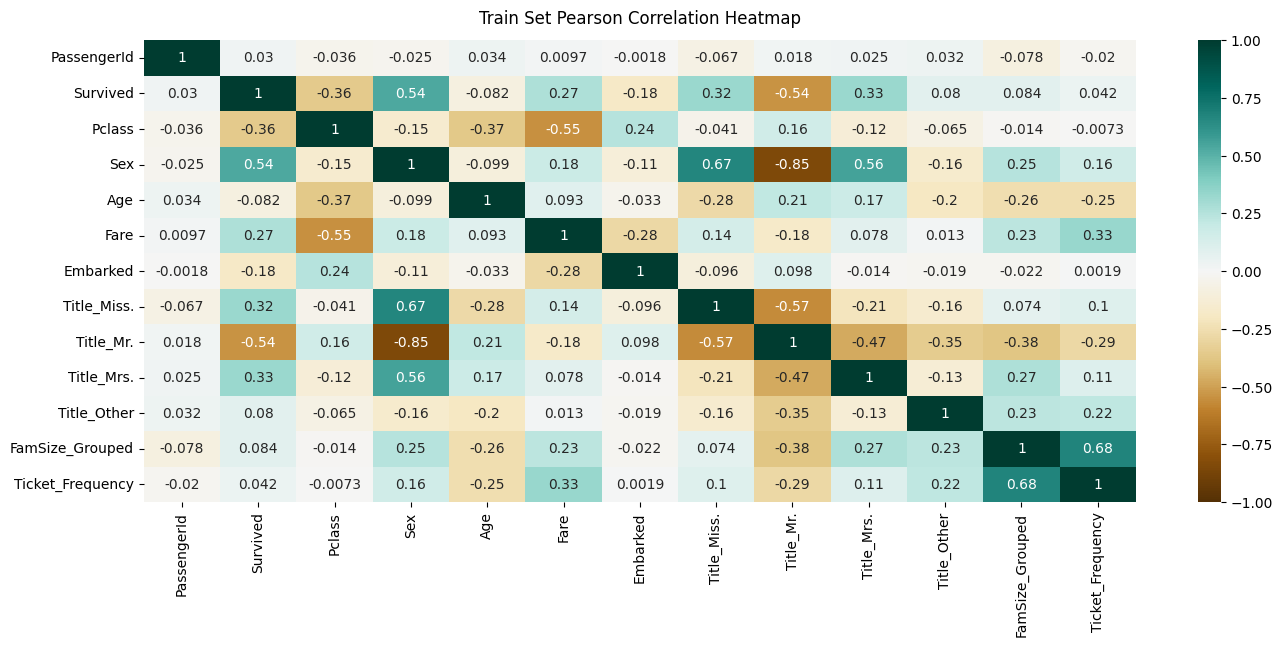

In [47]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.dropna().corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Train Set Pearson Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

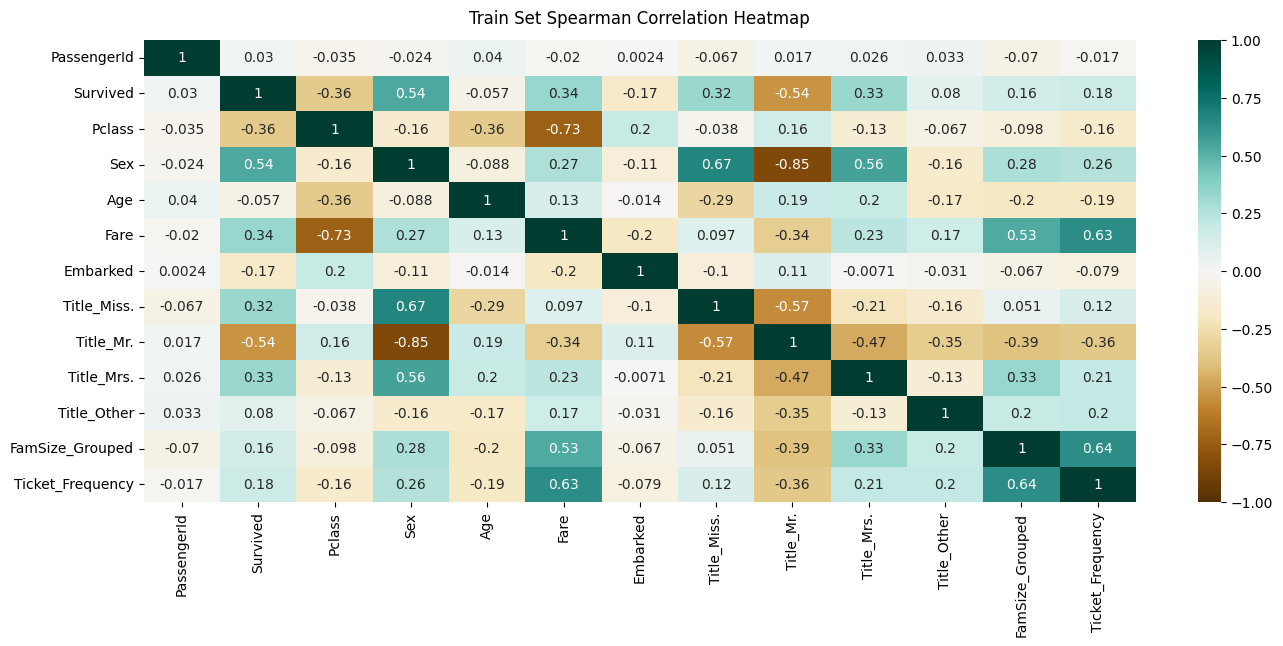

In [48]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.dropna().corr(method='spearman'), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Train Set Spearman Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Discussion
Based on the feature correlation above there are several things to note.
1. Survived correlates the most with Sex, Title (three common values), Pclass, and Fare. 
2. Sex and Title (three common values) are highly correlated with each being the most correlated to the other. This makes sense since the title of a person is closely related to their gender e.g. "Miss." and "female". 
3. Like point number 2, Pclass and Fare are also highly correlated since the higher the ticket class, the higher the fare.


In addition, for imputing Age and Embarked I want to utilize correlating categorical features.
1. For Age, the most correlating feature is Pclass.
2. Embarked seems to not be highly correlated to any of the categorical features.

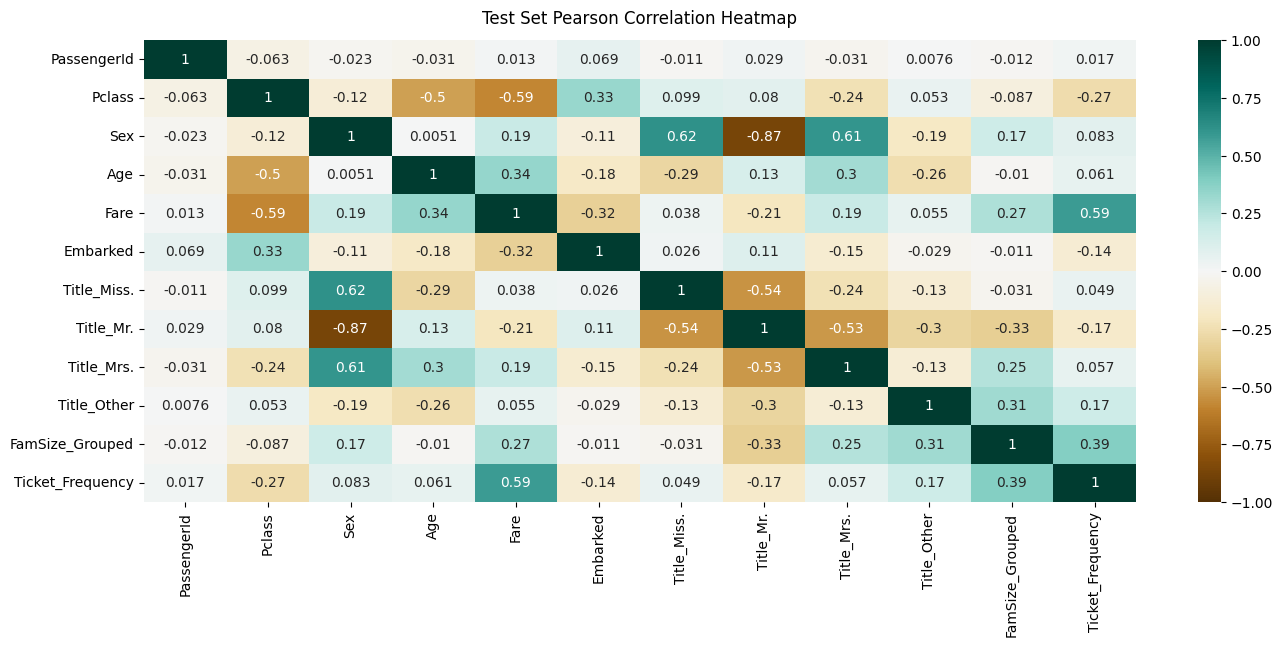

In [49]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_test.dropna().corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Test Set Pearson Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

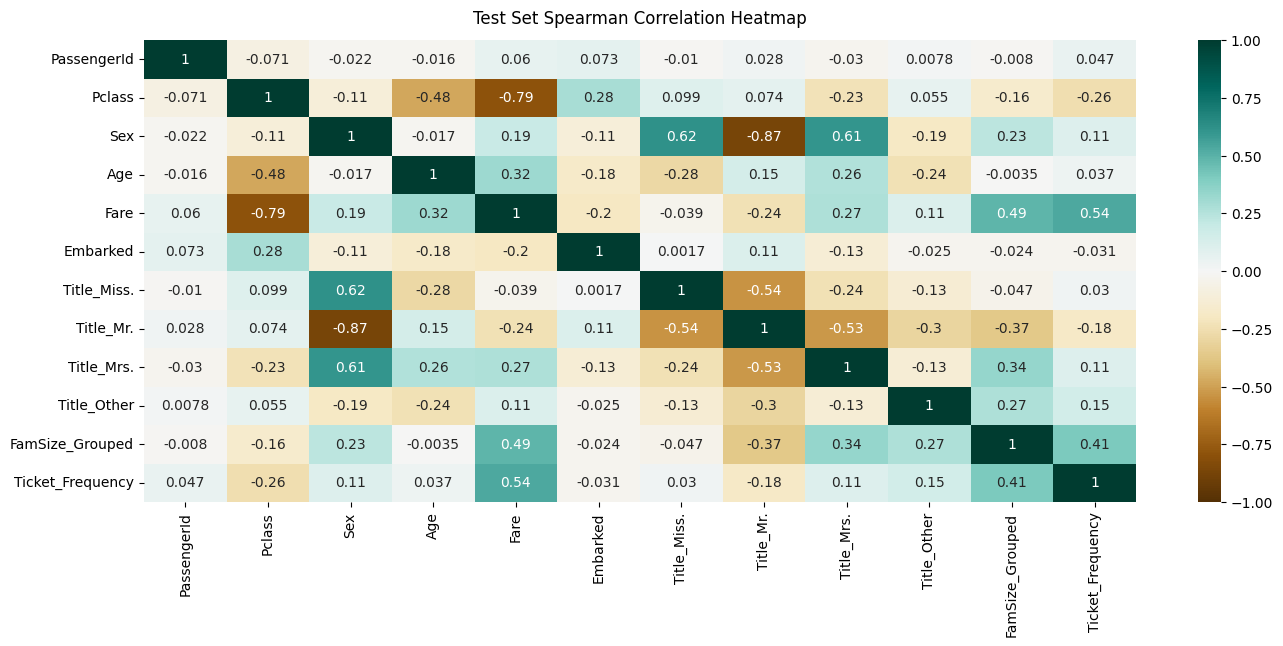

In [50]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_test.dropna().corr(method='spearman'), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Test Set Spearman Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Discussion
For imputing Age and Fare I want to utilize correlating categorical features.
1. For Age, the most correlating feature is Pclass.
2. For Fare, the most correlating feature is Pclass, which makes sense.

## Saving Unencoded and Unimputed Data for LightGBM, CatBoost, XGBoost
After several experiments, I found that LightGBM, CatBoost, XGBoost works better on unencoded and unimputed data, since the three models have native support for handling missing values and categorical data.

In [51]:
df_train_agb = df_train.copy()
df_test_agb = df_test.copy()

In [52]:
df_train_agb

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency
0,1,0,3,0,22.0,7.2500,2.0,0,1,0,0,1,1
1,2,1,1,1,38.0,71.2833,0.0,0,0,1,0,1,1
2,3,1,3,1,26.0,7.9250,2.0,1,0,0,0,0,1
3,4,1,1,1,35.0,53.1000,2.0,0,0,1,0,1,2
4,5,0,3,0,35.0,8.0500,2.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,13.0000,2.0,0,0,0,1,0,1
887,888,1,1,1,19.0,30.0000,2.0,1,0,0,0,0,1
888,889,0,3,1,NaN,23.4500,2.0,1,0,0,0,1,2
889,890,1,1,0,26.0,30.0000,0.0,0,1,0,0,0,1


In [53]:
inv_sex_mapping = {v: k for k, v in sex_mapping.items()}
inv_embarked_mapping = {v: k for k, v in embarked_mapping.items()}
inv_famsize_mapping = {v: k for k, v in famsize_mapping.items()}

In [54]:
df_train_agb['Sex'] = df_train_agb['Sex'].map(inv_sex_mapping)
df_test_agb['Sex'] = df_test_agb['Sex'].map(inv_sex_mapping)

df_train_agb['Embarked'] = df_train_agb['Embarked'].map(inv_embarked_mapping)
df_test_agb['Embarked'] = df_test_agb['Embarked'].map(inv_embarked_mapping)

df_train_agb['FamSize_Grouped'] = df_train_agb['FamSize_Grouped'].map(inv_famsize_mapping)
df_test_agb['FamSize_Grouped'] = df_test_agb['FamSize_Grouped'].map(inv_famsize_mapping)

In [55]:
df_train_agb

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency
0,1,0,3,male,22.0,7.2500,S,0,1,0,0,Small,1
1,2,1,1,female,38.0,71.2833,C,0,0,1,0,Small,1
2,3,1,3,female,26.0,7.9250,S,1,0,0,0,Alone,1
3,4,1,1,female,35.0,53.1000,S,0,0,1,0,Small,2
4,5,0,3,male,35.0,8.0500,S,0,1,0,0,Alone,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,13.0000,S,0,0,0,1,Alone,1
887,888,1,1,female,19.0,30.0000,S,1,0,0,0,Alone,1
888,889,0,3,female,NaN,23.4500,S,1,0,0,0,Small,2
889,890,1,1,male,26.0,30.0000,C,0,1,0,0,Alone,1


In [56]:
one_hot_columns = ['Title_Miss.', 'Title_Mr.', 'Title_Mrs.','Title_Other']

df_train_agb['Title'] = df_train_agb[one_hot_columns].idxmax(axis=1).str.split('_').str[1]
df_test_agb['Title'] = df_test_agb[one_hot_columns].idxmax(axis=1).str.split('_').str[1]

df_train_agb.drop(columns=one_hot_columns, inplace=True)
df_test_agb.drop(columns=one_hot_columns, inplace=True)

In [57]:
df_train_agb['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Other'], dtype=object)

In [58]:
df_test_agb['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Other'], dtype=object)

Additionally, here I handled Embarked by filling them with the actual data I found by researching.

In [59]:
df_train_agb[df_train_agb['Embarked'].isna()]

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamSize_Grouped,Ticket_Frequency,Title
61,62,1,1,female,38.0,80.0,NaN,Alone,2,Miss.
829,830,1,1,female,62.0,80.0,NaN,Alone,2,Mrs.


In [60]:
df_train_agb['Embarked']=df_train_agb['Embarked'].fillna('S')

## Handling Missing Values Part 2
Methods:
1. Imputing with Mean, Median and Mode, Grouped By Correlating Features
2. Imputing with Mean, Median and Mode
3. Dropping Rows with Missing Values
4. Random Forest Imputation, chosen over KNN due to KNN being sensitive to outliers

### 1. Imputing with Mean, Median and Mode, Grouped By Correlating Features

In [61]:
df_train_temp = df_train.copy()
df_test_temp = df_test.copy()

In [62]:
df_train_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       891 non-null    int64  
 1   Survived          891 non-null    int64  
 2   Pclass            891 non-null    int64  
 3   Sex               891 non-null    int64  
 4   Age               714 non-null    float64
 5   Fare              891 non-null    float64
 6   Embarked          889 non-null    float64
 7   Title_Miss.       891 non-null    int64  
 8   Title_Mr.         891 non-null    int64  
 9   Title_Mrs.        891 non-null    int64  
 10  Title_Other       891 non-null    int64  
 11  FamSize_Grouped   891 non-null    int64  
 12  Ticket_Frequency  891 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 90.6 KB


In [63]:
age_by_pclass_sex = df_train.groupby(['Sex', 'Pclass']).median()['Age']
for pclass in range(1, 4):
    for sex in [1, 0]:
        print('Train Set Median age of Pclass {} {}s: {}'.format(pclass, 'male' if sex==0 else 'female', age_by_pclass_sex[sex][pclass]))
print('Train Set Median age of all passengers: {}'.format(df_train['Age'].median()))

Train Set Median age of Pclass 1 females: 35.0
Train Set Median age of Pclass 1 males: 40.0
Train Set Median age of Pclass 2 females: 28.0
Train Set Median age of Pclass 2 males: 30.0
Train Set Median age of Pclass 3 females: 21.5
Train Set Median age of Pclass 3 males: 25.0
Train Set Median age of all passengers: 28.0


In [64]:
age_by_pclass_sex = df_test.groupby(['Sex', 'Pclass']).median()['Age']
for pclass in range(1, 4):
    for sex in [1, 0]:
        print('Test Set Median age of Pclass {} {}s: {}'.format(pclass, 'male' if sex==0 else 'female', age_by_pclass_sex[sex][pclass]))
print('Test Set Median age of all passengers: {}'.format(df_test['Age'].median()))

Test Set Median age of Pclass 1 females: 41.0
Test Set Median age of Pclass 1 males: 42.0
Test Set Median age of Pclass 2 females: 24.0
Test Set Median age of Pclass 2 males: 28.0
Test Set Median age of Pclass 3 females: 22.0
Test Set Median age of Pclass 3 males: 24.0
Test Set Median age of all passengers: 27.0


In [65]:
df_train[df_train['Age'].isna()]

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency
5,6,0,3,0,NaN,8.4583,1.0,0,1,0,0,0,1
17,18,1,2,0,NaN,13.0000,2.0,0,1,0,0,0,1
19,20,1,3,1,NaN,7.2250,0.0,0,0,1,0,0,1
26,27,0,3,0,NaN,7.2250,0.0,0,1,0,0,0,1
28,29,1,3,1,NaN,7.8792,1.0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,0,NaN,7.2292,0.0,0,1,0,0,0,1
863,864,0,3,1,NaN,69.5500,2.0,1,0,0,0,3,7
868,869,0,3,0,NaN,9.5000,2.0,0,1,0,0,0,1
878,879,0,3,0,NaN,7.8958,2.0,0,1,0,0,0,1


In [66]:
missing_age_positions = df_train['Age'].isna()

In [67]:
train_grouped = df_train.groupby(['Sex', 'Pclass'])['Age'].transform('median')
df_train['Age'].fillna(train_grouped,inplace=True)

test_grouped = df_test.groupby(['Sex', 'Pclass'])['Age'].transform('median')
df_test['Age'].fillna(test_grouped,inplace=True)

/tmp/ipykernel_18/4131626364.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Age'].fillna(train_grouped,inplace=True)
/tmp/ipykernel_18/4131626364.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [68]:
df_train[missing_age_positions]

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency
5,6,0,3,0,25.0,8.4583,1.0,0,1,0,0,0,1
17,18,1,2,0,30.0,13.0000,2.0,0,1,0,0,0,1
19,20,1,3,1,21.5,7.2250,0.0,0,0,1,0,0,1
26,27,0,3,0,25.0,7.2250,0.0,0,1,0,0,0,1
28,29,1,3,1,21.5,7.8792,1.0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,0,25.0,7.2292,0.0,0,1,0,0,0,1
863,864,0,3,1,21.5,69.5500,2.0,1,0,0,0,3,7
868,869,0,3,0,25.0,9.5000,2.0,0,1,0,0,0,1
878,879,0,3,0,25.0,7.8958,2.0,0,1,0,0,0,1


In [69]:
df_train[df_train['Embarked'].isna()]

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency
61,62,1,1,1,38.0,80.0,NaN,1,0,0,0,0,2
829,830,1,1,1,62.0,80.0,NaN,0,0,1,0,0,2


In [70]:
missing_embarked_positions = df_train['Embarked'].isna()

In [71]:
df_train['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode()[0])

In [72]:
df_train[missing_embarked_positions]

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency
61,62,1,1,1,38.0,80.0,2.0,1,0,0,0,0,2
829,830,1,1,1,62.0,80.0,2.0,0,0,1,0,0,2


In [73]:
df_test[df_test['Fare'].isna()]

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency
152,1044,3,0,60.5,NaN,2,0,1,0,0,0,1


For Fare, I would like to use Pclass since it highly correlates with Fare.

In [74]:
fare_by_pclass = df_train.groupby(['Pclass']).mean()['Fare']
for pclass in range(1, 4):
    print('Test Set Mean Fare of Pclass {}: {}'.format(pclass, fare_by_pclass[pclass]))
print('Test Set Mean Fare of all passengers: {}'.format(df_test['Fare'].mean()))

Test Set Mean Fare of Pclass 1: 84.1546875
Test Set Mean Fare of Pclass 2: 20.662183152173913
Test Set Mean Fare of Pclass 3: 13.675550101832993
Test Set Mean Fare of all passengers: 35.627188489208635


In [75]:
missing_fare_positions = df_test['Fare'].isna()

In [76]:
test_grouped = df_test.groupby(['Pclass'])['Fare'].transform('mean')
df_test['Fare'].fillna(test_grouped,inplace=True)

/tmp/ipykernel_18/121017961.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['Fare'].fillna(test_grouped,inplace=True)


In [77]:
df_test[missing_fare_positions]

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency
152,1044,3,0,60.5,12.459678,2,0,1,0,0,0,1


### 2. Imputing with Mean, Median and Mode

In [78]:
df_train2 = df_train_temp.copy()
df_test2 = df_test_temp.copy()

In [79]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       891 non-null    int64  
 1   Survived          891 non-null    int64  
 2   Pclass            891 non-null    int64  
 3   Sex               891 non-null    int64  
 4   Age               714 non-null    float64
 5   Fare              891 non-null    float64
 6   Embarked          889 non-null    float64
 7   Title_Miss.       891 non-null    int64  
 8   Title_Mr.         891 non-null    int64  
 9   Title_Mrs.        891 non-null    int64  
 10  Title_Other       891 non-null    int64  
 11  FamSize_Grouped   891 non-null    int64  
 12  Ticket_Frequency  891 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 90.6 KB


In [80]:
df_train2['Age'] = df_train2['Age'].fillna(df_train2['Age'].median())
df_train2['Embarked'] = df_train2['Embarked'].fillna(df_train2['Embarked'].mode()[0])
df_test2['Age'] = df_train2['Age'].fillna(df_test2['Age'].median())
df_test2['Fare'] = df_train2['Fare'].fillna(df_test2['Fare'].mean())

In [81]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       891 non-null    int64  
 1   Survived          891 non-null    int64  
 2   Pclass            891 non-null    int64  
 3   Sex               891 non-null    int64  
 4   Age               891 non-null    float64
 5   Fare              891 non-null    float64
 6   Embarked          891 non-null    float64
 7   Title_Miss.       891 non-null    int64  
 8   Title_Mr.         891 non-null    int64  
 9   Title_Mrs.        891 non-null    int64  
 10  Title_Other       891 non-null    int64  
 11  FamSize_Grouped   891 non-null    int64  
 12  Ticket_Frequency  891 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 90.6 KB


In [82]:
df_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       418 non-null    int64  
 1   Pclass            418 non-null    int64  
 2   Sex               418 non-null    int64  
 3   Age               418 non-null    float64
 4   Fare              418 non-null    float64
 5   Embarked          418 non-null    int64  
 6   Title_Miss.       418 non-null    int64  
 7   Title_Mr.         418 non-null    int64  
 8   Title_Mrs.        418 non-null    int64  
 9   Title_Other       418 non-null    int64  
 10  FamSize_Grouped   418 non-null    int64  
 11  Ticket_Frequency  418 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 39.3 KB


### 3. Dropping Rows with Missing Values

In [83]:
df_train3 = df_train_temp.copy()
df_test3 = df_test_temp.copy()

In [84]:
df_train3 = df_train3.dropna()
df_test3 = df_test3.dropna()

### 4. Random Forest Imputer

In [85]:
df_train4 = df_train_temp.copy()
df_test4 = df_test_temp.copy()

In [86]:
df_train4[missing_age_positions]

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency
5,6,0,3,0,NaN,8.4583,1.0,0,1,0,0,0,1
17,18,1,2,0,NaN,13.0000,2.0,0,1,0,0,0,1
19,20,1,3,1,NaN,7.2250,0.0,0,0,1,0,0,1
26,27,0,3,0,NaN,7.2250,0.0,0,1,0,0,0,1
28,29,1,3,1,NaN,7.8792,1.0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,0,NaN,7.2292,0.0,0,1,0,0,0,1
863,864,0,3,1,NaN,69.5500,2.0,1,0,0,0,3,7
868,869,0,3,0,NaN,9.5000,2.0,0,1,0,0,0,1
878,879,0,3,0,NaN,7.8958,2.0,0,1,0,0,0,1


In [87]:
mf = MissForest()
df_train4[:] = mf.fit_transform(df_train4)
df_test4[:] = mf.fit_transform(df_test4)

 40%|████      | 2/5 [00:00<00:00, 15.91it/s]/opt/conda/lib/python3.10/site-packages/missforest/missforest.py:348: UserWarning: NRMSE increased.
  warnings.warn("NRMSE increased.")
/opt/conda/lib/python3.10/site-packages/missforest/missforest.py:538: UserWarning: Stopping criterion triggered. Before last imputation matrix will be returned.
  warnings.warn("Stopping criterion triggered. Before last "
 60%|██████    | 3/5 [00:00<00:00, 11.64it/s]


In [88]:
df_train4[missing_age_positions]

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency
5,6,0,3,0,30.745445,8.4583,1.0,0,1,0,0,0,1
17,18,1,2,0,37.349472,13.0000,2.0,0,1,0,0,0,1
19,20,1,3,1,29.907146,7.2250,0.0,0,0,1,0,0,1
26,27,0,3,0,28.114064,7.2250,0.0,0,1,0,0,0,1
28,29,1,3,1,20.966562,7.8792,1.0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,0,37.639793,7.2292,0.0,0,1,0,0,0,1
863,864,0,3,1,20.363159,69.5500,2.0,1,0,0,0,3,7
868,869,0,3,0,26.951775,9.5000,2.0,0,1,0,0,0,1
878,879,0,3,0,28.826600,7.8958,2.0,0,1,0,0,0,1


## Evaluation with Baseline Models
Here I chosen three baseline models to compare these methods and also get a picture of the performance, namely Support Vector Machine, Random Forest, and eXtreme Gradient Boost.

In [89]:
exclude_columns = ['PassengerId', 'Survived']
features = [col for col in df_train.columns if col not in exclude_columns]

In [90]:
X = df_train[features]
y = df_train["Survived"]

X2 = df_train2[features]
y2 = df_train2["Survived"]

X3 = df_train3[features]
y3 = df_train3["Survived"]

X4 = df_train4[features]
y4 = df_train4["Survived"]

In [91]:
X

,Pclass,Sex,Age,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency
0,3,0,22.0,7.2500,2.0,0,1,0,0,1,1
1,1,1,38.0,71.2833,0.0,0,0,1,0,1,1
2,3,1,26.0,7.9250,2.0,1,0,0,0,0,1
3,1,1,35.0,53.1000,2.0,0,0,1,0,1,2
4,3,0,35.0,8.0500,2.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,27.0,13.0000,2.0,0,0,0,1,0,1
887,1,1,19.0,30.0000,2.0,1,0,0,0,0,1
888,3,1,21.5,23.4500,2.0,1,0,0,0,1,2
889,1,0,26.0,30.0000,0.0,0,1,0,0,0,1


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=0)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.20, random_state=0)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.20, random_state=0)

### Support Vector Machine

Baseline SVC Evaluation with Imputing with Median and Mode, Grouped By Correlating Features
-------------------------------------------------------------------------------------------
Target Mapping: {'Survived, No': 0, 'Yes': 1}
Accuracy: 0.8212290502793296
Precision: 0.7681159420289855
Recall: 0.7681159420289855
F1-Score: 0.7681159420289855
ROC-AUC Score: 0.8113306982872199

Classification Report
-------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.77      0.77      0.77        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



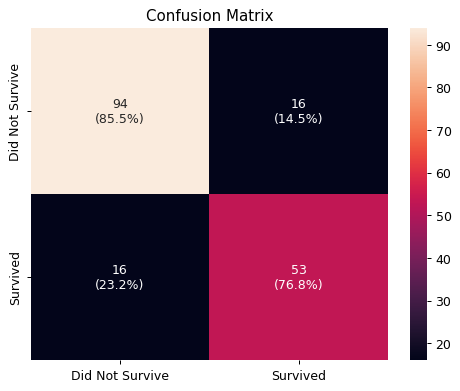

-------------------------------------------------------------------------------------------


Baseline SVC Evaluation with Imputing with Median and Mode
-------------------------------------------------------------------------------------------
Target Mapping: {'Survived, No': 0, 'Yes': 1}
Accuracy: 0.8212290502793296
Precision: 0.7681159420289855
Recall: 0.7681159420289855
F1-Score: 0.7681159420289855
ROC-AUC Score: 0.8113306982872199

Classification Report
-------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.77      0.77      0.77        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



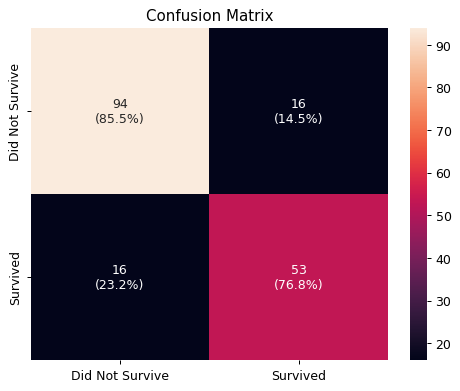

-------------------------------------------------------------------------------------------


Baseline SVC Evaluation with Dropping Rows with Missing Values
-------------------------------------------------------------------------------------------
Target Mapping: {'Survived, No': 0, 'Yes': 1}
Accuracy: 0.8251748251748252
Precision: 0.8103448275862069
Recall: 0.7704918032786885
F1-Score: 0.7899159663865546
ROC-AUC Score: 0.8181727309076369

Classification Report
-------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        82
           1       0.81      0.77      0.79        61

    accuracy                           0.83       143
   macro avg       0.82      0.82      0.82       143
weighted avg       0.82      0.83      0.82       143



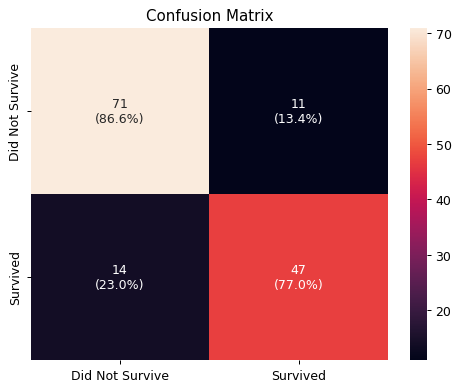

-------------------------------------------------------------------------------------------


Baseline SVC Evaluation with Random Forest Imputer
-------------------------------------------------------------------------------------------
Target Mapping: {'Survived, No': 0, 'Yes': 1}
Accuracy: 0.8212290502793296
Precision: 0.7681159420289855
Recall: 0.7681159420289855
F1-Score: 0.7681159420289855
ROC-AUC Score: 0.8113306982872199

Classification Report
-------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.77      0.77      0.77        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



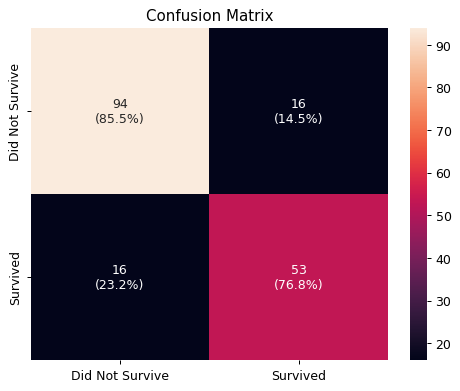

-------------------------------------------------------------------------------------------




In [93]:
data_split_arr = [
    (X_train, X_test, y_train, y_test),
    (X_train2, X_test2, y_train2, y_test2),
    (X_train3, X_test3, y_train3, y_test3),
    (X_train4, X_test4, y_train4, y_test4)
]

method_name_arr = [
    "Imputing with Median and Mode, Grouped By Correlating Features",
    "Imputing with Median and Mode",
    "Dropping Rows with Missing Values",
    "Random Forest Imputer"
]
svc_results = {
    'ROC-AUC': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}
for i, (X_train, X_test, y_train, y_test) in enumerate(data_split_arr):
    model = SVC()
    svc = imbpipeline(steps = [['standardscaler', StandardScaler()],
                                    ['SVC', model]])
    svc.fit(X_train, y_train)
    y_pred_svc = svc.predict(X_test)
    
    roc_auc = metrics.roc_auc_score(y_test, y_pred_svc)
    accuracy = metrics.accuracy_score(y_test, y_pred_svc)
    precision = metrics.precision_score(y_test, y_pred_svc)
    recall = metrics.recall_score(y_test, y_pred_svc)
    f1_score = metrics.f1_score(y_test, y_pred_svc)
    
    svc_results['ROC-AUC'].append(roc_auc)
    svc_results['Accuracy'].append(accuracy)
    svc_results['Precision'].append(precision)
    svc_results['Recall'].append(recall)
    svc_results['F1-Score'].append(f1_score)
    
    print(f"Baseline SVC Evaluation with {method_name_arr[i]}")
    print("-------------------------------------------------------------------------------------------")
    print("Target Mapping: {'Survived, No': 0, 'Yes': 1}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1_score}")
    print(f"ROC-AUC Score: {roc_auc}\n")
    print("Classification Report")
    print("-------------------------------------------------------------------------------------------")
    print(metrics.classification_report(y_test, y_pred_svc))
    svc_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_svc, labels=np.unique(y_pred_svc))
    svc_confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_svc, normalize="true")
    annot = np.array([f"{i}\n({g:.1%})" for i, g in zip(svc_confusion_matrix.flatten(), svc_confusion_matrix_norm.flatten())])
    annot = annot.reshape(svc_confusion_matrix.shape)

    fig = plt.figure(dpi=90)
    sns.heatmap(svc_confusion_matrix, annot=annot, fmt="", xticklabels=['Did Not Survive','Survived'], yticklabels=['Did Not Survive','Survived'])
    plt.title("Confusion Matrix")
    plt.show()
    print("-------------------------------------------------------------------------------------------\n\n")

In [94]:
df_results_svc = pd.DataFrame(svc_results, index=method_name_arr)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

styled_df_results_svc = df_results_svc.iloc[:, :].style.apply(highlight_max, axis=0)
styled_df_results_svc

,ROC-AUC,Accuracy,Precision,Recall,F1-Score
"Imputing with Median and Mode, Grouped By Correlating Features",0.811331,0.821229,0.768116,0.768116,0.768116
Imputing with Median and Mode,0.811331,0.821229,0.768116,0.768116,0.768116
Dropping Rows with Missing Values,0.818173,0.825175,0.810345,0.770492,0.789916
Random Forest Imputer,0.811331,0.821229,0.768116,0.768116,0.768116


### Random Forest

Baseline RF Evaluation with Imputing with Median and Mode, Grouped By Correlating Features
-------------------------------------------------------------------------------------------
Target Mapping: {'Survived, No': 0, 'Yes': 1}
Accuracy: 0.8268156424581006
Precision: 0.8275862068965517
Recall: 0.6956521739130435
F1-Score: 0.7559055118110236
ROC-AUC Score: 0.8023715415019763

Classification Report
-------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       110
           1       0.83      0.70      0.76        69

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179



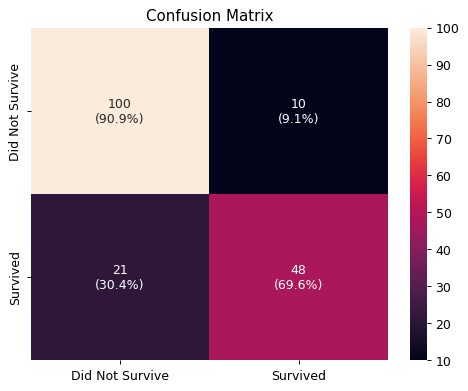

-------------------------------------------------------------------------------------------


Baseline RF Evaluation with Imputing with Median and Mode
-------------------------------------------------------------------------------------------
Target Mapping: {'Survived, No': 0, 'Yes': 1}
Accuracy: 0.8100558659217877
Precision: 0.7692307692307693
Recall: 0.7246376811594203
F1-Score: 0.7462686567164178
ROC-AUC Score: 0.7941370223978921

Classification Report
-------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       110
           1       0.77      0.72      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



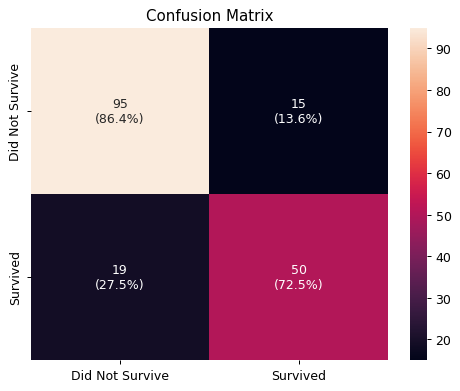

-------------------------------------------------------------------------------------------


Baseline RF Evaluation with Dropping Rows with Missing Values
-------------------------------------------------------------------------------------------
Target Mapping: {'Survived, No': 0, 'Yes': 1}
Accuracy: 0.7832167832167832
Precision: 0.734375
Recall: 0.7704918032786885
F1-Score: 0.7519999999999999
ROC-AUC Score: 0.7815873650539784

Classification Report
-------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        82
           1       0.73      0.77      0.75        61

    accuracy                           0.78       143
   macro avg       0.78      0.78      0.78       143
weighted avg       0.79      0.78      0.78       143



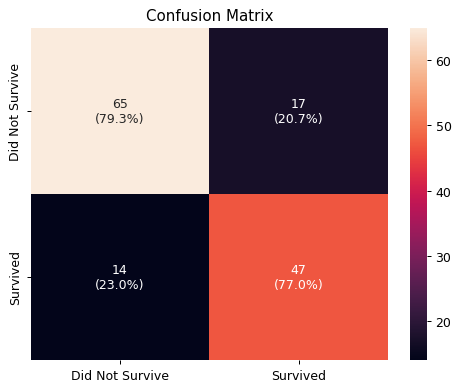

-------------------------------------------------------------------------------------------


Baseline RF Evaluation with Random Forest Imputer
-------------------------------------------------------------------------------------------
Target Mapping: {'Survived, No': 0, 'Yes': 1}
Accuracy: 0.8268156424581006
Precision: 0.7878787878787878
Recall: 0.7536231884057971
F1-Score: 0.7703703703703704
ROC-AUC Score: 0.813175230566535

Classification Report
-------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       110
           1       0.79      0.75      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



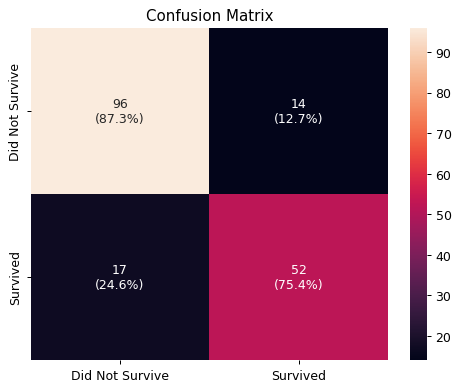

-------------------------------------------------------------------------------------------




In [95]:
rf_results = {
    'ROC-AUC': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}
for i, (X_train, X_test, y_train, y_test) in enumerate(data_split_arr):
    model = RandomForestClassifier()
    rf = imbpipeline(steps = [['standardscaler', StandardScaler()],
                                    ['SVC', model]])
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    
    roc_auc = metrics.roc_auc_score(y_test, y_pred_rf)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    precision = metrics.precision_score(y_test, y_pred_rf)
    recall = metrics.recall_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf)
    
    rf_results['ROC-AUC'].append(roc_auc)
    rf_results['Accuracy'].append(accuracy)
    rf_results['Precision'].append(precision)
    rf_results['Recall'].append(recall)
    rf_results['F1-Score'].append(f1_score)
    
    print(f"Baseline RF Evaluation with {method_name_arr[i]}")
    print("-------------------------------------------------------------------------------------------")
    print("Target Mapping: {'Survived, No': 0, 'Yes': 1}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1_score}")
    print(f"ROC-AUC Score: {roc_auc}\n")
    print("Classification Report")
    print("-------------------------------------------------------------------------------------------")
    print(metrics.classification_report(y_test, y_pred_rf))
    rf_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf, labels=np.unique(y_pred_rf))
    rf_confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="true")
    annot = np.array([f"{i}\n({g:.1%})" for i, g in zip(rf_confusion_matrix.flatten(), rf_confusion_matrix_norm.flatten())])
    annot = annot.reshape(rf_confusion_matrix.shape)

    fig = plt.figure(dpi=90)
    sns.heatmap(rf_confusion_matrix, annot=annot, fmt="", xticklabels=['Did Not Survive','Survived'], yticklabels=['Did Not Survive','Survived'])
    plt.title("Confusion Matrix")
    plt.show()
    print("-------------------------------------------------------------------------------------------\n\n")

In [96]:
df_results_rf = pd.DataFrame(rf_results, index=method_name_arr)
styled_df_results_rf = df_results_rf.iloc[:, :].style.apply(highlight_max, axis=0)
styled_df_results_rf

,ROC-AUC,Accuracy,Precision,Recall,F1-Score
"Imputing with Median and Mode, Grouped By Correlating Features",0.802372,0.826816,0.827586,0.695652,0.755906
Imputing with Median and Mode,0.794137,0.810056,0.769231,0.724638,0.746269
Dropping Rows with Missing Values,0.781587,0.783217,0.734375,0.770492,0.752000
Random Forest Imputer,0.813175,0.826816,0.787879,0.753623,0.770370


### XGBoost

Baseline XGBoost Evaluation with Imputing with Median and Mode, Grouped By Correlating Features
-------------------------------------------------------------------------------------------
Target Mapping: {'Survived, No': 0, 'Yes': 1}
Accuracy: 0.8491620111731844
Precision: 0.8387096774193549
Recall: 0.7536231884057971
F1-Score: 0.7938931297709925
ROC-AUC Score: 0.831357048748353

Classification Report
-------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       110
           1       0.84      0.75      0.79        69

    accuracy                           0.85       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



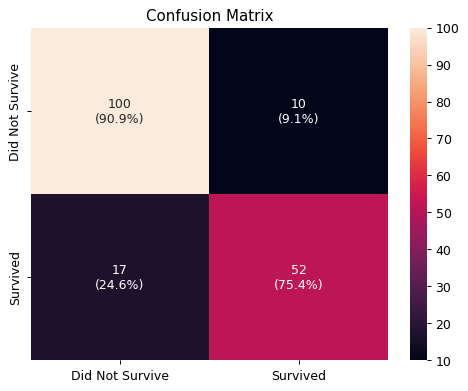

-------------------------------------------------------------------------------------------


Baseline XGBoost Evaluation with Imputing with Median and Mode
-------------------------------------------------------------------------------------------
Target Mapping: {'Survived, No': 0, 'Yes': 1}
Accuracy: 0.8324022346368715
Precision: 0.8095238095238095
Recall: 0.7391304347826086
F1-Score: 0.7727272727272727
ROC-AUC Score: 0.8150197628458498

Classification Report
-------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



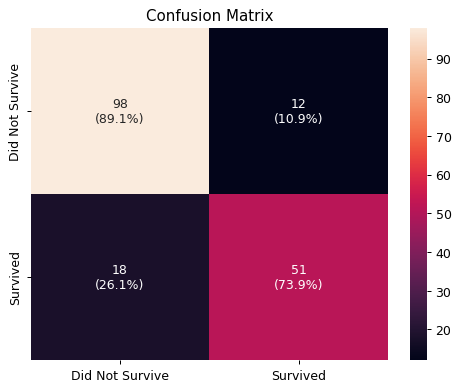

-------------------------------------------------------------------------------------------


Baseline XGBoost Evaluation with Dropping Rows with Missing Values
-------------------------------------------------------------------------------------------
Target Mapping: {'Survived, No': 0, 'Yes': 1}
Accuracy: 0.8181818181818182
Precision: 0.7966101694915254
Recall: 0.7704918032786885
F1-Score: 0.7833333333333333
ROC-AUC Score: 0.8120751699320272

Classification Report
-------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        82
           1       0.80      0.77      0.78        61

    accuracy                           0.82       143
   macro avg       0.81      0.81      0.81       143
weighted avg       0.82      0.82      0.82       143



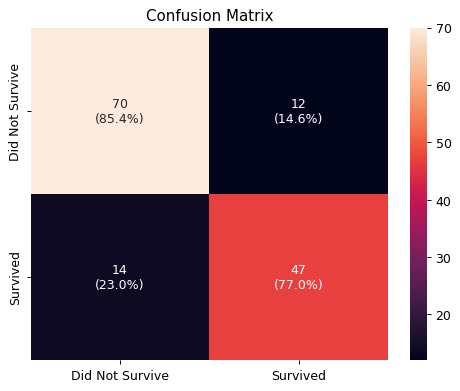

-------------------------------------------------------------------------------------------


Baseline XGBoost Evaluation with Random Forest Imputer
-------------------------------------------------------------------------------------------
Target Mapping: {'Survived, No': 0, 'Yes': 1}
Accuracy: 0.8547486033519553
Precision: 0.8307692307692308
Recall: 0.782608695652174
F1-Score: 0.8059701492537313
ROC-AUC Score: 0.841304347826087

Classification Report
-------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       110
           1       0.83      0.78      0.81        69

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



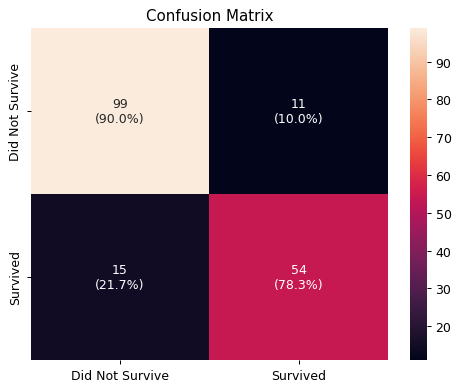

-------------------------------------------------------------------------------------------




In [97]:
xgb_results = {
    'ROC-AUC': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}
for i, (X_train, X_test, y_train, y_test) in enumerate(data_split_arr):
    model = XGBClassifier()
    xgb = imbpipeline(steps = [['standardscaler', StandardScaler()],
                                    ['SVC', model]])                   
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    
    roc_auc = metrics.roc_auc_score(y_test, y_pred_xgb)
    accuracy = metrics.accuracy_score(y_test, y_pred_xgb)
    precision = metrics.precision_score(y_test, y_pred_xgb)
    recall = metrics.recall_score(y_test, y_pred_xgb)
    f1_score = metrics.f1_score(y_test, y_pred_xgb)
    
    xgb_results['ROC-AUC'].append(roc_auc)
    xgb_results['Accuracy'].append(accuracy)
    xgb_results['Precision'].append(precision)
    xgb_results['Recall'].append(recall)
    xgb_results['F1-Score'].append(f1_score)
    
    print(f"Baseline XGBoost Evaluation with {method_name_arr[i]}")
    print("-------------------------------------------------------------------------------------------")
    print("Target Mapping: {'Survived, No': 0, 'Yes': 1}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1_score}")
    print(f"ROC-AUC Score: {roc_auc}\n")
    print("Classification Report")
    print("-------------------------------------------------------------------------------------------")
    print(metrics.classification_report(y_test, y_pred_xgb))
    xgb_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_xgb, labels=np.unique(y_pred_xgb))
    xgb_confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_xgb, normalize="true")
    annot = np.array([f"{i}\n({g:.1%})" for i, g in zip(xgb_confusion_matrix.flatten(), xgb_confusion_matrix_norm.flatten())])
    annot = annot.reshape(xgb_confusion_matrix.shape)

    fig = plt.figure(dpi=90)
    sns.heatmap(xgb_confusion_matrix, annot=annot, fmt="", xticklabels=['Did Not Survive','Survived'], yticklabels=['Did Not Survive','Survived'])
    plt.title("Confusion Matrix")
    plt.show()
    print("-------------------------------------------------------------------------------------------\n\n")

In [98]:
df_results_xgb = pd.DataFrame(xgb_results, index=method_name_arr)
styled_df_results_xgb = df_results_xgb.iloc[:, :].style.apply(highlight_max, axis=0)
styled_df_results_xgb

,ROC-AUC,Accuracy,Precision,Recall,F1-Score
"Imputing with Median and Mode, Grouped By Correlating Features",0.831357,0.849162,0.838710,0.753623,0.793893
Imputing with Median and Mode,0.815020,0.832402,0.809524,0.739130,0.772727
Dropping Rows with Missing Values,0.812075,0.818182,0.796610,0.770492,0.783333
Random Forest Imputer,0.841304,0.854749,0.830769,0.782609,0.805970


### Discussion

In [99]:
svm_columns = pd.MultiIndex.from_product([['SVM'], df_results_svc.columns])
rf_columns = pd.MultiIndex.from_product([['RF'], df_results_rf.columns])
xgb_columns = pd.MultiIndex.from_product([['XGB'], df_results_xgb.columns])
df_results_svc.columns = svm_columns
df_results_rf.columns = rf_columns
df_results_xgb.columns = xgb_columns
df_result = pd.concat([df_results_svc, df_results_rf, df_results_xgb], axis=1)

mean_performance = pd.DataFrame()

# Iterate through each level of the multi-index
for level in df_result.columns.levels[1]:
    # Calculate the mean for each imputation method and metric for the current model
    mean_performance[level] = df_result.xs(level, axis=1, level=1).mean(axis=1)
result_order = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
mean_performance = mean_performance[result_order]
styled_mean_performance = mean_performance.style.apply(highlight_max, axis=0)

In [100]:
styled_mean_performance

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
"Imputing with Median and Mode, Grouped By Correlating Features",0.832402,0.811471,0.739130,0.772638,0.815020
Imputing with Median and Mode,0.821229,0.782290,0.743961,0.762371,0.806829
Dropping Rows with Missing Values,0.808858,0.780443,0.770492,0.775083,0.803945
Random Forest Imputer,0.834264,0.795588,0.768116,0.781485,0.821937


Based on the results obtained, Random Forest Imputer managed to achieve the best results overall, with achieving the highest accuracy, precision, f1-score, and roc-auc. Therefore this method is chosen for handling the missing values.

In [101]:
X_train, X_test, y_train, y_test = X_train4, X_test4, y_train4, y_test4
df_train, df_test = df_train4, df_test4
del X_train4, X_test4, y_train4, y_test4, X_train2, X_test2, y_train2, y_test2, X_train3, X_test3, y_train3, y_test3, df_train4, df_test4, df_train2, df_test2, df_train3, df_test3

In [102]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Random Forests', 'XG-Boost'],
    'Highest Accuracy': [max(svc_results['Accuracy']), max(rf_results['Accuracy']),
             max(xgb_results['Accuracy'])],
    'Achieved with Method': [svc_results['Accuracy'].index(max(svc_results['Accuracy']))+1, rf_results['Accuracy'].index(max(rf_results['Accuracy']))+1,
                            xgb_results['Accuracy'].index(max(xgb_results['Accuracy']))+1]
})
models.sort_values(by='Highest Accuracy',ascending=False)

,Model,Highest Accuracy,Achieved with Method
2,XG-Boost,0.854749,4
1,Random Forests,0.826816,1
0,Support Vector Machines,0.825175,3


Additionally, XGB managed to achieve the highest accuracy from the three baseline models.

### One-Hot Encoding Embarked

In [103]:
df_train

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency
0,1,0,3,0,22.000000,7.2500,2.0,0,1,0,0,1,1
1,2,1,1,1,38.000000,71.2833,0.0,0,0,1,0,1,1
2,3,1,3,1,26.000000,7.9250,2.0,1,0,0,0,0,1
3,4,1,1,1,35.000000,53.1000,2.0,0,0,1,0,1,2
4,5,0,3,0,35.000000,8.0500,2.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.000000,13.0000,2.0,0,0,0,1,0,1
887,888,1,1,1,19.000000,30.0000,2.0,1,0,0,0,0,1
888,889,0,3,1,11.546693,23.4500,2.0,1,0,0,0,1,2
889,890,1,1,0,26.000000,30.0000,0.0,0,1,0,0,0,1


In [104]:
df_train['Embarked'] = df_train['Embarked'].map(inv_embarked_mapping)
df_test['Embarked'] = df_test['Embarked'].map(inv_embarked_mapping)
X_train['Embarked'] = X_train['Embarked'].map(inv_embarked_mapping)
X_test['Embarked'] = X_test['Embarked'].map(inv_embarked_mapping)

In [105]:
df_train

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency
0,1,0,3,0,22.000000,7.2500,S,0,1,0,0,1,1
1,2,1,1,1,38.000000,71.2833,C,0,0,1,0,1,1
2,3,1,3,1,26.000000,7.9250,S,1,0,0,0,0,1
3,4,1,1,1,35.000000,53.1000,S,0,0,1,0,1,2
4,5,0,3,0,35.000000,8.0500,S,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.000000,13.0000,S,0,0,0,1,0,1
887,888,1,1,1,19.000000,30.0000,S,1,0,0,0,0,1
888,889,0,3,1,11.546693,23.4500,S,1,0,0,0,1,2
889,890,1,1,0,26.000000,30.0000,C,0,1,0,0,0,1


In [106]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], dtype='int')
df_test = pd.get_dummies(df_test, columns=['Embarked'], dtype='int')
X_train = pd.get_dummies(X_train, columns=['Embarked'], dtype='int')
X_test = pd.get_dummies(X_test, columns=['Embarked'], dtype='int')

In [107]:
df_train

,PassengerId,Survived,Pclass,Sex,Age,Fare,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,0,22.000000,7.2500,0,1,0,0,1,1,0,0,1
1,2,1,1,1,38.000000,71.2833,0,0,1,0,1,1,1,0,0
2,3,1,3,1,26.000000,7.9250,1,0,0,0,0,1,0,0,1
3,4,1,1,1,35.000000,53.1000,0,0,1,0,1,2,0,0,1
4,5,0,3,0,35.000000,8.0500,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.000000,13.0000,0,0,0,1,0,1,0,0,1
887,888,1,1,1,19.000000,30.0000,1,0,0,0,0,1,0,0,1
888,889,0,3,1,11.546693,23.4500,1,0,0,0,1,2,0,0,1
889,890,1,1,0,26.000000,30.0000,0,1,0,0,0,1,1,0,0


## Model Selection

Here there are several models I would like to test. One of which is TabPFN, which is a neural network for tabular data prediction. TabPFN preprocesses data internally, therefore here I would like to create a new dataframe especially for TabPFN and compare with the performance on the preprocessed data. 

In [108]:
df_train_raw

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [109]:
df_train_raw['Sex'] = df_train_raw['Sex'].map(sex_mapping)
df_test_raw['Sex'] = df_test_raw['Sex'].map(sex_mapping)
df_train_raw['Title'] = df_train_raw['Name'].apply(lambda x: find_between(x,',','.'))
df_test_raw['Title'] = df_test_raw['Name'].apply(lambda x: find_between(x,',','.'))
df_train_raw['Title'] = df_train_raw['Title'].where(df_train_raw['Title'].isin(['Mr.', 'Miss.', 'Mrs.']), 'Other')
df_test_raw['Title'] = df_test_raw['Title'].where(df_test_raw['Title'].isin(['Mr.', 'Miss.', 'Mrs.']), 'Other')
df_train_raw = pd.get_dummies(df_train_raw, columns=['Title'], dtype='int')
df_test_raw = pd.get_dummies(df_test_raw, columns=['Title'], dtype='int')

df_train_raw['Embarked'] = df_train_raw['Embarked'].map(embarked_mapping)
df_test_raw['Embarked'] = df_test_raw['Embarked'].map(embarked_mapping)

df_train_raw['FamSize'] = df_train_raw['SibSp'] + df_train_raw['Parch'] + 1
df_test_raw['FamSize'] = df_test_raw['SibSp'] + df_test_raw['Parch'] + 1
df_train_raw['FamSize_Grouped'] = df_train_raw['FamSize'].map(family_map)
df_test_raw['FamSize_Grouped'] = df_test_raw['FamSize'].map(family_map)
df_train_raw['FamSize_Grouped'] = df_train_raw['FamSize_Grouped'].map(famsize_mapping)
df_test_raw['FamSize_Grouped'] = df_test_raw['FamSize_Grouped'].map(famsize_mapping)

df_train_raw['Ticket_Frequency'] = df_train_raw.groupby('Ticket')['Ticket'].transform('count')
df_train_raw['Ticket_Frequency'] = df_train_raw.groupby('Ticket')['Ticket'].transform('count')

df_train_raw = df_train_raw.drop(['Name','Ticket','SibSp', 'Parch', 'FamSize','Cabin'], axis=1)
df_test_raw = df_test_raw.drop(['Name','Ticket','SibSp', 'Parch', 'FamSize','Cabin'], axis=1)

In [110]:
df_train_raw

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency
0,1,0,3,0,22.0,7.2500,2.0,0,1,0,0,1,1
1,2,1,1,1,38.0,71.2833,0.0,0,0,1,0,1,1
2,3,1,3,1,26.0,7.9250,2.0,1,0,0,0,0,1
3,4,1,1,1,35.0,53.1000,2.0,0,0,1,0,1,2
4,5,0,3,0,35.0,8.0500,2.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,13.0000,2.0,0,0,0,1,0,1
887,888,1,1,1,19.0,30.0000,2.0,1,0,0,0,0,1
888,889,0,3,1,NaN,23.4500,2.0,1,0,0,0,1,2
889,890,1,1,0,26.0,30.0000,0.0,0,1,0,0,0,1


In [111]:
X_raw = df_train_raw[features]
y_raw = df_train_raw["Survived"]
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.20, random_state=0)

In [112]:
X_agb = df_train_agb[[col for col in df_train_agb.columns if col not in exclude_columns]]
y_agb = df_train_agb["Survived"]
X_train_agb, X_test_agb, y_train_agb, y_test_agb = train_test_split(X_agb, y_agb, test_size=0.20, random_state=0)

In [113]:
cat_features = [var for var in X_train_agb.columns if X_train_agb[var].dtype == "O"]
cat_features

['Sex', 'Embarked', 'FamSize_Grouped', 'Title']

In [114]:
X_train_agb_cat = X_train_agb.copy()
X_test_agb_cat = X_test_agb.copy()
for c in cat_features:
    X_train_agb_cat[c] = X_train_agb_cat[c].astype('category')
    X_test_agb_cat[c] = X_test_agb_cat[c].astype('category')

In [115]:
models = [XGBClassifier(enable_categorical=True),
          RandomForestClassifier(),
          SVC(),
          cb.CatBoostClassifier(cat_features=cat_features),
          LogisticRegression(),
          naive_bayes.GaussianNB(),
          tree.DecisionTreeClassifier(),
          tree.ExtraTreeClassifier(),
          ensemble.AdaBoostClassifier(),
          ensemble.BaggingClassifier(),
          ensemble.ExtraTreesClassifier(),
          ensemble.GradientBoostingClassifier(),
          lgb.LGBMClassifier(verbose=-1),
          TabPFNClassifier(device='cpu'),
          TabPFNClassifier(device='cpu')
    ]

result_columns = ['Model','Train Accuracy Mean', 'Validation Accuracy Mean', 'Test Accuracy']
df_comparison = pd.DataFrame(columns = result_columns)

first_tabpfn = True

for i,model in enumerate(models):
    model_name = model.__class__.__name__
    if model_name == 'TabPFNClassifier' and first_tabpfn:
        model_name = 'TabPFNClassifier Un-preprocessed'
        first_tabpfn = False
    df_comparison.loc[i, 'Model'] = model_name

    if model_name == 'TabPFNClassifier Un-preprocessed':
        cv_results = cross_validate(model, X_train_raw, y_train_raw, cv = 10, return_train_score = True)
        df_comparison.loc[i, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
        df_comparison.loc[i, 'Validation Accuracy Mean'] = cv_results['test_score'].mean()   

        model.fit(X_train_raw, y_train_raw)
        y_pred = model.predict(X_test_raw)
        df_comparison.loc[i, 'Test Accuracy'] = metrics.accuracy_score(y_test_raw, y_pred)
    elif model_name == 'CatBoostClassifier':
        cv_results = cross_validate(model, X_train_agb, y_train_agb, cv = 10, return_train_score = True)
        df_comparison.loc[i, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
        df_comparison.loc[i, 'Validation Accuracy Mean'] = cv_results['test_score'].mean()   

        model.fit(X_train_agb, y_train_agb)
        y_pred = model.predict(X_test_agb)
        df_comparison.loc[i, 'Test Accuracy'] = metrics.accuracy_score(y_test_agb, y_pred)
    elif model_name in ['LGBMClassifier','XGBClassifier']:
        cv_results = cross_validate(model, X_train_agb_cat, y_train_agb, cv = 10, return_train_score = True)
        df_comparison.loc[i, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
        df_comparison.loc[i, 'Validation Accuracy Mean'] = cv_results['test_score'].mean()   

        model.fit(X_train_agb_cat, y_train_agb)
        y_pred = model.predict(X_test_agb_cat)
        df_comparison.loc[i, 'Test Accuracy'] = metrics.accuracy_score(y_test_agb, y_pred)
    else:
        pipe = imbpipeline(steps = [['standardscaler', StandardScaler()],
                                    ['model', model]])                   

        cv_results = cross_validate(pipe, X_train, y_train, cv = 10, return_train_score = True)
        df_comparison.loc[i, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
        df_comparison.loc[i, 'Validation Accuracy Mean'] = cv_results['test_score'].mean()   

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        df_comparison.loc[i, 'Test Accuracy'] = metrics.accuracy_score(y_test, y_pred) 

We have to download the TabPFN, as there is no checkpoint at  /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.
Learning rate set to 0.008515
0:	learn: 0.6875581	total: 60ms	remaining: 60s
1:	learn: 0.6827411	total: 64.3ms	remaining: 32.1s
2:	learn: 0.6774285	total: 67.6ms	remaining: 22.5s
3:	learn: 0.6734835	total: 69.4ms	remaining: 17.3s
4:	learn: 0.6690185	total: 73.1ms	remaining: 14.5s
5:	learn: 0.6635112	total: 76.3ms	remaining: 12.6s
6:	learn: 0.6585255	total: 79.5ms	remaining: 11.3s
7:	learn: 0.6536090	total: 82.6ms	remaining: 10.2s
8:	learn: 0.6496952	total: 84.7ms	remaining: 9.33s
9:	learn: 0.6461488	total: 87ms	remaining: 8.62s
10:	learn: 0.6418871	total: 89.5ms	remaining: 8.05s
11:	learn: 0.6373868	total: 92.5ms	remaining: 7.61s
12:	learn: 0.6333318	total: 95.2ms	remaining: 7.23s
13:	learn: 0.6308705	total: 96.8ms	remaining: 6.82s
14:	learn: 0.6270800	total: 99.1ms	remaini

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-pa

In [116]:
df_comparison.sort_values(by = ['Validation Accuracy Mean'], ascending = False, inplace = True)
df_comparison

,Model,Train Accuracy Mean,Validation Accuracy Mean,Test Accuracy
14,TabPFNClassifier,0.860956,0.834351,0.837989
11,GradientBoostingClassifier,0.917291,0.834331,0.837989
2,SVC,0.844102,0.831514,0.821229
3,CatBoostClassifier,0.85799,0.830145,0.810056
13,TabPFNClassifier Un-preprocessed,0.852842,0.828775,0.821229
4,LogisticRegression,0.830524,0.824472,0.821229
8,AdaBoostClassifier,0.847376,0.816041,0.810056
9,BaggingClassifier,0.974406,0.811757,0.815642
0,XGBClassifier,0.980337,0.810446,0.837989
12,LGBMClassifier,0.959426,0.807688,0.865922


In [117]:
df_comparison['Mean Valid and Test Score'] = (df_comparison['Validation Accuracy Mean']+df_comparison['Test Accuracy'])/2

In [118]:
df_comparison.sort_values(by = ['Mean Valid and Test Score'], ascending = False, inplace = True)
df_comparison

,Model,Train Accuracy Mean,Validation Accuracy Mean,Test Accuracy,Mean Valid and Test Score
12,LGBMClassifier,0.959426,0.807688,0.865922,0.836805
14,TabPFNClassifier,0.860956,0.834351,0.837989,0.83617
11,GradientBoostingClassifier,0.917291,0.834331,0.837989,0.83616
2,SVC,0.844102,0.831514,0.821229,0.826372
13,TabPFNClassifier Un-preprocessed,0.852842,0.828775,0.821229,0.825002
0,XGBClassifier,0.980337,0.810446,0.837989,0.824217
4,LogisticRegression,0.830524,0.824472,0.821229,0.82285
3,CatBoostClassifier,0.85799,0.830145,0.810056,0.8201
9,BaggingClassifier,0.974406,0.811757,0.815642,0.8137
8,AdaBoostClassifier,0.847376,0.816041,0.810056,0.813048


In [119]:
last_three_cols = df_comparison.columns[-3:]
styled_df_comparison = df_comparison.iloc[:,:].style.apply(lambda x: highlight_max(x) if x.name in last_three_cols else ['']*len(x), axis=0)
styled_df_comparison

,Model,Train Accuracy Mean,Validation Accuracy Mean,Test Accuracy,Mean Valid and Test Score
12,LGBMClassifier,0.959426,0.807688,0.865922,0.836805
14,TabPFNClassifier,0.860956,0.834351,0.837989,0.836170
11,GradientBoostingClassifier,0.917291,0.834331,0.837989,0.836160
2,SVC,0.844102,0.831514,0.821229,0.826372
13,TabPFNClassifier Un-preprocessed,0.852842,0.828775,0.821229,0.825002
0,XGBClassifier,0.980337,0.810446,0.837989,0.824217
4,LogisticRegression,0.830524,0.824472,0.821229,0.822850
3,CatBoostClassifier,0.857990,0.830145,0.810056,0.820100
9,BaggingClassifier,0.974406,0.811757,0.815642,0.813700
8,AdaBoostClassifier,0.847376,0.816041,0.810056,0.813048


Based on these results, CatBoostClassifier performed the best in cross validation and test set overall. Additionally, TabPFN performed better with the preprocessed data. Here, I decided to select the top five models based on my first run to further tune and see the results i.e.
1. CatBoostClassifier
2. GradientBoostingClassifier
3. LightGBM
4. SVC
5. XGBoost

Here I didn't perform tuning on TabPFN since this model needs no hyperparameter tuning based on the original paper [1].<br> 
[1] Hollmann, N., Müller, S., Eggensperger, K., & Hutter, F. (2022). TabPFN: A Transformer That Solves Small Tabular Classification Problems in a Second. doi:10.48550/ARXIV.2207.01848.

## Hyperparameter Tuning

Here I perform hyperparameter tuning with Optuna. After investigating several submissions, there was an interesting finding. On the first submission, the best was XGBoost that managed to achieve the highest accuracy on the real test data of 0.77. On the next submission, XGBoost wasn't the best and was beaten by LightGBM in regards of cross validation accuracy, but this tuned LightGBM achieve worse results in the real test data. What's interesting is that XGBoost on this run achieve a higher cross validation score than before, but perform worse on the real test data. Therefore I come to the conclusion of overfitting and would like to implement nested cross validation in the future. As of now I want to implement cross validation with the evaluation metrics being the mean of accuracy, precision, recall, f1-score, and ROC-AUC.

For tree-based models, I chose a fixed size of 300 for the number of boosted trees (n_estimators/iterations) since there is no point tuning this with also tuning the learning rate. Additionally, I also implemented early stopping since after investigating, the models are likely to overfit.

In [120]:
scoring = {'accuracy' : 'accuracy',
           'precision': metrics.make_scorer(metrics.precision_score, average='macro',zero_division=0),
           'recall': metrics.make_scorer(metrics.recall_score, average='macro',zero_division=0),
           'f1_score': metrics.make_scorer(metrics.f1_score, average='macro',zero_division=0),
           'roc_auc_score': metrics.make_scorer(metrics.roc_auc_score)
          }

In [121]:
def gb_objective(trial):
    gb_search_space = {
        'n_estimators': trial.suggest_categorical('n_estimators',[300]),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
    }
    
    model = ensemble.GradientBoostingClassifier(**gb_search_space)
    pipe = imbpipeline(steps = [['standardscaler', StandardScaler()],
                                    ['model', model]])                   

    cv_results = cross_validate(pipe, X_train, y_train, cv = 10, scoring=scoring)
    
    accuracy = cv_results['test_accuracy'].mean()
    precision = cv_results['test_precision'].mean()
    recall = cv_results['test_recall'].mean()
    f1_score = cv_results['test_f1_score'].mean()
    roc_auc = cv_results['test_roc_auc_score'].mean()
    metric_score = (accuracy+precision+recall+f1_score+roc_auc)/5
    
    return metric_score


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gb_study = optuna.create_study(direction='maximize')
    gb_study.optimize(gb_objective, n_trials=200)

print('Best trial for Gradient Boosting Classifier:')
gb_trial = gb_study.best_trial
print(gb_trial.values)
print(gb_trial.params)

[I 2024-08-09 12:11:42,365] A new study created in memory with name: no-name-35657ff0-5fbd-4c3f-8c1f-082588807d51
[I 2024-08-09 12:11:53,046] Trial 0 finished with value: 0.7785264696847486 and parameters: {'n_estimators': 300, 'learning_rate': 0.2679364876066835, 'max_depth': 6}. Best is trial 0 with value: 0.7785264696847486.
[I 2024-08-09 12:11:59,274] Trial 1 finished with value: 0.7767756313501087 and parameters: {'n_estimators': 300, 'learning_rate': 0.49254976515541166, 'max_depth': 4}. Best is trial 0 with value: 0.7785264696847486.
[I 2024-08-09 12:12:09,637] Trial 2 finished with value: 0.7772426684852313 and parameters: {'n_estimators': 300, 'learning_rate': 0.4684784931873199, 'max_depth': 7}. Best is trial 0 with value: 0.7785264696847486.
[I 2024-08-09 12:12:22,811] Trial 3 finished with value: 0.7737006749128897 and parameters: {'n_estimators': 300, 'learning_rate': 0.3413357821099457, 'max_depth': 9}. Best is trial 0 with value: 0.7785264696847486.
[I 2024-08-09 12:12:2

Best trial for Gradient Boosting Classifier:
[0.8333934851656297]
{'n_estimators': 300, 'learning_rate': 0.007296973920357802, 'max_depth': 4}


In [122]:
def lgb_objective(trial):
    lgb_search_space = {
        'n_estimators': trial.suggest_categorical('n_estimators',[300]),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.5),
        'verbosity': trial.suggest_categorical('verbosity',[-1]),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
    }
    
    skf = StratifiedKFold(n_splits=10)
    metric_scores = []

    for train_index, val_index in skf.split(X_train_agb_cat, y_train_agb):
        X_train_fold, X_val_fold = X_train_agb_cat.iloc[train_index], X_train_agb_cat.iloc[val_index]
        y_train_fold, y_val_fold = y_train_agb.iloc[train_index], y_train_agb.iloc[val_index]
        
        model = lgb.LGBMClassifier(**lgb_search_space)
        
        model.fit(
            X_train_fold, 
            y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_metric='binary_logloss',
            callbacks= [lgb.early_stopping(stopping_rounds=30)]
        )
        
        y_pred = model.predict(X_val_fold)
        
        accuracy = metrics.accuracy_score(y_val_fold, y_pred)
        precision = metrics.precision_score(y_val_fold, y_pred)
        recall = metrics.recall_score(y_val_fold, y_pred)
        f1 = metrics.f1_score(y_val_fold, y_pred)
        roc_auc = metrics.roc_auc_score(y_val_fold, y_pred)
        
        metric_score = (accuracy + precision + recall + f1 + roc_auc) / 5
        metric_scores.append(metric_score)
    return sum(metric_scores) / len(metric_scores)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lgb_study = optuna.create_study(direction='maximize')
    lgb_study.optimize(lgb_objective, n_trials=200)

print('Best trial for LightGBM Classifier:')
lgb_trial = lgb_study.best_trial
print(lgb_trial.values)
print(lgb_trial.params)

[I 2024-08-09 12:38:34,324] A new study created in memory with name: no-name-3de11e33-78f4-48f9-a5a5-4d42163c8018


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.424601
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.535683
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[193]	valid_0's binary_logloss: 0.373483
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[134]	valid_0's binary_logloss: 0.372485
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.42095
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.472784
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.530373
Training until validation scores don't improve 

[I 2024-08-09 12:38:34,862] Trial 0 finished with value: 0.7842670809309936 and parameters: {'n_estimators': 300, 'learning_rate': 0.24507403219736487, 'verbosity': -1, 'num_leaves': 105, 'min_child_samples': 113, 'lambda_l1': 1.825558516428947, 'lambda_l2': 0.03829295843573744, 'feature_fraction': 0.5919986035156566, 'bagging_fraction': 0.7960422503787031, 'bagging_freq': 4}. Best is trial 0 with value: 0.7842670809309936.


Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.314723
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.385673
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.402182
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.463495
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.364776
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.351144
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.421612
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0'

[I 2024-08-09 12:38:35,280] Trial 1 finished with value: 0.7790536426097248 and parameters: {'n_estimators': 300, 'learning_rate': 0.3506130483714788, 'verbosity': -1, 'num_leaves': 19, 'min_child_samples': 49, 'lambda_l1': 6.811972267066775e-05, 'lambda_l2': 0.01749873534717396, 'feature_fraction': 0.9928112558075993, 'bagging_fraction': 0.547519934591656, 'bagging_freq': 2}. Best is trial 0 with value: 0.7842670809309936.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.315502
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.360816
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.454329
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[208]	valid_0's binary_logloss: 0.522159
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.412803
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[294]	valid_0's binary_logloss: 0.380911
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.470865
Training until validation scores 

[I 2024-08-09 12:38:35,741] Trial 2 finished with value: 0.7619352941110463 and parameters: {'n_estimators': 300, 'learning_rate': 0.23114755850100954, 'verbosity': -1, 'num_leaves': 89, 'min_child_samples': 116, 'lambda_l1': 1.3782838646412532e-08, 'lambda_l2': 0.21070757060286166, 'feature_fraction': 0.4277806640341336, 'bagging_fraction': 0.5370853353974745, 'bagging_freq': 1}. Best is trial 0 with value: 0.7842670809309936.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.420196
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.364669
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.415765
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.457229
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.520851
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.442432
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.610278
Training until validation scores don't improv

[I 2024-08-09 12:38:36,199] Trial 3 finished with value: 0.7167445393768755 and parameters: {'n_estimators': 300, 'learning_rate': 0.1393837095613381, 'verbosity': -1, 'num_leaves': 7, 'min_child_samples': 171, 'lambda_l1': 8.428769896704759e-08, 'lambda_l2': 0.1338089569997673, 'feature_fraction': 0.6782548401314237, 'bagging_fraction': 0.5843644067350601, 'bagging_freq': 4}. Best is trial 0 with value: 0.7842670809309936.


Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.465263
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[209]	valid_0's binary_logloss: 0.366216
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.424914
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.454005
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.536754
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.445718
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.442933
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[128]	vali

[I 2024-08-09 12:38:36,641] Trial 4 finished with value: 0.7613552963832408 and parameters: {'n_estimators': 300, 'learning_rate': 0.24964099651758542, 'verbosity': -1, 'num_leaves': 172, 'min_child_samples': 180, 'lambda_l1': 3.300926172541994e-05, 'lambda_l2': 1.289000854444796, 'feature_fraction': 0.7417330070334579, 'bagging_fraction': 0.6430154671596907, 'bagging_freq': 7}. Best is trial 0 with value: 0.7842670809309936.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.573799
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.447731
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.364789
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.433053
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.425709
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.456092
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.349959
Training until validation scores don't improve

[I 2024-08-09 12:38:37,084] Trial 5 finished with value: 0.7938170940025968 and parameters: {'n_estimators': 300, 'learning_rate': 0.3134064355631941, 'verbosity': -1, 'num_leaves': 11, 'min_child_samples': 24, 'lambda_l1': 5.157728303022823e-08, 'lambda_l2': 3.666459928188708e-08, 'feature_fraction': 0.615501105297553, 'bagging_fraction': 0.9516184591023222, 'bagging_freq': 6}. Best is trial 5 with value: 0.7938170940025968.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.47435
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.460418
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.333626
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.352169
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.425206
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.51248
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.384483
Training until validation scores don't improve for 

[I 2024-08-09 12:38:37,550] Trial 6 finished with value: 0.7876313391339133 and parameters: {'n_estimators': 300, 'learning_rate': 0.18980686072504502, 'verbosity': -1, 'num_leaves': 72, 'min_child_samples': 83, 'lambda_l1': 0.3399034751352512, 'lambda_l2': 4.937023706711086e-06, 'feature_fraction': 0.9555079266190251, 'bagging_fraction': 0.6847894920649465, 'bagging_freq': 2}. Best is trial 5 with value: 0.7938170940025968.


Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.457083
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.543341
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.419083
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.321007
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.380834
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.421671
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.489668
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[131]	valid_0

[I 2024-08-09 12:38:38,178] Trial 7 finished with value: 0.7985121308113777 and parameters: {'n_estimators': 300, 'learning_rate': 0.05386707519864868, 'verbosity': -1, 'num_leaves': 33, 'min_child_samples': 43, 'lambda_l1': 5.284465344350365e-07, 'lambda_l2': 7.233947103960798e-05, 'feature_fraction': 0.9690565140601142, 'bagging_fraction': 0.8486587717865405, 'bagging_freq': 7}. Best is trial 7 with value: 0.7985121308113777.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.443528
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.319475
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.37206
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.668326
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.668326
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.664228
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.664228
Training until validation scores don't improve for 30

[I 2024-08-09 12:38:38,500] Trial 8 finished with value: 0.22331768388106413 and parameters: {'n_estimators': 300, 'learning_rate': 0.37851461041159495, 'verbosity': -1, 'num_leaves': 108, 'min_child_samples': 175, 'lambda_l1': 1.4729665596722397e-05, 'lambda_l2': 0.0005861637991743975, 'feature_fraction': 0.8167480727245829, 'bagging_fraction': 0.495145265112992, 'bagging_freq': 6}. Best is trial 7 with value: 0.7985121308113777.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.664228
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.670973
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.668013
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.668326
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.663932
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.664228
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.663701
Training until validation scores don't improve for 3

[I 2024-08-09 12:38:38,874] Trial 9 finished with value: 0.22331768388106413 and parameters: {'n_estimators': 300, 'learning_rate': 0.004731472977124754, 'verbosity': -1, 'num_leaves': 46, 'min_child_samples': 153, 'lambda_l1': 4.3834233164584554e-06, 'lambda_l2': 0.12314236679213933, 'feature_fraction': 0.4911970290942721, 'bagging_fraction': 0.44306207750695487, 'bagging_freq': 4}. Best is trial 7 with value: 0.7985121308113777.


Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.670497
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.437172
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.450214
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.395034
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.309411
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.475223
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.458268
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's bi

[I 2024-08-09 12:38:39,527] Trial 10 finished with value: 0.7779902554960344 and parameters: {'n_estimators': 300, 'learning_rate': 0.47468920729562364, 'verbosity': -1, 'num_leaves': 254, 'min_child_samples': 13, 'lambda_l1': 0.00551991614510715, 'lambda_l2': 8.119723404644555e-06, 'feature_fraction': 0.8567751889056355, 'bagging_fraction': 0.835280131968433, 'bagging_freq': 7}. Best is trial 7 with value: 0.7985121308113777.


Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.371455
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.455943
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.448227
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.349543
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.341017
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.40803
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.488556
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid_0's 

[I 2024-08-09 12:38:40,878] Trial 11 finished with value: 0.7831152109349544 and parameters: {'n_estimators': 300, 'learning_rate': 0.04944750494761937, 'verbosity': -1, 'num_leaves': 163, 'min_child_samples': 6, 'lambda_l1': 4.06832887966333e-07, 'lambda_l2': 9.668638682423046e-08, 'feature_fraction': 0.6354923448979823, 'bagging_fraction': 0.9896363183752411, 'bagging_freq': 6}. Best is trial 7 with value: 0.7985121308113777.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.367212
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.378597
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.447309
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.506111
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.35746
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.345444
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.417551


[I 2024-08-09 12:38:41,372] Trial 12 finished with value: 0.7958260234416524 and parameters: {'n_estimators': 300, 'learning_rate': 0.3637913408345429, 'verbosity': -1, 'num_leaves': 44, 'min_child_samples': 48, 'lambda_l1': 8.648495335291985e-07, 'lambda_l2': 2.8010754691792755e-08, 'feature_fraction': 0.5495427081285981, 'bagging_fraction': 0.9939345397588095, 'bagging_freq': 6}. Best is trial 7 with value: 0.7985121308113777.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.477961
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.506457
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.418454
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.302276
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.357309
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.4175
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.516207
Training until validation scores don't improve for

[I 2024-08-09 12:38:41,886] Trial 13 finished with value: 0.7992674666645638 and parameters: {'n_estimators': 300, 'learning_rate': 0.455052713441164, 'verbosity': -1, 'num_leaves': 51, 'min_child_samples': 61, 'lambda_l1': 1.1567686487733511e-06, 'lambda_l2': 2.0684871096184813e-06, 'feature_fraction': 0.504667723244073, 'bagging_fraction': 0.8822902374407751, 'bagging_freq': 5}. Best is trial 13 with value: 0.7992674666645638.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.417496
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.484265
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.371079
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.327367
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.419617


[I 2024-08-09 12:38:42,358] Trial 14 finished with value: 0.7977822031839981 and parameters: {'n_estimators': 300, 'learning_rate': 0.49801592175843157, 'verbosity': -1, 'num_leaves': 151, 'min_child_samples': 77, 'lambda_l1': 0.0019992275003311286, 'lambda_l2': 2.0417827725641898e-05, 'feature_fraction': 0.7690815412271641, 'bagging_fraction': 0.8142045584898285, 'bagging_freq': 5}. Best is trial 13 with value: 0.7992674666645638.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.420485
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.53638
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.406338
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.296584
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.356098
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.423882
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.481523
Training until validation scores don't improve for 

[I 2024-08-09 12:38:42,947] Trial 15 finished with value: 0.7953545115527624 and parameters: {'n_estimators': 300, 'learning_rate': 0.11186413838056145, 'verbosity': -1, 'num_leaves': 55, 'min_child_samples': 46, 'lambda_l1': 0.0007873724940631208, 'lambda_l2': 0.0005452553376904817, 'feature_fraction': 0.8706408531596598, 'bagging_fraction': 0.889229618417978, 'bagging_freq': 5}. Best is trial 13 with value: 0.7992674666645638.


Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.318485
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.372985
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.420252
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.51123
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.388562
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.310504
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.361972
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0'

[I 2024-08-09 12:38:43,455] Trial 16 finished with value: 0.8005155889669414 and parameters: {'n_estimators': 300, 'learning_rate': 0.4275062016371216, 'verbosity': -1, 'num_leaves': 198, 'min_child_samples': 82, 'lambda_l1': 2.858967124371979e-06, 'lambda_l2': 5.962695648257272e-07, 'feature_fraction': 0.4090811671897257, 'bagging_fraction': 0.7484602187436191, 'bagging_freq': 3}. Best is trial 16 with value: 0.8005155889669414.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.530242
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.440287
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.301467
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.370491
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.432258
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.518513
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.376266
Training until validation scores don't improve for

[I 2024-08-09 12:38:43,950] Trial 17 finished with value: 0.7897476535836628 and parameters: {'n_estimators': 300, 'learning_rate': 0.44309313099055814, 'verbosity': -1, 'num_leaves': 217, 'min_child_samples': 81, 'lambda_l1': 0.02339098481667321, 'lambda_l2': 6.411684569302219e-07, 'feature_fraction': 0.40148264823494445, 'bagging_fraction': 0.7640515243862351, 'bagging_freq': 3}. Best is trial 16 with value: 0.8005155889669414.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.467044
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.530653
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.441492
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.294728
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.385511
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.455652
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.523885
Training until validation scores don't improve for

[I 2024-08-09 12:38:44,457] Trial 18 finished with value: 0.7843683844345797 and parameters: {'n_estimators': 300, 'learning_rate': 0.42139618514434685, 'verbosity': -1, 'num_leaves': 193, 'min_child_samples': 130, 'lambda_l1': 0.00011433855298161237, 'lambda_l2': 1.184507421901016e-06, 'feature_fraction': 0.4937368035321118, 'bagging_fraction': 0.7266874741556115, 'bagging_freq': 3}. Best is trial 16 with value: 0.8005155889669414.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.473964
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.519693
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.407851
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.338562
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.372948
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.439337
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.521709
Training until validation scores don't improve fo

[I 2024-08-09 12:38:45,007] Trial 19 finished with value: 0.7966143234783675 and parameters: {'n_estimators': 300, 'learning_rate': 0.32114350706669814, 'verbosity': -1, 'num_leaves': 135, 'min_child_samples': 73, 'lambda_l1': 3.5308386305144496e-06, 'lambda_l2': 3.482023780757155e-07, 'feature_fraction': 0.49582430814418604, 'bagging_fraction': 0.9238490651792371, 'bagging_freq': 5}. Best is trial 16 with value: 0.8005155889669414.


Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.345542
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.428719
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.527451
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.353342
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.331192
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.422307
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.474128
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0

[I 2024-08-09 12:38:45,514] Trial 20 finished with value: 0.7913932174658387 and parameters: {'n_estimators': 300, 'learning_rate': 0.41127662672412557, 'verbosity': -1, 'num_leaves': 231, 'min_child_samples': 97, 'lambda_l1': 3.6788390462624314e-06, 'lambda_l2': 1.0893497082256106e-08, 'feature_fraction': 0.4620980293407171, 'bagging_fraction': 0.6451398690770741, 'bagging_freq': 3}. Best is trial 16 with value: 0.8005155889669414.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.405483
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.329022
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.395321
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.442245
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.515263
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.357256
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.344072
Training until validation scores don't improve

[I 2024-08-09 12:38:46,122] Trial 21 finished with value: 0.7806072079217498 and parameters: {'n_estimators': 300, 'learning_rate': 0.11251102557505072, 'verbosity': -1, 'num_leaves': 33, 'min_child_samples': 57, 'lambda_l1': 2.615521610625334e-07, 'lambda_l2': 4.386635232580681e-05, 'feature_fraction': 0.5531293842491767, 'bagging_fraction': 0.8619831941280273, 'bagging_freq': 7}. Best is trial 16 with value: 0.8005155889669414.


Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.309859
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.373435
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.419063
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.439796
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.325339
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.349749
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.409014
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's bi

[I 2024-08-09 12:38:46,611] Trial 22 finished with value: 0.8051974556414792 and parameters: {'n_estimators': 300, 'learning_rate': 0.46379264819819593, 'verbosity': -1, 'num_leaves': 68, 'min_child_samples': 27, 'lambda_l1': 1.224615341966245e-08, 'lambda_l2': 6.094163560515566e-05, 'feature_fraction': 0.9161163278973722, 'bagging_fraction': 0.7536163239744614, 'bagging_freq': 2}. Best is trial 22 with value: 0.8051974556414792.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.500456
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.432351
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.35829
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.391391
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.411225
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.417994
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.35437
Training until validation scores don't improve for 30 

[I 2024-08-09 12:38:47,099] Trial 23 finished with value: 0.7958860543751656 and parameters: {'n_estimators': 300, 'learning_rate': 0.45138885007962515, 'verbosity': -1, 'num_leaves': 74, 'min_child_samples': 23, 'lambda_l1': 1.3716037635353783e-08, 'lambda_l2': 1.9649895528518717e-06, 'feature_fraction': 0.6948796000498979, 'bagging_fraction': 0.7466974413874006, 'bagging_freq': 1}. Best is trial 22 with value: 0.8051974556414792.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.45665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.464871
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.426665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.314332
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.367061
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.425592
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.482411
Training until validation scores don't improve for 3

[I 2024-08-09 12:38:47,594] Trial 24 finished with value: 0.8084148658031731 and parameters: {'n_estimators': 300, 'learning_rate': 0.49371162024518844, 'verbosity': -1, 'num_leaves': 123, 'min_child_samples': 62, 'lambda_l1': 3.48962308328061e-08, 'lambda_l2': 0.00018766317117592982, 'feature_fraction': 0.8999513735935075, 'bagging_fraction': 0.664940081971892, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.465085
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.54023
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.435557
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.33447
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.357845
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.426466
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.453688
Training until validation scores don't improve for 30

[I 2024-08-09 12:38:48,118] Trial 25 finished with value: 0.7945341495353951 and parameters: {'n_estimators': 300, 'learning_rate': 0.4975523958602932, 'verbosity': -1, 'num_leaves': 131, 'min_child_samples': 29, 'lambda_l1': 4.872863951278193e-08, 'lambda_l2': 0.0008869660204494762, 'feature_fraction': 0.8772833616572292, 'bagging_fraction': 0.6722840887865804, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.36135
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.425331
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.50378
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.384492
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.363678
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.415829
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.492414
Training until validation scores don't improve for 3

[I 2024-08-09 12:38:48,613] Trial 26 finished with value: 0.7877799650492061 and parameters: {'n_estimators': 300, 'learning_rate': 0.40130282774851406, 'verbosity': -1, 'num_leaves': 107, 'min_child_samples': 96, 'lambda_l1': 1.1157242384523925e-07, 'lambda_l2': 0.004126376375227719, 'feature_fraction': 0.9165744856718275, 'bagging_fraction': 0.6091030219392495, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.414688
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.327756
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.389516
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.426549
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.4748
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.36626
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.326246
Training until validation scores don't improve for 

[I 2024-08-09 12:38:49,149] Trial 27 finished with value: 0.7902184335733825 and parameters: {'n_estimators': 300, 'learning_rate': 0.3112706456947253, 'verbosity': -1, 'num_leaves': 178, 'min_child_samples': 67, 'lambda_l1': 1.791126843795886e-08, 'lambda_l2': 0.00011600826497124818, 'feature_fraction': 0.8006984041881288, 'bagging_fraction': 0.7209896629819611, 'bagging_freq': 1}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.403071
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.455122
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.370943
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.338901
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.443265
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.432237
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.455242
Training until validation scores don't improve for

[I 2024-08-09 12:38:49,673] Trial 28 finished with value: 0.7934395221533006 and parameters: {'n_estimators': 300, 'learning_rate': 0.4307650296944634, 'verbosity': -1, 'num_leaves': 204, 'min_child_samples': 32, 'lambda_l1': 1.5939266122391225e-07, 'lambda_l2': 0.0025690747417497152, 'feature_fraction': 0.9256860424278075, 'bagging_fraction': 0.7845162499578326, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.36514
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.420572
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.523143
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.396527
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.375338
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.440743
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.476696
Training until validation scores don't improve for 30 rounds


[I 2024-08-09 12:38:50,261] Trial 29 finished with value: 0.7805606357584264 and parameters: {'n_estimators': 300, 'learning_rate': 0.28109845455913685, 'verbosity': -1, 'num_leaves': 148, 'min_child_samples': 118, 'lambda_l1': 2.871407790385984, 'lambda_l2': 0.00013381945458800076, 'feature_fraction': 0.7313314936499619, 'bagging_fraction': 0.7974904760974549, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.51072
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.426653
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.316126
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.391474
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.456521
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.526278
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.437868
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[132]	valid_0

[I 2024-08-09 12:38:50,733] Trial 30 finished with value: 0.7651021722015374 and parameters: {'n_estimators': 300, 'learning_rate': 0.4737905498545945, 'verbosity': -1, 'num_leaves': 116, 'min_child_samples': 198, 'lambda_l1': 1.8318704315487578e-05, 'lambda_l2': 1.3469918440541044e-05, 'feature_fraction': 0.8236070488905269, 'bagging_fraction': 0.7014886140710697, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.472713
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.553464
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.452404
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.376949
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.429025
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.424008
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.479267
Training until validation scores don't improve f

[I 2024-08-09 12:38:51,243] Trial 31 finished with value: 0.7911500094549547 and parameters: {'n_estimators': 300, 'learning_rate': 0.46085360403979264, 'verbosity': -1, 'num_leaves': 84, 'min_child_samples': 63, 'lambda_l1': 2.883592143350489e-06, 'lambda_l2': 3.018413344440052e-06, 'feature_fraction': 0.5694527632495477, 'bagging_fraction': 0.8844750231825523, 'bagging_freq': 4}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.458732
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.537241
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.371795
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.339209
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.419846


[I 2024-08-09 12:38:51,732] Trial 32 finished with value: 0.7706311909959105 and parameters: {'n_estimators': 300, 'learning_rate': 0.38985239484028444, 'verbosity': -1, 'num_leaves': 60, 'min_child_samples': 90, 'lambda_l1': 1.493089431119751e-06, 'lambda_l2': 2.598950389366708e-07, 'feature_fraction': 0.44342558510473423, 'bagging_fraction': 0.7729938195863668, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.479033
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.546441
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.417649
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.316578
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.365317
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.420602
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.492322
Training until validation scores don't improve for

[I 2024-08-09 12:38:52,212] Trial 33 finished with value: 0.7902323500344646 and parameters: {'n_estimators': 300, 'learning_rate': 0.3472488944407072, 'verbosity': -1, 'num_leaves': 90, 'min_child_samples': 60, 'lambda_l1': 1.1910649359843527e-08, 'lambda_l2': 2.4641003251602157e-05, 'feature_fraction': 0.9963280623393156, 'bagging_fraction': 0.6293721869787189, 'bagging_freq': 1}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.519119
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.395866
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.315036
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.371651
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.450847
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.520967
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.366399
Training until validation scores don't improve 

[I 2024-08-09 12:38:52,691] Trial 34 finished with value: 0.7860828510520952 and parameters: {'n_estimators': 300, 'learning_rate': 0.4998542004265316, 'verbosity': -1, 'num_leaves': 95, 'min_child_samples': 108, 'lambda_l1': 3.4582610270470525e-08, 'lambda_l2': 0.004198111199300788, 'feature_fraction': 0.40855992708094235, 'bagging_fraction': 0.5462199572317022, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.46963
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.536884
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.407362
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.353488
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.418024
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.452037
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.448635
Training until validation scores don't improve for

[I 2024-08-09 12:38:53,161] Trial 35 finished with value: 0.801363366635446 and parameters: {'n_estimators': 300, 'learning_rate': 0.433236237008255, 'verbosity': -1, 'num_leaves': 26, 'min_child_samples': 40, 'lambda_l1': 0.00015095489509145784, 'lambda_l2': 0.02061926369460271, 'feature_fraction': 0.522182551946192, 'bagging_fraction': 0.5705343216468539, 'bagging_freq': 4}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.491242
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.529022
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.41075
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.317832
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.407588
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.44894
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.443509
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[42]	valid_0's 

[I 2024-08-09 12:38:53,640] Trial 36 finished with value: 0.7818424275239721 and parameters: {'n_estimators': 300, 'learning_rate': 0.41891282310498945, 'verbosity': -1, 'num_leaves': 27, 'min_child_samples': 37, 'lambda_l1': 0.00010354487731055813, 'lambda_l2': 0.024918048241132112, 'feature_fraction': 0.6373630109925039, 'bagging_fraction': 0.585477399695511, 'bagging_freq': 4}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.45209
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.507658
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.423182
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.334601
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.395089
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.389737
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.474034
Training until validation scores don't improve for

[I 2024-08-09 12:38:54,145] Trial 37 finished with value: 0.7953196825450594 and parameters: {'n_estimators': 300, 'learning_rate': 0.33929305231022056, 'verbosity': -1, 'num_leaves': 19, 'min_child_samples': 16, 'lambda_l1': 0.0002965879453122754, 'lambda_l2': 9.727446684662754, 'feature_fraction': 0.935824807779011, 'bagging_fraction': 0.5234186152948808, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.450087
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.522408
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.423602
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.316664
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.382965
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.462165
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.535862
Training until validation scores don't improve for

[I 2024-08-09 12:38:54,639] Trial 38 finished with value: 0.7847879233201284 and parameters: {'n_estimators': 300, 'learning_rate': 0.3832502755514428, 'verbosity': -1, 'num_leaves': 4, 'min_child_samples': 39, 'lambda_l1': 0.1434146071400682, 'lambda_l2': 0.5861386275222785, 'feature_fraction': 0.525061157423816, 'bagging_fraction': 0.6697879695915034, 'bagging_freq': 1}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.481823
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.50207
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.410218
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.327264
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.365536
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.444714
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.495582
Training until validation scores don't improve f

[I 2024-08-09 12:38:55,142] Trial 39 finished with value: 0.7695427869355183 and parameters: {'n_estimators': 300, 'learning_rate': 0.21439896030261285, 'verbosity': -1, 'num_leaves': 69, 'min_child_samples': 53, 'lambda_l1': 1.408529786589701e-05, 'lambda_l2': 0.05094297937088645, 'feature_fraction': 0.4391114058025704, 'bagging_fraction': 0.5794123025403064, 'bagging_freq': 4}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.471862
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.552185
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.40876
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.312111
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.38477
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.452405
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.53472
Training until validation scores don't improve for 3

[I 2024-08-09 12:38:55,701] Trial 40 finished with value: 0.7828393315846204 and parameters: {'n_estimators': 300, 'learning_rate': 0.27898533735090386, 'verbosity': -1, 'num_leaves': 255, 'min_child_samples': 141, 'lambda_l1': 9.78216501066907e-08, 'lambda_l2': 0.010054804761397787, 'feature_fraction': 0.894981298543468, 'bagging_fraction': 0.7081755233468917, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.374679
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.477034
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.525298
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.382339
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.396356
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.446517
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.478934
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's

[I 2024-08-09 12:38:56,153] Trial 41 finished with value: 0.7947201854414244 and parameters: {'n_estimators': 300, 'learning_rate': 0.4688164937457633, 'verbosity': -1, 'num_leaves': 43, 'min_child_samples': 74, 'lambda_l1': 4.250969310214896e-05, 'lambda_l2': 0.00016806063578211027, 'feature_fraction': 0.4722731429580973, 'bagging_fraction': 0.4010216907376449, 'bagging_freq': 5}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.382815
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.424913
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.517779
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.354937
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.388018
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.422215
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.46721
Training until validation scores don't improve f

[I 2024-08-09 12:38:56,637] Trial 42 finished with value: 0.7847372009945282 and parameters: {'n_estimators': 300, 'learning_rate': 0.4396738491464942, 'verbosity': -1, 'num_leaves': 19, 'min_child_samples': 87, 'lambda_l1': 1.1269363606221897e-06, 'lambda_l2': 0.0015482658899303595, 'feature_fraction': 0.6634938097114014, 'bagging_fraction': 0.5007620889201916, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.31429
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.362011
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.424539
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.472837
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.36628
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.330952
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.384969
Training until validation scores don't improve for 

[I 2024-08-09 12:38:57,128] Trial 43 finished with value: 0.7952772052230543 and parameters: {'n_estimators': 300, 'learning_rate': 0.47487868288304597, 'verbosity': -1, 'num_leaves': 118, 'min_child_samples': 67, 'lambda_l1': 2.9268057176891486e-07, 'lambda_l2': 4.957929825268202e-06, 'feature_fraction': 0.5878828121426513, 'bagging_fraction': 0.7464311165098125, 'bagging_freq': 4}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.537952
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.407141
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.317203
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.366346
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.43304
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.481206
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.347531
Training until validation scores don't improve f

[I 2024-08-09 12:38:57,691] Trial 44 finished with value: 0.7938858072474785 and parameters: {'n_estimators': 300, 'learning_rate': 0.443942565025937, 'verbosity': -1, 'num_leaves': 55, 'min_child_samples': 54, 'lambda_l1': 3.588965070835587e-08, 'lambda_l2': 0.0003037427024905837, 'feature_fraction': 0.5269696311225125, 'bagging_fraction': 0.9212394855164785, 'bagging_freq': 4}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.333347
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.358802
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.454134
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.416702
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.379616
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.375862
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.417741
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's

[I 2024-08-09 12:38:58,195] Trial 45 finished with value: 0.7930541416710646 and parameters: {'n_estimators': 300, 'learning_rate': 0.37504671771954273, 'verbosity': -1, 'num_leaves': 70, 'min_child_samples': 16, 'lambda_l1': 9.464346824292748e-06, 'lambda_l2': 1.8410274982777195e-07, 'feature_fraction': 0.5206132073825542, 'bagging_fraction': 0.6521134360253358, 'bagging_freq': 5}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.531836
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.467024
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.360251
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.359315
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.413402
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.462889
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.347267
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's 

[I 2024-08-09 12:38:58,688] Trial 46 finished with value: 0.7886668870685837 and parameters: {'n_estimators': 300, 'learning_rate': 0.4099856261116156, 'verbosity': -1, 'num_leaves': 179, 'min_child_samples': 46, 'lambda_l1': 0.00032223723791273385, 'lambda_l2': 4.656488672054032e-05, 'feature_fraction': 0.967027316101874, 'bagging_fraction': 0.8351588386289391, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.421316
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.498321
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.414632
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.320194
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.373107
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.423134
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.431489
Training until validation scores don't improve for

[I 2024-08-09 12:38:59,367] Trial 47 finished with value: 0.7715725174301946 and parameters: {'n_estimators': 300, 'learning_rate': 0.17253243887319503, 'verbosity': -1, 'num_leaves': 148, 'min_child_samples': 5, 'lambda_l1': 6.022164267555633e-07, 'lambda_l2': 5.875157085453444e-08, 'feature_fraction': 0.839167766733447, 'bagging_fraction': 0.6098699296302074, 'bagging_freq': 5}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.480288
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.426081
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.398326
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.414277
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.480146
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.349
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.354398
Training until validation scores don't improve for 30

[I 2024-08-09 12:38:59,889] Trial 48 finished with value: 0.7983799947414125 and parameters: {'n_estimators': 300, 'learning_rate': 0.48284336252643684, 'verbosity': -1, 'num_leaves': 236, 'min_child_samples': 35, 'lambda_l1': 0.006979669530889606, 'lambda_l2': 7.316400372268801e-06, 'feature_fraction': 0.6040321452443358, 'bagging_fraction': 0.8120569837487047, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.458293
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.491858
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.444897
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.30919
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.369972
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.421343
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.416016
Training until validation scores don't improve for 

[I 2024-08-09 12:39:00,361] Trial 49 finished with value: 0.7874654472423761 and parameters: {'n_estimators': 300, 'learning_rate': 0.44815352503733563, 'verbosity': -1, 'num_leaves': 42, 'min_child_samples': 21, 'lambda_l1': 1.4736583645241002e-07, 'lambda_l2': 8.674713847730319e-07, 'feature_fraction': 0.7622356923144442, 'bagging_fraction': 0.4710394761017678, 'bagging_freq': 6}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.510379
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.462939
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.339585
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.351788
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.445818
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.507057
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.351361
Training until validation scores don't improve 

[I 2024-08-09 12:39:00,885] Trial 50 finished with value: 0.7956936954659068 and parameters: {'n_estimators': 300, 'learning_rate': 0.3628291930858339, 'verbosity': -1, 'num_leaves': 80, 'min_child_samples': 72, 'lambda_l1': 8.355227369333231e-06, 'lambda_l2': 0.00032704265492056997, 'feature_fraction': 0.4670416614719749, 'bagging_fraction': 0.9509258498283379, 'bagging_freq': 4}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.350119
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.552224
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.583552
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.525255
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.53631
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.549769
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.555775
Training until validation 

[I 2024-08-09 12:39:02,128] Trial 51 finished with value: 0.6971225250625421 and parameters: {'n_estimators': 300, 'learning_rate': 0.0014190315803983833, 'verbosity': -1, 'num_leaves': 25, 'min_child_samples': 41, 'lambda_l1': 1.625126892684105e-06, 'lambda_l2': 3.9870888395336824e-05, 'feature_fraction': 0.9434026374629632, 'bagging_fraction': 0.8493225172924925, 'bagging_freq': 7}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.548863
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.413606
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.457339
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.363034
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.342855
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.435033
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.435348
Training until validation scores d

[I 2024-08-09 12:39:02,686] Trial 52 finished with value: 0.799095997918501 and parameters: {'n_estimators': 300, 'learning_rate': 0.1463484398999642, 'verbosity': -1, 'num_leaves': 34, 'min_child_samples': 47, 'lambda_l1': 4.0700871035886856e-07, 'lambda_l2': 9.466777098211442e-05, 'feature_fraction': 0.9704634351265378, 'bagging_fraction': 0.8273206435476999, 'bagging_freq': 6}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.350859
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.41506
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.45299
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.362004
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.330233
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.425532
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.442325
Training until validation scores don't improve for 30 rounds


[I 2024-08-09 12:39:03,243] Trial 53 finished with value: 0.7901289522206978 and parameters: {'n_estimators': 300, 'learning_rate': 0.15729259675468768, 'verbosity': -1, 'num_leaves': 35, 'min_child_samples': 49, 'lambda_l1': 3.8199856641490214e-07, 'lambda_l2': 2.2938494494255765e-06, 'feature_fraction': 0.9000064843494711, 'bagging_fraction': 0.7503539775130448, 'bagging_freq': 6}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.548585
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.441763
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.329798
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.375158
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.414762
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.486215
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.346768
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[132]	valid_0

[I 2024-08-09 12:39:03,885] Trial 54 finished with value: 0.7929068014949097 and parameters: {'n_estimators': 300, 'learning_rate': 0.08956253529283645, 'verbosity': -1, 'num_leaves': 57, 'min_child_samples': 28, 'lambda_l1': 2.7211194729980257e-08, 'lambda_l2': 1.4268091872251265e-05, 'feature_fraction': 0.9626547270670149, 'bagging_fraction': 0.8057657795197753, 'bagging_freq': 6}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.441483
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.31958
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.361915
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.459564
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.536494
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.417142
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.403161
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[96]	valid_0

[I 2024-08-09 12:39:04,414] Trial 55 finished with value: 0.7642939639064529 and parameters: {'n_estimators': 300, 'learning_rate': 0.20372843310545935, 'verbosity': -1, 'num_leaves': 49, 'min_child_samples': 83, 'lambda_l1': 9.851773379363895, 'lambda_l2': 0.000952901904533373, 'feature_fraction': 0.9778530586852512, 'bagging_fraction': 0.6870700016388394, 'bagging_freq': 5}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.413931
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.487691
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.335466
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.343107
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.429272
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.456516
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.515132
Training until validation scores don't improve for

[I 2024-08-09 12:39:04,936] Trial 56 finished with value: 0.7953359158216896 and parameters: {'n_estimators': 300, 'learning_rate': 0.42930322457959935, 'verbosity': -1, 'num_leaves': 16, 'min_child_samples': 60, 'lambda_l1': 7.669399543913337e-08, 'lambda_l2': 7.644909693558163e-05, 'feature_fraction': 0.8611006521828296, 'bagging_fraction': 0.8789925780283787, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.421724
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.502136
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[266]	valid_0's binary_logloss: 0.349965
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.375661
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.432327
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.440441
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.554893
Training until validation scores don't improv

[I 2024-08-09 12:39:05,682] Trial 57 finished with value: 0.7738707836976941 and parameters: {'n_estimators': 300, 'learning_rate': 0.0373460815572178, 'verbosity': -1, 'num_leaves': 98, 'min_child_samples': 67, 'lambda_l1': 6.462653716199887e-07, 'lambda_l2': 4.831064440671127e-07, 'feature_fraction': 0.8911806987411716, 'bagging_fraction': 0.9149568116876211, 'bagging_freq': 6}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.415759
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.458212
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.387439
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.336666
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.433051


[I 2024-08-09 12:39:06,167] Trial 58 finished with value: 0.7818118932211685 and parameters: {'n_estimators': 300, 'learning_rate': 0.3984256862329574, 'verbosity': -1, 'num_leaves': 6, 'min_child_samples': 54, 'lambda_l1': 1.8957645270334392e-07, 'lambda_l2': 0.0002902084897165062, 'feature_fraction': 0.4147915646426631, 'bagging_fraction': 0.7265066300610156, 'bagging_freq': 5}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.43398
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.538471
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.459178
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.305719
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.396864
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.429662
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.502445
Training until validation scores don't improve fo

[I 2024-08-09 12:39:06,741] Trial 59 finished with value: 0.7954396967170225 and parameters: {'n_estimators': 300, 'learning_rate': 0.24486814890727837, 'verbosity': -1, 'num_leaves': 64, 'min_child_samples': 96, 'lambda_l1': 1.0865940198123462e-08, 'lambda_l2': 0.007262209920177298, 'feature_fraction': 0.8000790120820552, 'bagging_fraction': 0.8371271596178065, 'bagging_freq': 1}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[191]	valid_0's binary_logloss: 0.35628
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.41303
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.438547
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.351076
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.322477
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.420233
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.429112


[I 2024-08-09 12:39:07,254] Trial 60 finished with value: 0.8041268392429076 and parameters: {'n_estimators': 300, 'learning_rate': 0.48309804084019276, 'verbosity': -1, 'num_leaves': 31, 'min_child_samples': 42, 'lambda_l1': 5.9553851590104284e-08, 'lambda_l2': 1.0353248911184108e-05, 'feature_fraction': 0.9177222954985786, 'bagging_fraction': 0.7793953705572375, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.520955
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.446897
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.333322
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.353097
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.420959
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.466237
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.360993
Training until validation scores don't improve for

[I 2024-08-09 12:39:07,765] Trial 61 finished with value: 0.7986685067283463 and parameters: {'n_estimators': 300, 'learning_rate': 0.484863859861618, 'verbosity': -1, 'num_leaves': 35, 'min_child_samples': 44, 'lambda_l1': 7.111569277638886e-08, 'lambda_l2': 1.1235437047053387e-05, 'feature_fraction': 0.9085985743024596, 'bagging_fraction': 0.7688811457428066, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.370886
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.479222
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.43297
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.339576
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.385471
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.409538
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.487499
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[87]	valid_0's bi

[I 2024-08-09 12:39:08,293] Trial 62 finished with value: 0.800971899185741 and parameters: {'n_estimators': 300, 'learning_rate': 0.45848151326800507, 'verbosity': -1, 'num_leaves': 48, 'min_child_samples': 78, 'lambda_l1': 2.8718955820455965e-08, 'lambda_l2': 1.2719155889659867e-06, 'feature_fraction': 0.9406470465304181, 'bagging_fraction': 0.8240334300748426, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.349536
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.391181
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.485753
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.379902
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.352068
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.406121
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.453392
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0'

[I 2024-08-09 12:39:08,862] Trial 63 finished with value: 0.7919577130121338 and parameters: {'n_estimators': 300, 'learning_rate': 0.46024360706103995, 'verbosity': -1, 'num_leaves': 188, 'min_child_samples': 103, 'lambda_l1': 2.4824791212923005e-08, 'lambda_l2': 3.6221829986912993e-06, 'feature_fraction': 0.9435723209471719, 'bagging_fraction': 0.7854934000748918, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.448266
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.313373
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.347496
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.403
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.493293
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.376627
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.344897
Training until validation scores don't improve for 

[I 2024-08-09 12:39:09,372] Trial 64 finished with value: 0.7906707473899438 and parameters: {'n_estimators': 300, 'learning_rate': 0.4623595061641148, 'verbosity': -1, 'num_leaves': 47, 'min_child_samples': 75, 'lambda_l1': 5.142963548342525e-08, 'lambda_l2': 1.5960969137971386e-07, 'feature_fraction': 0.8470536408287495, 'bagging_fraction': 0.7431438236162038, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.45925
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.494736
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.41632
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.323407
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.378424
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.387763
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.501093
Training until validation scores don't improve for 3

[I 2024-08-09 12:39:09,879] Trial 65 finished with value: 0.7918367007914903 and parameters: {'n_estimators': 300, 'learning_rate': 0.4897953770610987, 'verbosity': -1, 'num_leaves': 13, 'min_child_samples': 79, 'lambda_l1': 2.4191962322786902e-08, 'lambda_l2': 1.2173427204011592e-06, 'feature_fraction': 0.8839788764761202, 'bagging_fraction': 0.792117645703319, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.434277
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.517565
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.432561
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.325149
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.347407
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.406485
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.523723
Training until validation scores don't improve for

[I 2024-08-09 12:39:10,412] Trial 66 finished with value: 0.8015788843833015 and parameters: {'n_estimators': 300, 'learning_rate': 0.43127243616006306, 'verbosity': -1, 'num_leaves': 25, 'min_child_samples': 91, 'lambda_l1': 1.999394428075411e-07, 'lambda_l2': 6.833559301934507e-06, 'feature_fraction': 0.7226208643593599, 'bagging_fraction': 0.7153993666200701, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.338444
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.422578
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.526081
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.369984
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.354464
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.410739
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.474632
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0

[I 2024-08-09 12:39:10,959] Trial 67 finished with value: 0.7778088774169541 and parameters: {'n_estimators': 300, 'learning_rate': 0.43920930579904227, 'verbosity': -1, 'num_leaves': 22, 'min_child_samples': 116, 'lambda_l1': 1.665547674225889e-07, 'lambda_l2': 2.7414359142235054e-05, 'feature_fraction': 0.7184519204088915, 'bagging_fraction': 0.671339650574324, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.437588
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.326008
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.354205
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.42138
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.498086
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.377694
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.332441
Training until validation scores don't improve 

[I 2024-08-09 12:39:11,647] Trial 68 finished with value: 0.7874288879199434 and parameters: {'n_estimators': 300, 'learning_rate': 0.4111157921777465, 'verbosity': -1, 'num_leaves': 161, 'min_child_samples': 89, 'lambda_l1': 5.616344414479185e-08, 'lambda_l2': 5.441050907371906e-06, 'feature_fraction': 0.9850641254608791, 'bagging_fraction': 0.7086067853283134, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.304541
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.347993
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.451471
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.485161
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.322464
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.342336
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.439814
Training until validation scores don't improve for 3

[I 2024-08-09 12:39:12,369] Trial 69 finished with value: 0.7831976550834853 and parameters: {'n_estimators': 300, 'learning_rate': 0.43033656210097926, 'verbosity': -1, 'num_leaves': 29, 'min_child_samples': 11, 'lambda_l1': 1.3768649670056161e-08, 'lambda_l2': 1.1538688227079748e-06, 'feature_fraction': 0.9254713121675164, 'bagging_fraction': 0.7650747125232855, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.469838
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.366349
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.375327
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.434747
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.514591
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.358408
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.359935
Training until validation scores don't improve for 

[I 2024-08-09 12:39:12,881] Trial 70 finished with value: 0.7888557502179354 and parameters: {'n_estimators': 300, 'learning_rate': 0.47886959700352644, 'verbosity': -1, 'num_leaves': 139, 'min_child_samples': 105, 'lambda_l1': 0.001849235499838234, 'lambda_l2': 2.634541479314083e-08, 'feature_fraction': 0.7851517332703479, 'bagging_fraction': 0.7279642114676775, 'bagging_freq': 1}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.475671
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.510367
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.42416
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.334439
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.362171
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.425327
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.4951
Training until validation scores don't improve for 

[I 2024-08-09 12:39:13,379] Trial 71 finished with value: 0.7905133230058555 and parameters: {'n_estimators': 300, 'learning_rate': 0.45622313902035144, 'verbosity': -1, 'num_leaves': 50, 'min_child_samples': 95, 'lambda_l1': 2.8247202803525848e-06, 'lambda_l2': 4.727693602305024e-07, 'feature_fraction': 0.6415379474580817, 'bagging_fraction': 0.5659922526343001, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.475041
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.520521
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.402671
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.327664
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.392394
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.438791
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.508152
Training until validation scores don't improve fo

[I 2024-08-09 12:39:13,917] Trial 72 finished with value: 0.8029091944484132 and parameters: {'n_estimators': 300, 'learning_rate': 0.49997847958962816, 'verbosity': -1, 'num_leaves': 119, 'min_child_samples': 67, 'lambda_l1': 9.121298411329573e-08, 'lambda_l2': 1.8811201339374657e-06, 'feature_fraction': 0.4872859790170676, 'bagging_fraction': 0.8553317395857131, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.4131
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.530837
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.357941
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.346672
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.385372
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.478874
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.546063
Training until validation scores don't improve for

[I 2024-08-09 12:39:14,439] Trial 73 finished with value: 0.7808226705307401 and parameters: {'n_estimators': 300, 'learning_rate': 0.4977558040036195, 'verbosity': -1, 'num_leaves': 115, 'min_child_samples': 82, 'lambda_l1': 1.0849265014593535e-07, 'lambda_l2': 2.05116401778167e-06, 'feature_fraction': 0.44868180723751905, 'bagging_fraction': 0.6241908913174815, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.394069
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.438411
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.517714
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.348449
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.328076
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.392745
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.415226
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's 

[I 2024-08-09 12:39:14,958] Trial 74 finished with value: 0.7970864176063035 and parameters: {'n_estimators': 300, 'learning_rate': 0.46987617609946164, 'verbosity': -1, 'num_leaves': 129, 'min_child_samples': 69, 'lambda_l1': 1.953773220150736e-08, 'lambda_l2': 1.4275762861092499e-05, 'feature_fraction': 0.4888261038330465, 'bagging_fraction': 0.8623919415469266, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.425134
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.32586
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.335961
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.435797
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.482919
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.386584
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.388041
Training until validation scores don't improve for

[I 2024-08-09 12:39:15,464] Trial 75 finished with value: 0.7836778277064699 and parameters: {'n_estimators': 300, 'learning_rate': 0.42242018976796664, 'verbosity': -1, 'num_leaves': 120, 'min_child_samples': 29, 'lambda_l1': 4.450271969164348e-08, 'lambda_l2': 1.0074180341068935e-07, 'feature_fraction': 0.4224779068682972, 'bagging_fraction': 0.6841154026520638, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.472841
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.514939
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.464332
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.312044
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.377497
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.410048
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.495363
Training until validation scores don't improve fo

[I 2024-08-09 12:39:16,002] Trial 76 finished with value: 0.8003344687565498 and parameters: {'n_estimators': 300, 'learning_rate': 0.45019674156122635, 'verbosity': -1, 'num_leaves': 99, 'min_child_samples': 123, 'lambda_l1': 2.3834624848713848e-07, 'lambda_l2': 7.980313211370327e-06, 'feature_fraction': 0.6817883632521778, 'bagging_fraction': 0.8196190402879299, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.36683
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.451398
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.523184
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.392093
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.349368
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.397512
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.482306
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[51]	valid_0's 

[I 2024-08-09 12:39:16,523] Trial 77 finished with value: 0.7989819964154469 and parameters: {'n_estimators': 300, 'learning_rate': 0.48612169963269397, 'verbosity': -1, 'num_leaves': 80, 'min_child_samples': 64, 'lambda_l1': 8.782554442551238e-08, 'lambda_l2': 0.1172235315850003, 'feature_fraction': 0.5521855061460014, 'bagging_fraction': 0.737743588580262, 'bagging_freq': 1}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.411087
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.290117
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.327301
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.434462
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.49201
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.348914
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.347928
Training until validation scores don't improve fo

[I 2024-08-09 12:39:17,012] Trial 78 finished with value: 0.7792589858939479 and parameters: {'n_estimators': 300, 'learning_rate': 0.4688893612055348, 'verbosity': -1, 'num_leaves': 9, 'min_child_samples': 57, 'lambda_l1': 1.1543608321230576e-08, 'lambda_l2': 3.3746906500987466, 'feature_fraction': 0.8716277739706119, 'bagging_fraction': 0.653875872357645, 'bagging_freq': 4}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.444885
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.518696
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.425477
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.324891
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.371242
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.445427
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.443657
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's b

[I 2024-08-09 12:39:17,539] Trial 79 finished with value: 0.7900717857426021 and parameters: {'n_estimators': 300, 'learning_rate': 0.3958996881611593, 'verbosity': -1, 'num_leaves': 40, 'min_child_samples': 21, 'lambda_l1': 0.09936469942298769, 'lambda_l2': 4.238057410866315e-05, 'feature_fraction': 0.9503012746332877, 'bagging_fraction': 0.7818456265218191, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.439667
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.495387
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.445053
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.331689
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.370997
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.426354
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.530209
Training until validation scores don't improve for 30

[I 2024-08-09 12:39:18,099] Trial 80 finished with value: 0.7961049321760324 and parameters: {'n_estimators': 300, 'learning_rate': 0.43446382088850916, 'verbosity': -1, 'num_leaves': 209, 'min_child_samples': 87, 'lambda_l1': 3.6746597903345873e-08, 'lambda_l2': 8.461913418321316e-07, 'feature_fraction': 0.9200214930413815, 'bagging_fraction': 0.7599546054962686, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.369954
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.404002
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.49919
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.369113
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.371851
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.413474
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.485426


[I 2024-08-09 12:39:18,634] Trial 81 finished with value: 0.8022952758389688 and parameters: {'n_estimators': 300, 'learning_rate': 0.4491328878864301, 'verbosity': -1, 'num_leaves': 100, 'min_child_samples': 134, 'lambda_l1': 2.441856705713608e-07, 'lambda_l2': 3.5469570941353017e-06, 'feature_fraction': 0.681795031800075, 'bagging_fraction': 0.8210278955407554, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.532533
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.445554
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.330614
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.377461
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.424793
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.517107
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.367756
Training until validation scores don't improve 

[I 2024-08-09 12:39:19,236] Trial 82 finished with value: 0.7830230548079666 and parameters: {'n_estimators': 300, 'learning_rate': 0.4551759568519511, 'verbosity': -1, 'num_leaves': 62, 'min_child_samples': 158, 'lambda_l1': 1.9073279129970954e-06, 'lambda_l2': 3.3843010499904736e-06, 'feature_fraction': 0.750666854845804, 'bagging_fraction': 0.9026621249309095, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.32718
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.373493
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.438713
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.520748
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.38921
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.318805
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.410955


[I 2024-08-09 12:39:19,764] Trial 83 finished with value: 0.781111919700994 and parameters: {'n_estimators': 300, 'learning_rate': 0.49051179621636476, 'verbosity': -1, 'num_leaves': 123, 'min_child_samples': 136, 'lambda_l1': 1.3141392331632692e-07, 'lambda_l2': 1.8599744708658316e-05, 'feature_fraction': 0.5099472940978564, 'bagging_fraction': 0.8020832636753304, 'bagging_freq': 4}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.476733
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.552341
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.413256
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.339038
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.357262
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.434715
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.496548
Training until validation scores don't improve fo

[I 2024-08-09 12:39:20,322] Trial 84 finished with value: 0.7868382173471336 and parameters: {'n_estimators': 300, 'learning_rate': 0.4180247744072056, 'verbosity': -1, 'num_leaves': 110, 'min_child_samples': 158, 'lambda_l1': 2.762545736236379e-07, 'lambda_l2': 1.3692201233640916e-06, 'feature_fraction': 0.5724910609718278, 'bagging_fraction': 0.8467951397953556, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.366075
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.434048
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.484114
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.335851
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.359656
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.417742
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.458773
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's 

[I 2024-08-09 12:39:20,855] Trial 85 finished with value: 0.8033913815759245 and parameters: {'n_estimators': 300, 'learning_rate': 0.47323627408381547, 'verbosity': -1, 'num_leaves': 86, 'min_child_samples': 34, 'lambda_l1': 7.872375780016412e-07, 'lambda_l2': 0.00019407906611215302, 'feature_fraction': 0.6166694543894005, 'bagging_fraction': 0.8699066565020478, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.42861
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.316032
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.360376
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.425218
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.480619
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.343201
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.380525
Training until validation scores don't improve for 30

[I 2024-08-09 12:39:21,376] Trial 86 finished with value: 0.7872013421895031 and parameters: {'n_estimators': 300, 'learning_rate': 0.4740376712143982, 'verbosity': -1, 'num_leaves': 103, 'min_child_samples': 35, 'lambda_l1': 8.399084264542252e-07, 'lambda_l2': 0.00018932368007864228, 'feature_fraction': 0.6584004290857934, 'bagging_fraction': 0.8601956530555617, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.42503
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.438681
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.365206
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.350763
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.428538


[I 2024-08-09 12:39:21,904] Trial 87 finished with value: 0.7986509262286253 and parameters: {'n_estimators': 300, 'learning_rate': 0.4427522052803963, 'verbosity': -1, 'num_leaves': 86, 'min_child_samples': 25, 'lambda_l1': 2.0004933631649053e-08, 'lambda_l2': 0.0005942997504540529, 'feature_fraction': 0.7130376106120063, 'bagging_fraction': 0.9576498098967072, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.450365
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.50881
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.459358
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.29696
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.365435
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.430601
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.431478
Training until validation scores don't improve for 30 r

[I 2024-08-09 12:39:22,466] Trial 88 finished with value: 0.7856257832923232 and parameters: {'n_estimators': 300, 'learning_rate': 0.4966000750061996, 'verbosity': -1, 'num_leaves': 92, 'min_child_samples': 40, 'lambda_l1': 5.638110940092762e-08, 'lambda_l2': 6.652948019564147e-05, 'feature_fraction': 0.5933282008761562, 'bagging_fraction': 0.8695265543675292, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.363487
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.408607
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.440816
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.33443
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.352217
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.431234
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.436948
Training until validation scores don't improve for 30

[I 2024-08-09 12:39:22,985] Trial 89 finished with value: 0.7870119696369807 and parameters: {'n_estimators': 300, 'learning_rate': 0.48113237720895097, 'verbosity': -1, 'num_leaves': 75, 'min_child_samples': 32, 'lambda_l1': 5.440520844050718e-07, 'lambda_l2': 3.147263602289834e-05, 'feature_fraction': 0.6893618105305691, 'bagging_fraction': 0.8974342592752853, 'bagging_freq': 4}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.430785
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.335711
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.369456
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.424881
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.45401
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.361516
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.331175
Training until validation scores don't improve for 30 

[I 2024-08-09 12:39:23,544] Trial 90 finished with value: 0.7941546709873687 and parameters: {'n_estimators': 300, 'learning_rate': 0.4667012831564318, 'verbosity': -1, 'num_leaves': 140, 'min_child_samples': 51, 'lambda_l1': 3.2053467809478976e-08, 'lambda_l2': 0.002028643188926157, 'feature_fraction': 0.6117787861327907, 'bagging_fraction': 0.8223163903273147, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.429776
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.52896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.37536
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.35248
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.406852
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.475772
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.524434
Training until validation scores don't improve for 3

[I 2024-08-09 12:39:24,081] Trial 91 finished with value: 0.7781963798397877 and parameters: {'n_estimators': 300, 'learning_rate': 0.44839941599114364, 'verbosity': -1, 'num_leaves': 110, 'min_child_samples': 111, 'lambda_l1': 5.353310506332478e-06, 'lambda_l2': 2.951152916567676e-07, 'feature_fraction': 0.5341221696775698, 'bagging_fraction': 0.7160602081159276, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.435895
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.542244
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.358191
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.340779
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.406457
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.481362
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.533266
Training until validation scores don't improve f

[I 2024-08-09 12:39:24,630] Trial 92 finished with value: 0.7901356876556171 and parameters: {'n_estimators': 300, 'learning_rate': 0.4051970039312297, 'verbosity': -1, 'num_leaves': 67, 'min_child_samples': 92, 'lambda_l1': 2.0804481691271032e-07, 'lambda_l2': 5.732947806788074e-06, 'feature_fraction': 0.48061866215363996, 'bagging_fraction': 0.693154553127351, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.370466
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.472741
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.506396
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.353094
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.3077
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.411241
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.468333
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's

[I 2024-08-09 12:39:25,175] Trial 93 finished with value: 0.8019780579409593 and parameters: {'n_estimators': 300, 'learning_rate': 0.4286730980596889, 'verbosity': -1, 'num_leaves': 29, 'min_child_samples': 71, 'lambda_l1': 3.973326318506468e-07, 'lambda_l2': 8.579075936046e-06, 'feature_fraction': 0.45215357104639264, 'bagging_fraction': 0.7551030687003273, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.411725
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.317599
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.355419
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.440786
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.536924
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.42938
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.412789
Training until validation scores don't improve fo

[I 2024-08-09 12:39:25,645] Trial 94 finished with value: 0.7499932897444731 and parameters: {'n_estimators': 300, 'learning_rate': 0.3741146228192116, 'verbosity': -1, 'num_leaves': 27, 'min_child_samples': 191, 'lambda_l1': 3.853533329475614e-07, 'lambda_l2': 8.957099452851554e-06, 'feature_fraction': 0.450658397252, 'bagging_fraction': 0.7775905260498354, 'bagging_freq': 4}. Best is trial 24 with value: 0.8084148658031731.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.566896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.44212
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.370343
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.429255
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.453735
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.536224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.370046
Training until validation scores don't improve for

[I 2024-08-09 12:39:26,202] Trial 95 finished with value: 0.7942628474525933 and parameters: {'n_estimators': 300, 'learning_rate': 0.46208926794133404, 'verbosity': -1, 'num_leaves': 40, 'min_child_samples': 70, 'lambda_l1': 9.665424561133568e-07, 'lambda_l2': 2.1626206550473762e-05, 'feature_fraction': 0.5070297011666819, 'bagging_fraction': 0.800152695254811, 'bagging_freq': 2}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.344664
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.397134
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.500907
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.373346
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.310626
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.395842
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.464473
Training until validation scores don't improve for 30 rounds


[I 2024-08-09 12:39:26,759] Trial 96 finished with value: 0.7940848557516699 and parameters: {'n_estimators': 300, 'learning_rate': 0.43458441081273347, 'verbosity': -1, 'num_leaves': 127, 'min_child_samples': 77, 'lambda_l1': 1.0932909103404755e-07, 'lambda_l2': 0.00019126222330879695, 'feature_fraction': 0.6648117120058216, 'bagging_fraction': 0.7563100277242915, 'bagging_freq': 3}. Best is trial 24 with value: 0.8084148658031731.


Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.507989
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.429749
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.3175
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.371804
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.409193
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.443149
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.369968
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[77]	valid_0's b

[I 2024-08-09 12:39:27,315] Trial 97 finished with value: 0.8131020148525474 and parameters: {'n_estimators': 300, 'learning_rate': 0.4898773422319731, 'verbosity': -1, 'num_leaves': 53, 'min_child_samples': 63, 'lambda_l1': 7.328500005887674e-08, 'lambda_l2': 2.4688863935054295e-06, 'feature_fraction': 0.62751579577874, 'bagging_fraction': 0.8354888505775113, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.378459
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.41233
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.432174
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.35262
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.332091
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.394743
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.454993
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's 

[I 2024-08-09 12:39:27,839] Trial 98 finished with value: 0.8050456048665138 and parameters: {'n_estimators': 300, 'learning_rate': 0.4993987630717415, 'verbosity': -1, 'num_leaves': 77, 'min_child_samples': 58, 'lambda_l1': 2.4274125407751517e-05, 'lambda_l2': 7.324396432667964e-05, 'feature_fraction': 0.632621181579505, 'bagging_fraction': 0.7333860903203036, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.41925
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.302833
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.36729
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.416177
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.463492
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.363799
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.334203
Training until validation scores don't improve for

[I 2024-08-09 12:39:28,370] Trial 99 finished with value: 0.7963739656152728 and parameters: {'n_estimators': 300, 'learning_rate': 0.47765304834051986, 'verbosity': -1, 'num_leaves': 77, 'min_child_samples': 58, 'lambda_l1': 2.9215878724901868e-05, 'lambda_l2': 5.572868642201627e-05, 'feature_fraction': 0.645983860364545, 'bagging_fraction': 0.846461562045541, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.455467
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.466784
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.423392
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.312073
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.386084
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.405
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.495503
Training until validation scores don't improve for 30 

[I 2024-08-09 12:39:28,920] Trial 100 finished with value: 0.7969828627713407 and parameters: {'n_estimators': 300, 'learning_rate': 0.4861038170348454, 'verbosity': -1, 'num_leaves': 89, 'min_child_samples': 62, 'lambda_l1': 7.186525319598401e-08, 'lambda_l2': 3.0754608390207955e-06, 'feature_fraction': 0.6193915283737098, 'bagging_fraction': 0.7382263268910381, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.386553
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.445588
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.390474
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.31419
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.414898


[I 2024-08-09 12:39:29,431] Trial 101 finished with value: 0.7963590538875993 and parameters: {'n_estimators': 300, 'learning_rate': 0.48638360132924263, 'verbosity': -1, 'num_leaves': 56, 'min_child_samples': 50, 'lambda_l1': 0.00011999139353159084, 'lambda_l2': 0.00011409641040130243, 'feature_fraction': 0.5686690791756096, 'bagging_fraction': 0.5139244430647152, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.464245
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.543118
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.417018
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.317606
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.361805
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.405732
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.463218
Training until validation scores don't improve fo

[I 2024-08-09 12:39:29,963] Trial 102 finished with value: 0.7941361742629264 and parameters: {'n_estimators': 300, 'learning_rate': 0.4990763576156234, 'verbosity': -1, 'num_leaves': 83, 'min_child_samples': 55, 'lambda_l1': 0.0003115203615702375, 'lambda_l2': 0.0003850554410531007, 'feature_fraction': 0.7039348574625794, 'bagging_fraction': 0.8734801484125567, 'bagging_freq': 4}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.452288
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.48565
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.342044
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.309374
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.433908


[I 2024-08-09 12:39:30,481] Trial 103 finished with value: 0.8059940421061361 and parameters: {'n_estimators': 300, 'learning_rate': 0.47291063356359414, 'verbosity': -1, 'num_leaves': 104, 'min_child_samples': 44, 'lambda_l1': 8.324433597208345e-05, 'lambda_l2': 0.0008501154604080795, 'feature_fraction': 0.6201310126328146, 'bagging_fraction': 0.7057101657926843, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.456349
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.494541
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.418611
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.309003
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.35691
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.435473
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.445818
Training until validation scores don't improve for 

[I 2024-08-09 12:39:31,027] Trial 104 finished with value: 0.8004945537048744 and parameters: {'n_estimators': 300, 'learning_rate': 0.4729003748755851, 'verbosity': -1, 'num_leaves': 105, 'min_child_samples': 35, 'lambda_l1': 2.9126451953627272e-05, 'lambda_l2': 0.00099900407787583, 'feature_fraction': 0.6727767166367582, 'bagging_fraction': 0.6977191696921187, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.372673
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.412928
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.40424
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.348368
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.33634
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.429782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.475928
Training until validation scores don't improve for 30 

[I 2024-08-09 12:39:31,536] Trial 105 finished with value: 0.7961482432805794 and parameters: {'n_estimators': 300, 'learning_rate': 0.4988680748270023, 'verbosity': -1, 'num_leaves': 98, 'min_child_samples': 43, 'lambda_l1': 2.0074976398655866e-07, 'lambda_l2': 4.3496998020670435e-06, 'feature_fraction': 0.6260057398260485, 'bagging_fraction': 0.6616587959316831, 'bagging_freq': 1}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.438879
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.323084
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.357401
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.412168
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.482328
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.356565
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.305509
Training until validation scores don't improve fo

[I 2024-08-09 12:39:32,059] Trial 106 finished with value: 0.7952273635694795 and parameters: {'n_estimators': 300, 'learning_rate': 0.44995421871789626, 'verbosity': -1, 'num_leaves': 113, 'min_child_samples': 62, 'lambda_l1': 5.200164413055716e-05, 'lambda_l2': 0.000656543697317639, 'feature_fraction': 0.6541729340620667, 'bagging_fraction': 0.7105347916085619, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.451432
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.541294
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.44413
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.292255
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.382337
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.41476
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.478336
Training until validation scores don't improve for 3

[I 2024-08-09 12:39:32,610] Trial 107 finished with value: 0.7903140864485209 and parameters: {'n_estimators': 300, 'learning_rate': 0.4639709386821075, 'verbosity': -1, 'num_leaves': 92, 'min_child_samples': 64, 'lambda_l1': 0.001015822214308049, 'lambda_l2': 1.0603167755932204e-05, 'feature_fraction': 0.6301407708395715, 'bagging_fraction': 0.6816443143379058, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.375688
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.434852
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.469422
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.343996
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.337169
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.415114
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.427683
Training until validation scores don't improve f

[I 2024-08-09 12:39:33,150] Trial 108 finished with value: 0.7991379122613094 and parameters: {'n_estimators': 300, 'learning_rate': 0.486349516417119, 'verbosity': -1, 'num_leaves': 102, 'min_child_samples': 47, 'lambda_l1': 3.871951102389191e-07, 'lambda_l2': 0.00024923449669335103, 'feature_fraction': 0.5998687539531318, 'bagging_fraction': 0.7287632924089802, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.413731
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.318651
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.371196
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.430976
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.538523
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.375971
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.374361
Training until validation scores don't improve fo

[I 2024-08-09 12:39:33,675] Trial 109 finished with value: 0.7857565260217385 and parameters: {'n_estimators': 300, 'learning_rate': 0.4769607564139956, 'verbosity': -1, 'num_leaves': 2, 'min_child_samples': 53, 'lambda_l1': 1.773669507416541e-08, 'lambda_l2': 0.00012947613035533086, 'feature_fraction': 0.5833632616361905, 'bagging_fraction': 0.7925447472359911, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.454153
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.502381
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.428495
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.338494
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.408239
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.429509
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.511823
Training until validation scores don't improve f

[I 2024-08-09 12:39:34,176] Trial 110 finished with value: 0.7619353323627069 and parameters: {'n_estimators': 300, 'learning_rate': 0.4222446935780568, 'verbosity': -1, 'num_leaves': 65, 'min_child_samples': 148, 'lambda_l1': 1.3345951372010375e-07, 'lambda_l2': 9.065896087125887e-05, 'feature_fraction': 0.6116714315686844, 'bagging_fraction': 0.6319262444558021, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.555395
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.41277
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.358654
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.40955
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.454325
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.466597
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.368543
Training until validation scores don't improve fo

[I 2024-08-09 12:39:34,671] Trial 111 finished with value: 0.7839510561928655 and parameters: {'n_estimators': 300, 'learning_rate': 0.4406851933335336, 'verbosity': -1, 'num_leaves': 72, 'min_child_samples': 41, 'lambda_l1': 0.00014252053272332567, 'lambda_l2': 2.1006247859966082e-06, 'feature_fraction': 0.5393649047348648, 'bagging_fraction': 0.4682748147427534, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.505205
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.532338
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.411439
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.338991
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.392453
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.437717
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.460318
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0'

[I 2024-08-09 12:39:35,302] Trial 112 finished with value: 0.7969223657296716 and parameters: {'n_estimators': 300, 'learning_rate': 0.29048943175249936, 'verbosity': -1, 'num_leaves': 30, 'min_child_samples': 32, 'lambda_l1': 0.00022736541488143524, 'lambda_l2': 0.06984656388153035, 'feature_fraction': 0.7365657124426334, 'bagging_fraction': 0.7533632091763807, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.370981
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.40624
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.474864
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.396006
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.343017
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.419346
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.468946
Training until validation scores don't improve for

[I 2024-08-09 12:39:35,819] Trial 113 finished with value: 0.7973653015103451 and parameters: {'n_estimators': 300, 'learning_rate': 0.455152316997819, 'verbosity': -1, 'num_leaves': 15, 'min_child_samples': 67, 'lambda_l1': 0.00019052631019334592, 'lambda_l2': 1.9392256255588655e-05, 'feature_fraction': 0.4279218824587852, 'bagging_fraction': 0.8353863113610444, 'bagging_freq': 1}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.444757
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.312675
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.386015
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.449459
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.447223
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.365016
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.368744
Training until validation scores don't improve f

[I 2024-08-09 12:39:36,306] Trial 114 finished with value: 0.7898968666997277 and parameters: {'n_estimators': 300, 'learning_rate': 0.4681627074952029, 'verbosity': -1, 'num_leaves': 20, 'min_child_samples': 37, 'lambda_l1': 7.448788846739992e-05, 'lambda_l2': 0.017407850180181886, 'feature_fraction': 0.648652246948419, 'bagging_fraction': 0.7233604625443149, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.518235
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.441272
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.33465
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.393012
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.459281
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.467217
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.356418
Training until validation scores don't improve for 

[I 2024-08-09 12:39:36,844] Trial 115 finished with value: 0.798246465521464 and parameters: {'n_estimators': 300, 'learning_rate': 0.4917478050186057, 'verbosity': -1, 'num_leaves': 38, 'min_child_samples': 43, 'lambda_l1': 1.9937123358823328e-05, 'lambda_l2': 6.1078153946958e-06, 'feature_fraction': 0.4765398419576251, 'bagging_fraction': 0.7642938418223221, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.488836
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.509823
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.382171
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.332482
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.399165
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.482896
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.493682
Training until validation scores don't improve fo

[I 2024-08-09 12:39:37,406] Trial 116 finished with value: 0.7904074482921148 and parameters: {'n_estimators': 300, 'learning_rate': 0.4793885569085398, 'verbosity': -1, 'num_leaves': 124, 'min_child_samples': 26, 'lambda_l1': 0.0008873730178715133, 'lambda_l2': 0.004356996890936426, 'feature_fraction': 0.4578621654546289, 'bagging_fraction': 0.8105313818192562, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.36248
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.432049
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.428765
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.362694
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.346038
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.425421
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.437929
Training until validation scores don't improve for 3

[I 2024-08-09 12:39:37,936] Trial 117 finished with value: 0.7822556091438464 and parameters: {'n_estimators': 300, 'learning_rate': 0.41367889111559825, 'verbosity': -1, 'num_leaves': 60, 'min_child_samples': 16, 'lambda_l1': 6.997254817859581e-08, 'lambda_l2': 0.31603941092865223, 'feature_fraction': 0.9020311361890018, 'bagging_fraction': 0.7360358781624056, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.450304
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.337852
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.372126
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.425144
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.511534
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.36919
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[187]	valid_0's binary_logloss: 0.335999
Training until validation scores don't improve for

[I 2024-08-09 12:39:38,478] Trial 118 finished with value: 0.7837171980470078 and parameters: {'n_estimators': 300, 'learning_rate': 0.4306138736806444, 'verbosity': -1, 'num_leaves': 23, 'min_child_samples': 124, 'lambda_l1': 0.00047716011910278814, 'lambda_l2': 3.0377732111086507e-05, 'feature_fraction': 0.6710659981875502, 'bagging_fraction': 0.703091576770448, 'bagging_freq': 4}. Best is trial 97 with value: 0.8131020148525474.


Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.357382
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.406436
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.502686
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.363241
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.320241
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.39755
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.450744


[I 2024-08-09 12:39:39,038] Trial 119 finished with value: 0.7920928655060042 and parameters: {'n_estimators': 300, 'learning_rate': 0.3878643209903997, 'verbosity': -1, 'num_leaves': 52, 'min_child_samples': 72, 'lambda_l1': 4.382582691885259e-08, 'lambda_l2': 5.5988664175178065e-05, 'feature_fraction': 0.634639027363098, 'bagging_fraction': 0.7806372721349611, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.52853
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.441059
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.299459
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.361292
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.441359
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.479733
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.364489
Training until validation scores don't improve for

[I 2024-08-09 12:39:39,586] Trial 120 finished with value: 0.7906407818803735 and parameters: {'n_estimators': 300, 'learning_rate': 0.45740310045561583, 'verbosity': -1, 'num_leaves': 135, 'min_child_samples': 58, 'lambda_l1': 8.791256595608287e-05, 'lambda_l2': 0.00041827848493850673, 'feature_fraction': 0.579744418140517, 'bagging_fraction': 0.890755879972753, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.41711
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.489806
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.369995
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.352276
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.422273
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.438124
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.501803
Training until validation scores don't improve for

[I 2024-08-09 12:39:40,144] Trial 121 finished with value: 0.7758171486155224 and parameters: {'n_estimators': 300, 'learning_rate': 0.4457209078535748, 'verbosity': -1, 'num_leaves': 32, 'min_child_samples': 85, 'lambda_l1': 2.9256610189500127e-08, 'lambda_l2': 1.4293898248369625e-06, 'feature_fraction': 0.9381568794082277, 'bagging_fraction': 0.8368082094263889, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.422547
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.500714
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.372197
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.339762
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.40413
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.452131
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.520976
Training until validation scores don't improve for

[I 2024-08-09 12:39:40,690] Trial 122 finished with value: 0.7986973455376141 and parameters: {'n_estimators': 300, 'learning_rate': 0.46132328778153586, 'verbosity': -1, 'num_leaves': 49, 'min_child_samples': 74, 'lambda_l1': 6.570974791451478e-07, 'lambda_l2': 6.214168477777524e-07, 'feature_fraction': 0.9126227670371659, 'bagging_fraction': 0.8140759502819491, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.417742
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.504533
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.348187
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.339583
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.415133
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.437161
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.539763
Training until validation scores don't improve for

[I 2024-08-09 12:39:41,224] Trial 123 finished with value: 0.8084838735628999 and parameters: {'n_estimators': 300, 'learning_rate': 0.4732043473848624, 'verbosity': -1, 'num_leaves': 43, 'min_child_samples': 79, 'lambda_l1': 8.431097290595719e-08, 'lambda_l2': 2.2513108675138585e-06, 'feature_fraction': 0.8244152174933744, 'bagging_fraction': 0.8629896216507, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.411603
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.498425
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.369583
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.34627
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.428678
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.442887
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.524899
Training until validation scores don't improve for

[I 2024-08-09 12:39:41,766] Trial 124 finished with value: 0.7882883205475525 and parameters: {'n_estimators': 300, 'learning_rate': 0.49003582386094585, 'verbosity': -1, 'num_leaves': 44, 'min_child_samples': 99, 'lambda_l1': 2.66312329774724e-07, 'lambda_l2': 2.242910549993307e-06, 'feature_fraction': 0.8283132031898323, 'bagging_fraction': 0.8551183500546867, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.371829
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.446147
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.50407
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.393155
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 0.328507
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.442688
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.480375
Training until validation scores don't improve for 30 rounds


[I 2024-08-09 12:39:42,341] Trial 125 finished with value: 0.7898708516624495 and parameters: {'n_estimators': 300, 'learning_rate': 0.47250499686229486, 'verbosity': -1, 'num_leaves': 37, 'min_child_samples': 173, 'lambda_l1': 9.89785697766402e-08, 'lambda_l2': 1.2537519585258655e-05, 'feature_fraction': 0.8043544117133433, 'bagging_fraction': 0.8742060930260899, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.522783
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.415982
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.343753
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[182]	valid_0's binary_logloss: 0.367064
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.398938
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.499277
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.355814
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0'

[I 2024-08-09 12:39:43,014] Trial 126 finished with value: 0.8042865869589566 and parameters: {'n_estimators': 300, 'learning_rate': 0.49107953502847157, 'verbosity': -1, 'num_leaves': 96, 'min_child_samples': 50, 'lambda_l1': 1.0057082859870681e-08, 'lambda_l2': 3.550284444068794e-06, 'feature_fraction': 0.8885076556017503, 'bagging_fraction': 0.846965991435431, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.326576
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.348804
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.434543
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.498544
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.357856
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.335693
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.399132


[I 2024-08-09 12:39:43,551] Trial 127 finished with value: 0.7971654351605826 and parameters: {'n_estimators': 300, 'learning_rate': 0.4973306663985743, 'verbosity': -1, 'num_leaves': 96, 'min_child_samples': 80, 'lambda_l1': 1.0383887662262882e-08, 'lambda_l2': 4.347415383175474e-06, 'feature_fraction': 0.8565562461572238, 'bagging_fraction': 0.8460013644588917, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.436594
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.522678
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.429448
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.294695
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.374833
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.416131
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.470611
Training until validation scores don't improve for 

[I 2024-08-09 12:39:44,085] Trial 128 finished with value: 0.790208367729028 and parameters: {'n_estimators': 300, 'learning_rate': 0.4826590060027069, 'verbosity': -1, 'num_leaves': 83, 'min_child_samples': 66, 'lambda_l1': 1.8846114767249768e-08, 'lambda_l2': 7.82459849909993e-06, 'feature_fraction': 0.8887511015174818, 'bagging_fraction': 0.8866031574918909, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.45466
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.536529
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.438277
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.298816
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.378474
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.41255
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.484232
Training until validation scores don't improve for 30

[I 2024-08-09 12:39:44,628] Trial 129 finished with value: 0.8026123535529038 and parameters: {'n_estimators': 300, 'learning_rate': 0.4714225149524288, 'verbosity': -1, 'num_leaves': 106, 'min_child_samples': 51, 'lambda_l1': 4.585586300210856e-08, 'lambda_l2': 0.0013819457489457343, 'feature_fraction': 0.7811047588871451, 'bagging_fraction': 0.9285409620674885, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.439984
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.53063
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.43549
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.339103
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.369816
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.40558
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.506892
Training until validation scores don't improve for 30 ro

[I 2024-08-09 12:39:45,135] Trial 130 finished with value: 0.8037429992999211 and parameters: {'n_estimators': 300, 'learning_rate': 0.46880564382813183, 'verbosity': -1, 'num_leaves': 117, 'min_child_samples': 49, 'lambda_l1': 5.077565198437178e-08, 'lambda_l2': 0.0012520321649272588, 'feature_fraction': 0.7836070609994166, 'bagging_fraction': 0.8665867711738063, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.424359
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.485037
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.435121
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.319547
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.357488
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.409638
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.472441
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's b

[I 2024-08-09 12:39:45,680] Trial 131 finished with value: 0.7956946786026574 and parameters: {'n_estimators': 300, 'learning_rate': 0.49998276072956493, 'verbosity': -1, 'num_leaves': 109, 'min_child_samples': 50, 'lambda_l1': 6.377397166990299e-08, 'lambda_l2': 0.0018574490973701633, 'feature_fraction': 0.7840615583441296, 'bagging_fraction': 0.9308796702905724, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.433176
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.469152
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.361857
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.33496
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.403728


[I 2024-08-09 12:39:46,202] Trial 132 finished with value: 0.7943097791560679 and parameters: {'n_estimators': 300, 'learning_rate': 0.469966722489899, 'verbosity': -1, 'num_leaves': 119, 'min_child_samples': 55, 'lambda_l1': 4.245249969904576e-08, 'lambda_l2': 0.000957191382832055, 'feature_fraction': 0.7744969841448288, 'bagging_fraction': 0.9345301350542551, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.430496
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.511875
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.425478
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.331953
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.372243
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.406631
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.501948
Training until validation scores don't improve for 

[I 2024-08-09 12:39:46,750] Trial 133 finished with value: 0.8011388342324495 and parameters: {'n_estimators': 300, 'learning_rate': 0.47973323525561806, 'verbosity': -1, 'num_leaves': 113, 'min_child_samples': 46, 'lambda_l1': 1.8525455116712592e-08, 'lambda_l2': 0.0015234114567005987, 'feature_fraction': 0.7530464841801545, 'bagging_fraction': 0.8645141486776021, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.442804
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.49648
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.331327
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.341218
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.454682
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.439237
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.495253
Training until validation scores don't improve for 3

[I 2024-08-09 12:39:47,287] Trial 134 finished with value: 0.7793819668950098 and parameters: {'n_estimators': 300, 'learning_rate': 0.4877371965327923, 'verbosity': -1, 'num_leaves': 104, 'min_child_samples': 59, 'lambda_l1': 1.3320813797865795e-07, 'lambda_l2': 0.003077009961771507, 'feature_fraction': 0.8767546282145386, 'bagging_fraction': 0.9058927976306815, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.401647
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.453147
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.355436
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.345258
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.428921
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.435508
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.487326
Training until validation scores don't improve for

[I 2024-08-09 12:39:47,816] Trial 135 finished with value: 0.7966166328686924 and parameters: {'n_estimators': 300, 'learning_rate': 0.4658039991159888, 'verbosity': -1, 'num_leaves': 78, 'min_child_samples': 48, 'lambda_l1': 3.4602317964869504e-08, 'lambda_l2': 0.0006049116294631861, 'feature_fraction': 0.8333096228087797, 'bagging_fraction': 0.9456618554261533, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.394664
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.437593
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.351818
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.332463
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.430266


[I 2024-08-09 12:39:48,326] Trial 136 finished with value: 0.7945970540831679 and parameters: {'n_estimators': 300, 'learning_rate': 0.4522430019592934, 'verbosity': -1, 'num_leaves': 88, 'min_child_samples': 51, 'lambda_l1': 1.5618718450525587e-08, 'lambda_l2': 0.0013574712142686146, 'feature_fraction': 0.8153964918017165, 'bagging_fraction': 0.8250345383167591, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.430978
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.466856
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.446313
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.337457
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.366751
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.401143
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.4574
Training until validation scores don't improve for 30 

[I 2024-08-09 12:39:48,857] Trial 137 finished with value: 0.8033694462715273 and parameters: {'n_estimators': 300, 'learning_rate': 0.47370308877481904, 'verbosity': -1, 'num_leaves': 95, 'min_child_samples': 32, 'lambda_l1': 8.897391699020138e-08, 'lambda_l2': 2.959637588113428e-06, 'feature_fraction': 0.9288211677631958, 'bagging_fraction': 0.8546633527335383, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.413048
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.458332
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.340775
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.303359
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.416781
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.430656
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.516678
Training until validation scores don't improve for

[I 2024-08-09 12:39:49,400] Trial 138 finished with value: 0.7938645756857491 and parameters: {'n_estimators': 300, 'learning_rate': 0.476925295917808, 'verbosity': -1, 'num_leaves': 96, 'min_child_samples': 38, 'lambda_l1': 8.558115927893699e-08, 'lambda_l2': 8.215035338371218e-07, 'feature_fraction': 0.9300631062131713, 'bagging_fraction': 0.8501981098591869, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.408082
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.432696
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.341291
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.380893
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.386095
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.433644
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.482059
Training until validation scores don't improve for

[I 2024-08-09 12:39:49,944] Trial 139 finished with value: 0.8048129785904143 and parameters: {'n_estimators': 300, 'learning_rate': 0.4886533942186403, 'verbosity': -1, 'num_leaves': 133, 'min_child_samples': 28, 'lambda_l1': 5.681779717489767e-08, 'lambda_l2': 0.000240651585758502, 'feature_fraction': 0.861887777964291, 'bagging_fraction': 0.8604457748596245, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.421312
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.436718
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.373469
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.330117
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.457727
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.45732
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.50593
Training until validation scores don't improve for 30 

[I 2024-08-09 12:39:50,506] Trial 140 finished with value: 0.7963514049817082 and parameters: {'n_estimators': 300, 'learning_rate': 0.4899561632072464, 'verbosity': -1, 'num_leaves': 133, 'min_child_samples': 19, 'lambda_l1': 2.6200015796283307e-08, 'lambda_l2': 0.00013829531369257054, 'feature_fraction': 0.8546850558211309, 'bagging_fraction': 0.985331871404039, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.397558
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.400708
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.481627
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.328245
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.341224
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.424445
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.436713


[I 2024-08-09 12:39:51,041] Trial 141 finished with value: 0.7951608819670484 and parameters: {'n_estimators': 300, 'learning_rate': 0.4793340361613075, 'verbosity': -1, 'num_leaves': 141, 'min_child_samples': 30, 'lambda_l1': 6.004003978262805e-08, 'lambda_l2': 0.0002059474602961696, 'feature_fraction': 0.9082316356488238, 'bagging_fraction': 0.8810444751387954, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.492381
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.441772
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.329028
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.385059
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.395025
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.450016
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.337552
Training until validation scores don't improve for 30

[I 2024-08-09 12:39:51,593] Trial 142 finished with value: 0.8023970587598758 and parameters: {'n_estimators': 300, 'learning_rate': 0.4649955386367718, 'verbosity': -1, 'num_leaves': 125, 'min_child_samples': 33, 'lambda_l1': 1.0004388711623404e-08, 'lambda_l2': 0.0004303770948094839, 'feature_fraction': 0.8428368369367285, 'bagging_fraction': 0.8573049124772996, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.466603
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.433712
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.336367
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.344972
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.436017
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.43017
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.485858
Training until validation scores don't improve for 30 

[I 2024-08-09 12:39:52,153] Trial 143 finished with value: 0.7784500530746434 and parameters: {'n_estimators': 300, 'learning_rate': 0.4680167553448162, 'verbosity': -1, 'num_leaves': 129, 'min_child_samples': 23, 'lambda_l1': 1.062932610170377e-08, 'lambda_l2': 0.00039801309822868144, 'feature_fraction': 0.867359161802174, 'bagging_fraction': 0.8687929024871256, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.400803
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.408152
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.457441
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.341261
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.350307
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.428073
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.429334


[I 2024-08-09 12:39:52,713] Trial 144 finished with value: 0.8006047323137875 and parameters: {'n_estimators': 300, 'learning_rate': 0.49072055238765594, 'verbosity': -1, 'num_leaves': 118, 'min_child_samples': 35, 'lambda_l1': 2.5304786696051824e-08, 'lambda_l2': 0.0002536083647036095, 'feature_fraction': 0.8392828088926629, 'bagging_fraction': 0.8364609360401615, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.506702
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.450927
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.337367
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.36353
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.419113
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.478474
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.321227
Training until validation scores don't improve for 3

[I 2024-08-09 12:39:53,284] Trial 145 finished with value: 0.8001006322276678 and parameters: {'n_estimators': 300, 'learning_rate': 0.49946117559851105, 'verbosity': -1, 'num_leaves': 124, 'min_child_samples': 43, 'lambda_l1': 4.279091158887973e-08, 'lambda_l2': 0.0006958903518278632, 'feature_fraction': 0.8802894046668789, 'bagging_fraction': 0.8971992531555641, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.394302
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.391014
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.433653
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.369506
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.356574
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.44064
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.432118


[I 2024-08-09 12:39:53,842] Trial 146 finished with value: 0.7742022238937553 and parameters: {'n_estimators': 300, 'learning_rate': 0.4624878424230396, 'verbosity': -1, 'num_leaves': 144, 'min_child_samples': 27, 'lambda_l1': 1.2715172393126919e-08, 'lambda_l2': 0.0004900015711032311, 'feature_fraction': 0.956993981675472, 'bagging_fraction': 0.8627247351340532, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.498776
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.439948
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.345788
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.397117
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.412263
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.472884
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.335166
Training until validation scores don't improve for 3

[I 2024-08-09 12:39:54,351] Trial 147 finished with value: 0.798907076658236 and parameters: {'n_estimators': 300, 'learning_rate': 0.4761858737720861, 'verbosity': -1, 'num_leaves': 112, 'min_child_samples': 32, 'lambda_l1': 1.6734130688965632e-08, 'lambda_l2': 0.006545478695776485, 'feature_fraction': 0.8154672458037381, 'bagging_fraction': 0.9060553342078886, 'bagging_freq': 1}. Best is trial 97 with value: 0.8131020148525474.


Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.416306
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.49248
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.446532
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.315865
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.355901
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.447958
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.468386
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's bin

[I 2024-08-09 12:39:54,935] Trial 148 finished with value: 0.7868195622727694 and parameters: {'n_estimators': 300, 'learning_rate': 0.48712565277085995, 'verbosity': -1, 'num_leaves': 105, 'min_child_samples': 12, 'lambda_l1': 5.8334455541922476e-08, 'lambda_l2': 0.0011808584941541908, 'feature_fraction': 0.8919612173919866, 'bagging_fraction': 0.8577363829800337, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.352711
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.427396
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.470581
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.327141
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.355746
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.410309
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.413569


[I 2024-08-09 12:39:55,477] Trial 149 finished with value: 0.7925142363409741 and parameters: {'n_estimators': 300, 'learning_rate': 0.45856722961565216, 'verbosity': -1, 'num_leaves': 153, 'min_child_samples': 40, 'lambda_l1': 3.448899253159388e-08, 'lambda_l2': 0.00015294077291903434, 'feature_fraction': 0.8459518368064507, 'bagging_fraction': 0.8811101564870358, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.524867
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.453449
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.354482
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.400416
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.428268
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.459736
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.357875
Training until validation scores don't improve for 3

[I 2024-08-09 12:39:56,038] Trial 150 finished with value: 0.7962580305542745 and parameters: {'n_estimators': 300, 'learning_rate': 0.470745126961127, 'verbosity': -1, 'num_leaves': 93, 'min_child_samples': 45, 'lambda_l1': 1.495574113133772e-07, 'lambda_l2': 7.803203811119996e-05, 'feature_fraction': 0.7933325533966299, 'bagging_fraction': 0.9200819375582814, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.411853
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.465182
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.352195
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.333907
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.426474
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.429098
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.519266
Training until validation scores don't improve fo

[I 2024-08-09 12:39:56,601] Trial 151 finished with value: 0.7987805873616239 and parameters: {'n_estimators': 300, 'learning_rate': 0.4472168821529931, 'verbosity': -1, 'num_leaves': 100, 'min_child_samples': 53, 'lambda_l1': 8.93266906385327e-08, 'lambda_l2': 1.5961535952749786e-06, 'feature_fraction': 0.8994704128901958, 'bagging_fraction': 0.8287495494803024, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.380198
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.454493
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.376953
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.355564
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.429204


[I 2024-08-09 12:39:57,120] Trial 152 finished with value: 0.7845265657917093 and parameters: {'n_estimators': 300, 'learning_rate': 0.4821230305006025, 'verbosity': -1, 'num_leaves': 122, 'min_child_samples': 35, 'lambda_l1': 2.32762780805483e-08, 'lambda_l2': 3.0028131131384025e-06, 'feature_fraction': 0.8707871113587832, 'bagging_fraction': 0.8443006961577744, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.426027
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.519943
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.422473
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.341596
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.340258
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.417045
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.454303
Training until validation scores don't improve for

[I 2024-08-09 12:39:57,672] Trial 153 finished with value: 0.8028397769675314 and parameters: {'n_estimators': 300, 'learning_rate': 0.4912414611620252, 'verbosity': -1, 'num_leaves': 115, 'min_child_samples': 27, 'lambda_l1': 4.893545648054456e-08, 'lambda_l2': 2.662078668266409e-06, 'feature_fraction': 0.6855275071020992, 'bagging_fraction': 0.858323632908026, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.460646
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.430838
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.34609
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.293655
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.433244
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.444691
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.471321
Training until validation scores don't improve for 3

[I 2024-08-09 12:39:58,235] Trial 154 finished with value: 0.7929883186969097 and parameters: {'n_estimators': 300, 'learning_rate': 0.49285719026706565, 'verbosity': -1, 'num_leaves': 135, 'min_child_samples': 24, 'lambda_l1': 4.589716680348622e-08, 'lambda_l2': 0.00033508500712695137, 'feature_fraction': 0.821187152458848, 'bagging_fraction': 0.9677372465689877, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.378412
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.448513
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.462644
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.348154
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.353386
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.399167
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.445616
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's bin

[I 2024-08-09 12:39:58,788] Trial 155 finished with value: 0.7953079174370046 and parameters: {'n_estimators': 300, 'learning_rate': 0.480985982763871, 'verbosity': -1, 'num_leaves': 128, 'min_child_samples': 21, 'lambda_l1': 1.0353390825710935e-08, 'lambda_l2': 0.0030709701025364126, 'feature_fraction': 0.9130631584571538, 'bagging_fraction': 0.8717862214989553, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.432046
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.345446
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.382094
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.399688
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.463143
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.335449
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.358993
Training until validation scores don't improve for 3

[I 2024-08-09 12:39:59,332] Trial 156 finished with value: 0.787985657415626 and parameters: {'n_estimators': 300, 'learning_rate': 0.46956809638449226, 'verbosity': -1, 'num_leaves': 114, 'min_child_samples': 29, 'lambda_l1': 1.01516907483706e-07, 'lambda_l2': 0.0002599669350585233, 'feature_fraction': 0.7040540161374461, 'bagging_fraction': 0.8552725006076446, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.436634
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.485258
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.432629
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.330327
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.374566
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.428559
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.478548
Training until validation scores don't improve for 3

[I 2024-08-09 12:39:59,869] Trial 157 finished with value: 0.7924532044696437 and parameters: {'n_estimators': 300, 'learning_rate': 0.4995539721971708, 'verbosity': -1, 'num_leaves': 120, 'min_child_samples': 60, 'lambda_l1': 2.7798101913099844e-08, 'lambda_l2': 1.0695977005002609e-06, 'feature_fraction': 0.9309363669973378, 'bagging_fraction': 0.8867537612067633, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.403002
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.469617
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.340866
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.349612
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.402674
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.413252
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.482629
Training until validation scores don't improve for 

[I 2024-08-09 12:40:00,402] Trial 158 finished with value: 0.8020458105306186 and parameters: {'n_estimators': 300, 'learning_rate': 0.48912656993256143, 'verbosity': -1, 'num_leaves': 71, 'min_child_samples': 37, 'lambda_l1': 5.9475394476427884e-08, 'lambda_l2': 2.433801608901729e-06, 'feature_fraction': 0.857361383310039, 'bagging_fraction': 0.913811056033695, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.417388
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.451561
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.354205
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.355822
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.417278
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.430898
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.478065
Training until validation scores don't improve for

[I 2024-08-09 12:40:00,972] Trial 159 finished with value: 0.79713495539738 and parameters: {'n_estimators': 300, 'learning_rate': 0.4586611492083627, 'verbosity': -1, 'num_leaves': 85, 'min_child_samples': 31, 'lambda_l1': 8.532422669324383e-06, 'lambda_l2': 0.0008618639341517673, 'feature_fraction': 0.7709522695707797, 'bagging_fraction': 0.8420022303780479, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.339814
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.411364
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.462302
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.341272
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.338602
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.417623
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.438997


[I 2024-08-09 12:40:01,539] Trial 160 finished with value: 0.7892488961433245 and parameters: {'n_estimators': 300, 'learning_rate': 0.47154324977938183, 'verbosity': -1, 'num_leaves': 108, 'min_child_samples': 56, 'lambda_l1': 3.4753593842592695e-08, 'lambda_l2': 8.959820453849704e-05, 'feature_fraction': 0.9170904777097895, 'bagging_fraction': 0.853704125124056, 'bagging_freq': 2}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.52071
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.425502
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.333666
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.391552
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.439189
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.460881
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.346261
Training until validation scores don't improve for 

[I 2024-08-09 12:40:02,119] Trial 161 finished with value: 0.8093430618445732 and parameters: {'n_estimators': 300, 'learning_rate': 0.4513044654790483, 'verbosity': -1, 'num_leaves': 106, 'min_child_samples': 47, 'lambda_l1': 1.7492757523858362e-07, 'lambda_l2': 4.138560108071116e-06, 'feature_fraction': 0.6200749775784026, 'bagging_fraction': 0.8129632278914474, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.384974
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.392321
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.47084
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.350517
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.330762
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.400474
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.432413


[I 2024-08-09 12:40:02,723] Trial 162 finished with value: 0.80233582980754 and parameters: {'n_estimators': 300, 'learning_rate': 0.48079679125013086, 'verbosity': -1, 'num_leaves': 117, 'min_child_samples': 48, 'lambda_l1': 1.2501844362338182e-07, 'lambda_l2': 3.897634967129262e-06, 'feature_fraction': 0.6283502952752253, 'bagging_fraction': 0.804101165415244, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.453317
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.431552
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.320821
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.378695
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.403377
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.470944
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.370042
Training until validation scores don't improve for 

[I 2024-08-09 12:40:03,281] Trial 163 finished with value: 0.7979435040249975 and parameters: {'n_estimators': 300, 'learning_rate': 0.4903040313530423, 'verbosity': -1, 'num_leaves': 103, 'min_child_samples': 42, 'lambda_l1': 1.5681066378186633e-08, 'lambda_l2': 6.097087141243326e-06, 'feature_fraction': 0.6059326543234718, 'bagging_fraction': 0.8274837533634807, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.444366
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.458666
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.375781
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.376134
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.426602
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.45318
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.491751
Training until validation scores don't improve for 30

[I 2024-08-09 12:40:03,836] Trial 164 finished with value: 0.7964384497003483 and parameters: {'n_estimators': 300, 'learning_rate': 0.4619214056132573, 'verbosity': -1, 'num_leaves': 126, 'min_child_samples': 17, 'lambda_l1': 1.8498126856360172e-07, 'lambda_l2': 2.176587232228797e-06, 'feature_fraction': 0.6218101950940392, 'bagging_fraction': 0.8136716492900739, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.428603
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.438115
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.347848
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.343726
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.428056
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.445364
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.478899
Training until validation scores don't improve for

[I 2024-08-09 12:40:04,399] Trial 165 finished with value: 0.8053212843309282 and parameters: {'n_estimators': 300, 'learning_rate': 0.4413562942145813, 'verbosity': -1, 'num_leaves': 92, 'min_child_samples': 39, 'lambda_l1': 8.297198730605115e-08, 'lambda_l2': 1.6535984383127152e-06, 'feature_fraction': 0.5988156240939416, 'bagging_fraction': 0.79357664234751, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.361651
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.428651
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.469654
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.357753
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.372659
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.410096
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.435203
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's

[I 2024-08-09 12:40:04,925] Trial 166 finished with value: 0.7926089140603817 and parameters: {'n_estimators': 300, 'learning_rate': 0.4512130418403406, 'verbosity': -1, 'num_leaves': 89, 'min_child_samples': 39, 'lambda_l1': 7.539347933071019e-08, 'lambda_l2': 3.7573955266010603e-07, 'feature_fraction': 0.5944624544767739, 'bagging_fraction': 0.7983207061942318, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.439265
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.32556
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.353197
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.476401
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.478065
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.361819
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.311972
Training until validation scores don't improve for 

[I 2024-08-09 12:40:05,614] Trial 167 finished with value: 0.7997300188762915 and parameters: {'n_estimators': 300, 'learning_rate': 0.43926867382792745, 'verbosity': -1, 'num_leaves': 93, 'min_child_samples': 51, 'lambda_l1': 4.907796172039131e-08, 'lambda_l2': 1.9235487368219104e-06, 'feature_fraction': 0.5577493556685085, 'bagging_fraction': 0.7704060442244846, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.415014
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.322172
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.37705
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.414112
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.466314
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.350912
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.350965
Training until validation scores don't improve for

[I 2024-08-09 12:40:06,125] Trial 168 finished with value: 0.8038134331963084 and parameters: {'n_estimators': 300, 'learning_rate': 0.4988779352620367, 'verbosity': -1, 'num_leaves': 107, 'min_child_samples': 44, 'lambda_l1': 9.169493920044105e-08, 'lambda_l2': 1.0126812251727505e-06, 'feature_fraction': 0.6394148216585893, 'bagging_fraction': 0.7879447963214534, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.442098
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.479045
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.426031
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.322849
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.363814
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.432568
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.450429
Training until validation scores don't improve for 

[I 2024-08-09 12:40:06,651] Trial 169 finished with value: 0.7964976669279309 and parameters: {'n_estimators': 300, 'learning_rate': 0.49995925273547076, 'verbosity': -1, 'num_leaves': 81, 'min_child_samples': 28, 'lambda_l1': 9.59338117654464e-08, 'lambda_l2': 3.069660724623458e-06, 'feature_fraction': 0.6424187247337524, 'bagging_fraction': 0.7747658701727833, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.44158
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.519655
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.424795
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.296851
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.365393
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.425081
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.494333
Training until validation scores don't improve for 30 

[I 2024-08-09 12:40:07,176] Trial 170 finished with value: 0.7859967600192512 and parameters: {'n_estimators': 300, 'learning_rate': 0.48248594265631795, 'verbosity': -1, 'num_leaves': 96, 'min_child_samples': 46, 'lambda_l1': 1.5883420222927712e-07, 'lambda_l2': 6.957603466455674e-07, 'feature_fraction': 0.6175744326182094, 'bagging_fraction': 0.8152191262304525, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.467038
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.469854
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.435567
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.329389
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.358648
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.434846
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.452853
Training until validation scores don't improve for

[I 2024-08-09 12:40:07,729] Trial 171 finished with value: 0.8003518864063738 and parameters: {'n_estimators': 300, 'learning_rate': 0.47523963562392973, 'verbosity': -1, 'num_leaves': 108, 'min_child_samples': 62, 'lambda_l1': 7.57030192632423e-08, 'lambda_l2': 1.1946664684245082e-06, 'feature_fraction': 0.6357745530673654, 'bagging_fraction': 0.7981380950863991, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.398472
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.482371
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.3716
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.367104
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.393713
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.442556
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.506412
Training until validation scores don't improve for

[I 2024-08-09 12:40:08,265] Trial 172 finished with value: 0.7949891808567895 and parameters: {'n_estimators': 300, 'learning_rate': 0.3336710517661877, 'verbosity': -1, 'num_leaves': 115, 'min_child_samples': 55, 'lambda_l1': 2.62831269552354e-07, 'lambda_l2': 1.6722457924341626e-06, 'feature_fraction': 0.6520918419021928, 'bagging_fraction': 0.7858763555865926, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.411475
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.432236
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.351797
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.346695
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.416591
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.453714
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.501936
Training until validation scores don't improve fo

[I 2024-08-09 12:40:08,861] Trial 173 finished with value: 0.7938393979434404 and parameters: {'n_estimators': 300, 'learning_rate': 0.49016430467850863, 'verbosity': -1, 'num_leaves': 100, 'min_child_samples': 43, 'lambda_l1': 5.239048728721607e-08, 'lambda_l2': 4.858194646489511e-06, 'feature_fraction': 0.6149403822064107, 'bagging_fraction': 0.8353078422389404, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.346188
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.409317
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.454154
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.355917
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.34262
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.40087
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.457142
Training until validation scores don't improve for 

[I 2024-08-09 12:40:09,366] Trial 174 finished with value: 0.788631006869902 and parameters: {'n_estimators': 300, 'learning_rate': 0.4757474696968514, 'verbosity': -1, 'num_leaves': 106, 'min_child_samples': 47, 'lambda_l1': 1.2080148531611729e-07, 'lambda_l2': 5.336800382536795e-07, 'feature_fraction': 0.6010173673126095, 'bagging_fraction': 0.7852765940336858, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.434254
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.331123
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.361873
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.42674
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.456986
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.366052
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.343948
Training until validation scores don't improve for 3

[I 2024-08-09 12:40:09,892] Trial 175 finished with value: 0.7885428947006365 and parameters: {'n_estimators': 300, 'learning_rate': 0.4912881257947029, 'verbosity': -1, 'num_leaves': 88, 'min_child_samples': 39, 'lambda_l1': 3.0662976162325474e-08, 'lambda_l2': 2.590623163759852e-06, 'feature_fraction': 0.6874563105526403, 'bagging_fraction': 0.7472709949325468, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.432869
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.502072
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.433683
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.347795
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.372906
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.416225
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.479634
Training until validation scores don't improve for 3

[I 2024-08-09 12:40:10,427] Trial 176 finished with value: 0.8015495137470834 and parameters: {'n_estimators': 300, 'learning_rate': 0.4999443370222503, 'verbosity': -1, 'num_leaves': 77, 'min_child_samples': 51, 'lambda_l1': 7.165908018248009e-08, 'lambda_l2': 9.535180700382832e-07, 'feature_fraction': 0.6628319776112648, 'bagging_fraction': 0.8696505982446404, 'bagging_freq': 3}. Best is trial 97 with value: 0.8131020148525474.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.418522
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.537308
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.437183
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.322024
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.333074
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.427679
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.478408
Training until validation scores don't improve for

[I 2024-08-09 12:40:10,974] Trial 177 finished with value: 0.8162902293680091 and parameters: {'n_estimators': 300, 'learning_rate': 0.4545384541265251, 'verbosity': -1, 'num_leaves': 111, 'min_child_samples': 63, 'lambda_l1': 4.2649350161764485e-08, 'lambda_l2': 1.640150054780572e-06, 'feature_fraction': 0.5871824244860627, 'bagging_fraction': 0.8279673354187216, 'bagging_freq': 3}. Best is trial 177 with value: 0.8162902293680091.


Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.362452
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.419204
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.475069
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.328542
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.295973
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.451063
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.432908


[I 2024-08-09 12:40:11,560] Trial 178 finished with value: 0.8002027998494523 and parameters: {'n_estimators': 300, 'learning_rate': 0.48502253290691105, 'verbosity': -1, 'num_leaves': 111, 'min_child_samples': 64, 'lambda_l1': 1.766237979484666e-07, 'lambda_l2': 1.6564145559092466e-06, 'feature_fraction': 0.5828556062531681, 'bagging_fraction': 0.8254232734988788, 'bagging_freq': 3}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.515061
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.412478
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.309259
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.367643
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.423632
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.49712
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.362601
Training until validation scores don't improve for 

[I 2024-08-09 12:40:12,080] Trial 179 finished with value: 0.795186056269807 and parameters: {'n_estimators': 300, 'learning_rate': 0.45377269261857656, 'verbosity': -1, 'num_leaves': 69, 'min_child_samples': 66, 'lambda_l1': 2.309567400953876e-08, 'lambda_l2': 4.137206416954681e-06, 'feature_fraction': 0.6314183445630484, 'bagging_fraction': 0.8442356646248169, 'bagging_freq': 3}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.455592
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.50548
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.420781
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.31322
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.375828
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.421435
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.458187
Training until validation scores don't improve for 

[I 2024-08-09 12:40:12,615] Trial 180 finished with value: 0.8110201421121938 and parameters: {'n_estimators': 300, 'learning_rate': 0.4637479670134398, 'verbosity': -1, 'num_leaves': 116, 'min_child_samples': 59, 'lambda_l1': 0.006143113536327884, 'lambda_l2': 7.491686998308694e-07, 'feature_fraction': 0.6036095469880169, 'bagging_fraction': 0.8088277822995611, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.456245
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.486599
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.418378
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.328057
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.36702
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.428915
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.484737
Training until validation scores don't improve fo

[I 2024-08-09 12:40:13,146] Trial 181 finished with value: 0.7822232910204 and parameters: {'n_estimators': 300, 'learning_rate': 0.46281315967531256, 'verbosity': -1, 'num_leaves': 120, 'min_child_samples': 59, 'lambda_l1': 9.62360609873897e-08, 'lambda_l2': 7.612883067514358e-07, 'feature_fraction': 0.605805561678382, 'bagging_fraction': 0.8113467285783588, 'bagging_freq': 3}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.47032
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.49168
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.422016
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.335962
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.360026
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.414403
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.498636
Training until validation scores don't improve for 30

[I 2024-08-09 12:40:13,693] Trial 182 finished with value: 0.8074011249259222 and parameters: {'n_estimators': 300, 'learning_rate': 0.4434045115252835, 'verbosity': -1, 'num_leaves': 115, 'min_child_samples': 69, 'lambda_l1': 0.0033453895152417883, 'lambda_l2': 1.527341392793768e-06, 'feature_fraction': 0.5719404686425844, 'bagging_fraction': 0.793103386988077, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.410084
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.479647
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.359736
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.355751
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.419424
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.417589
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.50151
Training until validation scores don't improve fo

[I 2024-08-09 12:40:14,341] Trial 183 finished with value: 0.8015512126229449 and parameters: {'n_estimators': 300, 'learning_rate': 0.43617452165341, 'verbosity': -1, 'num_leaves': 98, 'min_child_samples': 69, 'lambda_l1': 0.002719954335025395, 'lambda_l2': 3.651260111674286e-07, 'feature_fraction': 0.5658194759601255, 'bagging_fraction': 0.7949699160419827, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.32317
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.347822
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.423631
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.495088
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.36751
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.326059
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.388881
Training until validation scores don't improve f

[I 2024-08-09 12:40:14,901] Trial 184 finished with value: 0.7994829758791402 and parameters: {'n_estimators': 300, 'learning_rate': 0.44061711445373347, 'verbosity': -1, 'num_leaves': 110, 'min_child_samples': 75, 'lambda_l1': 0.007249281228206506, 'lambda_l2': 1.1903705411770185e-06, 'feature_fraction': 0.5953775350478789, 'bagging_fraction': 0.7752976303547795, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.376504
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.410323
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.458995
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.331702
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.326686
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.388834
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.449403
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0'

[I 2024-08-09 12:40:15,445] Trial 185 finished with value: 0.8038492577054172 and parameters: {'n_estimators': 300, 'learning_rate': 0.45612757141255955, 'verbosity': -1, 'num_leaves': 58, 'min_child_samples': 62, 'lambda_l1': 0.004278525074828876, 'lambda_l2': 1.7929182407068094e-07, 'feature_fraction': 0.5861470535845276, 'bagging_fraction': 0.7641038572268605, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.409887
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.333244
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.360777
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.39782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.476094
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.354663
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.342541
Training until validation scores don't improve for

[I 2024-08-09 12:40:15,963] Trial 186 finished with value: 0.8079232468818083 and parameters: {'n_estimators': 300, 'learning_rate': 0.44760779922022903, 'verbosity': -1, 'num_leaves': 60, 'min_child_samples': 62, 'lambda_l1': 0.007907999554363132, 'lambda_l2': 3.0710534598111093e-08, 'feature_fraction': 0.5772963318042742, 'bagging_fraction': 0.7895927730807578, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.441883
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.490893
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.399187
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.32704
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.354473
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.412062
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.46311
Training until validation scores don't improve for 

[I 2024-08-09 12:40:16,504] Trial 187 finished with value: 0.8019556246488007 and parameters: {'n_estimators': 300, 'learning_rate': 0.4505805577150293, 'verbosity': -1, 'num_leaves': 56, 'min_child_samples': 62, 'lambda_l1': 0.012624117902631687, 'lambda_l2': 2.089498209627199e-08, 'feature_fraction': 0.5777597438184737, 'bagging_fraction': 0.7593108769405019, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.446503
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.506182
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.410329
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.322551
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.352226
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.434544
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.454753
Training until validation scores don't improve for

[I 2024-08-09 12:40:17,024] Trial 188 finished with value: 0.8077291249299666 and parameters: {'n_estimators': 300, 'learning_rate': 0.4420033150527235, 'verbosity': -1, 'num_leaves': 63, 'min_child_samples': 57, 'lambda_l1': 0.002648363728048054, 'lambda_l2': 2.4254395321868886e-07, 'feature_fraction': 0.5897509983630472, 'bagging_fraction': 0.7689358323584712, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.42894
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.475565
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.408844
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.319997
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.365326
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.415794
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.484592
Training until validation scores don't improve for

[I 2024-08-09 12:40:17,582] Trial 189 finished with value: 0.8027099139028298 and parameters: {'n_estimators': 300, 'learning_rate': 0.4280759035220794, 'verbosity': -1, 'num_leaves': 55, 'min_child_samples': 57, 'lambda_l1': 0.002844987506789065, 'lambda_l2': 2.0221500459583305e-07, 'feature_fraction': 0.5631144151822511, 'bagging_fraction': 0.7875755793687733, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.421233
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.51315
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.374541
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.363546
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.411179
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.458816
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.529702
Training until validation scores don't improve fo

[I 2024-08-09 12:40:18,155] Trial 190 finished with value: 0.7899578208363263 and parameters: {'n_estimators': 300, 'learning_rate': 0.1205173932501778, 'verbosity': -1, 'num_leaves': 62, 'min_child_samples': 59, 'lambda_l1': 0.010117441842512098, 'lambda_l2': 1.2683880407809606e-07, 'feature_fraction': 0.5819701314939878, 'bagging_fraction': 0.7652337830757738, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.382345
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.402851
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.447203
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.358447
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.33827
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.405437
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.458834


[I 2024-08-09 12:40:18,685] Trial 191 finished with value: 0.7955646620563177 and parameters: {'n_estimators': 300, 'learning_rate': 0.4409380602660493, 'verbosity': -1, 'num_leaves': 61, 'min_child_samples': 64, 'lambda_l1': 0.004469295458405329, 'lambda_l2': 7.836871768090355e-08, 'feature_fraction': 0.5921941767904806, 'bagging_fraction': 0.8024959790380867, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.50704
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.418273
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.319094
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.373158
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.427827
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.483925
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.35342
Training until validation scores don't improve for 3

[I 2024-08-09 12:40:19,242] Trial 192 finished with value: 0.7936856388831153 and parameters: {'n_estimators': 300, 'learning_rate': 0.4555448429200713, 'verbosity': -1, 'num_leaves': 45, 'min_child_samples': 70, 'lambda_l1': 0.0046668339557014655, 'lambda_l2': 3.2126575353368244e-07, 'feature_fraction': 0.609189682311615, 'bagging_fraction': 0.7449157739866088, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.453434
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.50796
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.414786
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.302901
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.375614
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.43854
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.514902
Training until validation scores don't improve for 

[I 2024-08-09 12:40:19,795] Trial 193 finished with value: 0.7953400149015782 and parameters: {'n_estimators': 300, 'learning_rate': 0.44641536437113505, 'verbosity': -1, 'num_leaves': 73, 'min_child_samples': 55, 'lambda_l1': 0.015436286653763731, 'lambda_l2': 1.7655791753879485e-07, 'feature_fraction': 0.5494329755299139, 'bagging_fraction': 0.7751055019186506, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.423495
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.475003
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.354916
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.321065
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.388095


[I 2024-08-09 12:40:20,314] Trial 194 finished with value: 0.80441906079055 and parameters: {'n_estimators': 300, 'learning_rate': 0.4603156632334672, 'verbosity': -1, 'num_leaves': 67, 'min_child_samples': 54, 'lambda_l1': 0.018123102509651007, 'lambda_l2': 1.2678291129000815e-08, 'feature_fraction': 0.5851441528985468, 'bagging_fraction': 0.7885415155501965, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.429743
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.510996
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.421634
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.329017
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.353411
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.403168
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.479694
Training until validation scores don't improve for 

[I 2024-08-09 12:40:20,843] Trial 195 finished with value: 0.8068922719204995 and parameters: {'n_estimators': 300, 'learning_rate': 0.4201503063907649, 'verbosity': -1, 'num_leaves': 65, 'min_child_samples': 54, 'lambda_l1': 0.046223073847477265, 'lambda_l2': 2.658404798931768e-08, 'feature_fraction': 0.5888357939092461, 'bagging_fraction': 0.7936849993845602, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.41453
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.434192
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.34709
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.321274
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.419524
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.435004
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.483878
Training until validation scores don't improve for 

[I 2024-08-09 12:40:21,383] Trial 196 finished with value: 0.8089978682048097 and parameters: {'n_estimators': 300, 'learning_rate': 0.4376444880873166, 'verbosity': -1, 'num_leaves': 65, 'min_child_samples': 61, 'lambda_l1': 0.047026671393012545, 'lambda_l2': 1.0199913632907805e-08, 'feature_fraction': 0.5876624990954346, 'bagging_fraction': 0.7875450469603186, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.426021
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.462977
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.330123
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.329379
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.410002


[I 2024-08-09 12:40:21,916] Trial 197 finished with value: 0.7992177308578116 and parameters: {'n_estimators': 300, 'learning_rate': 0.43370139751553727, 'verbosity': -1, 'num_leaves': 67, 'min_child_samples': 61, 'lambda_l1': 0.03459787197795347, 'lambda_l2': 1.5954735336781168e-08, 'feature_fraction': 0.5738926445850551, 'bagging_fraction': 0.7633530460233233, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.442879
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.517594
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.415771
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.332131
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.355822
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.446214
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.521219
Training until validation scores don't improve fo

[I 2024-08-09 12:40:22,434] Trial 198 finished with value: 0.7898451900581349 and parameters: {'n_estimators': 300, 'learning_rate': 0.40867719976570827, 'verbosity': -1, 'num_leaves': 51, 'min_child_samples': 65, 'lambda_l1': 0.05270244338876148, 'lambda_l2': 1.0929190253616578e-08, 'feature_fraction': 0.5476319316933336, 'bagging_fraction': 0.8076315384826693, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.465281
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.523653
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.431299
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.293571
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.367312
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.412537
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.484767
Training until validation scores don't improve f

[I 2024-08-09 12:40:22,964] Trial 199 finished with value: 0.7871472203762759 and parameters: {'n_estimators': 300, 'learning_rate': 0.4201868734450501, 'verbosity': -1, 'num_leaves': 60, 'min_child_samples': 56, 'lambda_l1': 0.08068763526942532, 'lambda_l2': 5.7272039228240016e-08, 'feature_fraction': 0.5929141649751887, 'bagging_fraction': 0.7942055648707746, 'bagging_freq': 4}. Best is trial 177 with value: 0.8162902293680091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.465486
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.515755
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.419983
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.336678
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.364988
Best trial for LightGBM Classifier:
[0.8162902293680091]
{'n_estimators': 300, 'learning_rate': 0.4545384541265251, 'verbosity': -1, 'num_leaves': 111, 'min_child_samples': 63, 'lambda_l1': 4.2649350161764485e-08, 'lambda_l2': 1.640150054780572e-06, 'feature_fraction': 0.5871824244860627, 'bagging_fraction': 0.8279673354

In [123]:
def svc_objective(trial):
    svc_search_space = {
        'C': trial.suggest_loguniform('C', 1e-4, 1e4),
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'poly']),
    }
    model = SVC(**svc_search_space)
    pipe = imbpipeline(steps = [['standardscaler', StandardScaler()],
                                    ['model', model]])                   

    cv_results = cross_validate(pipe, X_train, y_train, cv = 10, scoring=scoring)
     
    accuracy = cv_results['test_accuracy'].mean()
    precision = cv_results['test_precision'].mean()
    recall = cv_results['test_recall'].mean()
    f1_score = cv_results['test_f1_score'].mean()
    roc_auc = cv_results['test_roc_auc_score'].mean()
    metric_score = (accuracy+precision+recall+f1_score+roc_auc)/5
    
    return metric_score


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    svc_study = optuna.create_study(direction='maximize')
    svc_study.optimize(svc_objective, n_trials=200)

print('Best trial for Support Vector Classifier:')
svc_trial = svc_study.best_trial
print(svc_trial.values)
print(svc_trial.params)

[I 2024-08-09 12:40:23,476] A new study created in memory with name: no-name-20a05f3c-4443-4783-84c0-6e23d49af3bb
[I 2024-08-09 12:40:23,816] Trial 0 finished with value: 0.496876518554706 and parameters: {'C': 0.0014744191661365928, 'kernel': 'poly'}. Best is trial 0 with value: 0.496876518554706.
[I 2024-08-09 12:40:24,179] Trial 1 finished with value: 0.46125801665512683 and parameters: {'C': 0.0009524646685279234, 'kernel': 'rbf'}. Best is trial 0 with value: 0.496876518554706.
[I 2024-08-09 12:40:24,554] Trial 2 finished with value: 0.8071577745092782 and parameters: {'C': 0.037804626397039465, 'kernel': 'rbf'}. Best is trial 2 with value: 0.8071577745092782.
[I 2024-08-09 12:40:24,927] Trial 3 finished with value: 0.46125801665512683 and parameters: {'C': 0.00038743764954196543, 'kernel': 'rbf'}. Best is trial 2 with value: 0.8071577745092782.
[I 2024-08-09 12:40:26,813] Trial 4 finished with value: 0.7853532316790559 and parameters: {'C': 731.1605449137276, 'kernel': 'poly'}. Be

Best trial for Support Vector Classifier:
[0.8283482465676217]
{'C': 1.6707730789382675, 'kernel': 'rbf'}


In [124]:
def xgb_objective(trial):
    xgb_search_space = {
        'eta': trial.suggest_float('learning_rate', 0.0001, 0.5),
        'n_estimators': trial.suggest_categorical('n_estimators',[300]),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 0, 10),
        'alpha': trial.suggest_float('alpha', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'early_stopping_rounds': trial.suggest_categorical('early_stopping_rounds',[30]),
        'enable_categorical': True
    }
    
    skf = StratifiedKFold(n_splits=10)
    metric_scores = []

    for train_index, val_index in skf.split(X_train_agb_cat, y_train_agb):
        X_train_fold, X_val_fold = X_train_agb_cat.iloc[train_index], X_train_agb_cat.iloc[val_index]
        y_train_fold, y_val_fold = y_train_agb.iloc[train_index], y_train_agb.iloc[val_index]
        
        model = XGBClassifier(**xgb_search_space)
        
        model.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],  
            eval_metric='logloss',
            verbose=False
        )
        
        y_pred = model.predict(X_val_fold)  
        
        accuracy = metrics.accuracy_score(y_val_fold, y_pred)
        precision = metrics.precision_score(y_val_fold, y_pred)
        recall = metrics.recall_score(y_val_fold, y_pred)
        f1 = metrics.f1_score(y_val_fold, y_pred)
        roc_auc = metrics.roc_auc_score(y_val_fold, y_pred)
        
        metric_score = (accuracy + precision + recall + f1 + roc_auc) / 5
        metric_scores.append(metric_score)
    
    return sum(metric_scores) / len(metric_scores)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    xgb_study = optuna.create_study(direction='maximize')
    xgb_study.optimize(xgb_objective, n_trials=200)

print('Best trial for XGBoost Classifier:')
xgb_trial = xgb_study.best_trial
print(xgb_trial.values)
print(xgb_trial.params)

[I 2024-08-09 12:41:49,664] A new study created in memory with name: no-name-f6124f8c-f427-445e-8ff2-84e120428a7b
[I 2024-08-09 12:41:50,487] Trial 0 finished with value: 0.7025172879465069 and parameters: {'learning_rate': 0.0960472548881022, 'n_estimators': 300, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6362542617133344, 'colsample_bytree': 0.9567528876726501, 'gamma': 4.657563751476858, 'lambda': 0.9463909660278591, 'alpha': 3.9023008083253794, 'scale_pos_weight': 6.322109602746329, 'early_stopping_rounds': 30}. Best is trial 0 with value: 0.7025172879465069.
[I 2024-08-09 12:41:51,290] Trial 1 finished with value: 0.6689991908648647 and parameters: {'learning_rate': 0.4640863218183629, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.717694756338946, 'colsample_bytree': 0.5644079419168553, 'gamma': 0.5788392438412598, 'lambda': 8.551642421893165, 'alpha': 9.758196511035353, 'scale_pos_weight': 9.132795661932422, 'early_stopping_rounds': 30}. B

Best trial for XGBoost Classifier:
[0.8124124693533072]
{'learning_rate': 0.366154622384077, 'n_estimators': 300, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.7268953235433617, 'colsample_bytree': 0.7765735688935829, 'gamma': 1.5425673317176556, 'lambda': 5.8330666275341985, 'alpha': 0.5718020236194364, 'scale_pos_weight': 1.9435780932264999, 'early_stopping_rounds': 30}


In [125]:
def cb_objective(trial):
    cb_search_space = {
        'iterations': trial.suggest_categorical('iterations',[300]),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.5),
        'depth': trial.suggest_int( 'depth', 1, 10),
        'silent':trial.suggest_categorical('silent',[True]),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg',1,5,1),
        'eval_metric':trial.suggest_categorical('eval_metric',['Logloss']),
        'cat_features':cat_features
    }
    skf = StratifiedKFold(n_splits=10)
    metric_scores = []

    for train_index, val_index in skf.split(X_train_agb, y_train_agb):
        X_train_fold, X_val_fold = X_train_agb.iloc[train_index], X_train_agb.iloc[val_index]
        y_train_fold, y_val_fold = y_train_agb.iloc[train_index], y_train_agb.iloc[val_index]
        
        model = cb.CatBoostClassifier(**cb_search_space)
        
        model.fit(
            X_train_fold,
            y_train_fold,
            eval_set=(X_val_fold, y_val_fold),
            early_stopping_rounds=30
        )
        
        y_pred = model.predict(X_val_fold)
        
        accuracy = metrics.accuracy_score(y_val_fold, y_pred)
        precision = metrics.precision_score(y_val_fold, y_pred)
        recall = metrics.recall_score(y_val_fold, y_pred)
        f1 = metrics.f1_score(y_val_fold, y_pred)
        roc_auc = metrics.roc_auc_score(y_val_fold, y_pred)
        
        metric_score = (accuracy + precision + recall + f1 + roc_auc) / 5
        metric_scores.append(metric_score)
    
    return sum(metric_scores) / len(metric_scores)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cb_study = optuna.create_study(direction='maximize')
    cb_study.optimize(cb_objective, n_trials=200)

print('Best trial for CatBoostClassifier:')
cb_trial = cb_study.best_trial
print(cb_trial.values)
print(cb_trial.params)

[I 2024-08-09 12:45:14,005] A new study created in memory with name: no-name-14d03608-acfd-48fc-8e6d-ee5d2e31dea7
[I 2024-08-09 12:45:19,899] Trial 0 finished with value: 0.7821945405253666 and parameters: {'iterations': 300, 'learning_rate': 0.07229253462929648, 'depth': 10, 'silent': True, 'l2_leaf_reg': 2, 'eval_metric': 'Logloss'}. Best is trial 0 with value: 0.7821945405253666.
[I 2024-08-09 12:45:22,958] Trial 1 finished with value: 0.7935647415235729 and parameters: {'iterations': 300, 'learning_rate': 0.48739111156870674, 'depth': 9, 'silent': True, 'l2_leaf_reg': 1, 'eval_metric': 'Logloss'}. Best is trial 1 with value: 0.7935647415235729.
[I 2024-08-09 12:45:24,886] Trial 2 finished with value: 0.7948733798635497 and parameters: {'iterations': 300, 'learning_rate': 0.45778902786223075, 'depth': 6, 'silent': True, 'l2_leaf_reg': 3, 'eval_metric': 'Logloss'}. Best is trial 2 with value: 0.7948733798635497.
[I 2024-08-09 12:45:27,528] Trial 3 finished with value: 0.7839204943347

Best trial for CatBoostClassifier:
[0.8188659429253446]
{'iterations': 300, 'learning_rate': 0.4050809052307116, 'depth': 4, 'silent': True, 'l2_leaf_reg': 4, 'eval_metric': 'Logloss'}


In [126]:
tuning_model_names = [
    "Gradient Boosting Classifier",
    "LightGBM",
    "SVC",
    "XGBoost",
    "CatBoostClassifier"
]
tuning_results = {
    'Cross Validation Score': [gb_trial.values[0], lgb_trial.values[0], svc_trial.values[0], xgb_trial.values[0], cb_trial.values[0]]
}

In [127]:
df_results_tune  = pd.DataFrame(tuning_results, index=tuning_model_names)

In [128]:
df_results_tune.sort_values(['Cross Validation Score'], ascending=False)

,Cross Validation Score
Gradient Boosting Classifier,0.833393
SVC,0.828348
CatBoostClassifier,0.818866
LightGBM,0.816290
XGBoost,0.812412


HereNow let's see the results of each model with the best hyperparameters on the test set.

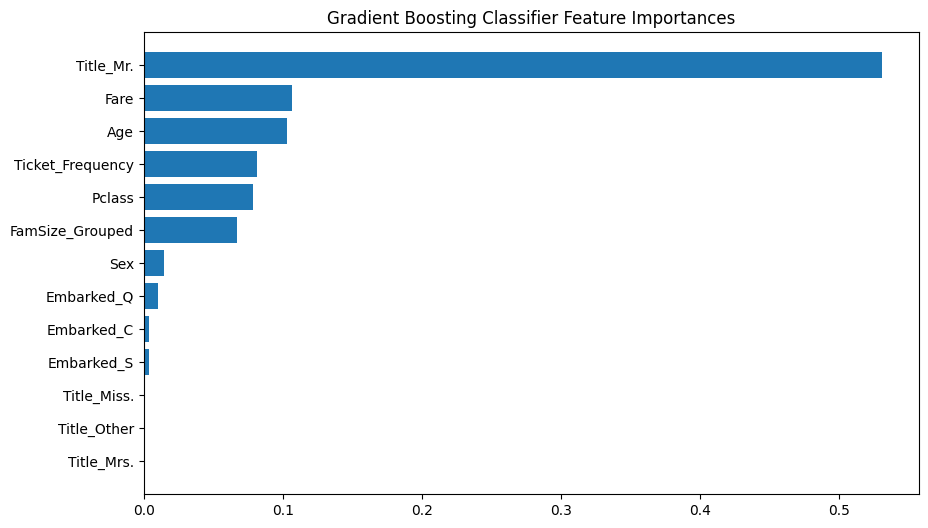

In [129]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = ensemble.GradientBoostingClassifier(**gb_trial.params)
    gb_pipe = imbpipeline(steps = [['standardscaler', StandardScaler()],
                                    ['model', model]])
    gb_pipe.fit(X_train, y_train)
    y_pred_gb = gb_pipe.predict(X_test)
    gb_accuracy = metrics.accuracy_score(y_test, y_pred_gb)

feature_importances = gb_pipe.steps[1][1].feature_importances_
features = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::]

plt.figure(figsize=(10, 6))
plt.title("Gradient Boosting Classifier Feature Importances")
plt.barh(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), [features[i] for i in indices])
plt.ylim([-1, X_train.shape[1]])
plt.show()

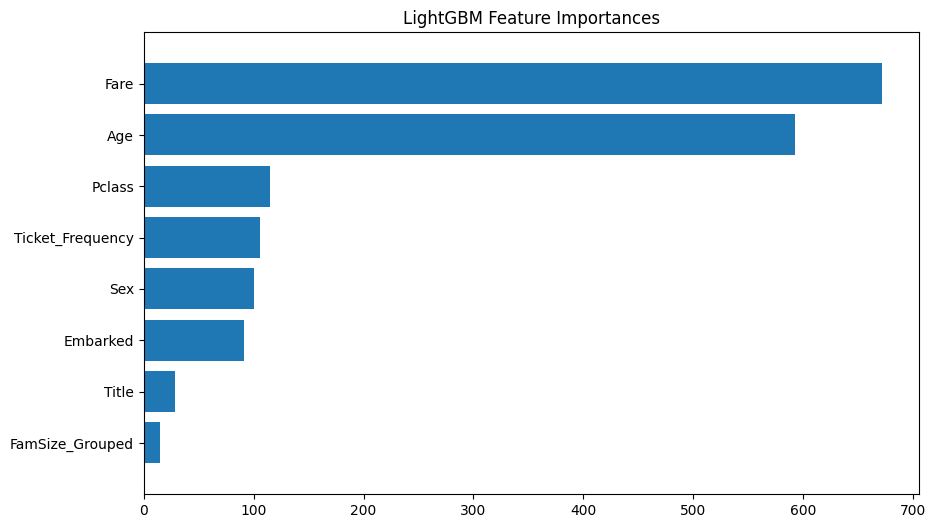

In [130]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lgb_model = lgb.LGBMClassifier(**lgb_trial.params, verbose=-1, enable_categorical=True)
    lgb_model.fit(X_train_agb_cat, y_train_agb,
                  callbacks= [lgb.early_stopping(stopping_rounds=30)],
                  eval_set = [[X_train_agb_cat,y_train_agb]],
                  eval_metric = 'binary_logloss')
    y_pred_lgb = lgb_model.predict(X_test_agb_cat)
    lgb_accuracy = metrics.accuracy_score(y_test, y_pred_lgb)

feature_importances = lgb_model.feature_importances_
features = X_train_agb_cat.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::]

plt.figure(figsize=(10, 6))
plt.title("LightGBM Feature Importances")
plt.barh(range(X_train_agb_cat.shape[1]), feature_importances[indices], align="center")
plt.yticks(range(X_train_agb_cat.shape[1]), [features[i] for i in indices])
plt.ylim([-1, X_train_agb_cat.shape[1]])
plt.show()

In [131]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = SVC(**svc_trial.params)
    svc_pipe = imbpipeline(steps = [['standardscaler', StandardScaler()],
                                        ['model', model]])
    svc_pipe.fit(X_train, y_train)
    y_pred_svc = svc_pipe.predict(X_test)
    svc_accuracy = metrics.accuracy_score(y_test_agb, y_pred_svc)

    features = X_train.columns
    if svc_trial.params['kernel']=='linear':
        feature_importances = pd.Series(abs(svc_pipe.steps[1][1].coef_[0]), index=features)

        indices = np.argsort(feature_importances)[::]

        plt.figure(figsize=(10, 6))
        plt.title("SVC Feature Importances")
        plt.barh(range(X_train.shape[1]), feature_importances[indices], align="center")
        plt.yticks(range(X_train.shape[1]), [features[i] for i in indices])
        plt.ylim([-1, X_train.shape[1]])
        plt.show()

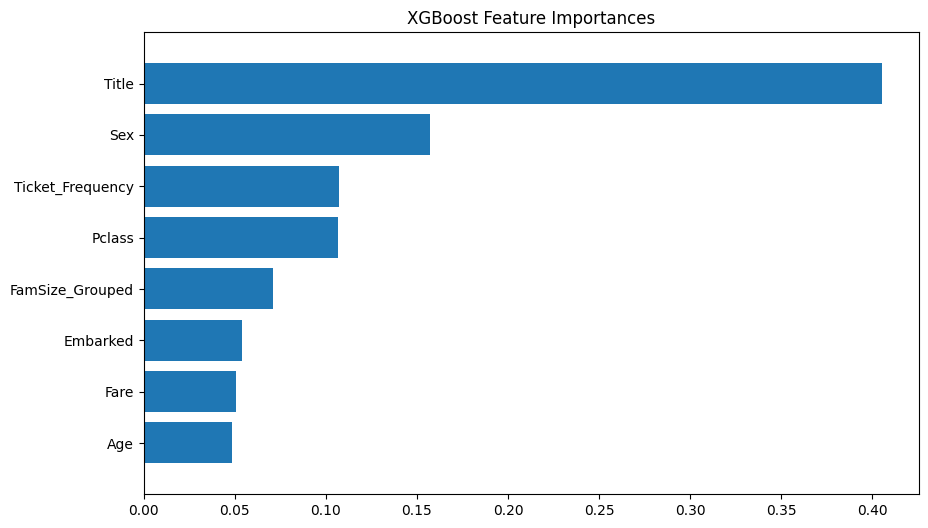

In [132]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    xgb_model = XGBClassifier(**xgb_trial.params, enable_categorical=True)
    
    xgb_model.fit(X_train_agb_cat, y_train_agb,
                  eval_set = [[X_train_agb_cat,y_train_agb]],
                  eval_metric = 'logloss',
                  verbose = False)
    y_pred_xgb = xgb_model.predict(X_test_agb_cat)
    xgb_accuracy = metrics.accuracy_score(y_test_agb, y_pred_xgb)

    feature_importances = xgb_model.feature_importances_
    features = X_train_agb_cat.columns

    # Sort feature importances in descending order
    indices = np.argsort(feature_importances)[::]

    plt.figure(figsize=(10, 6))
    plt.title("XGBoost Feature Importances")
    plt.barh(range(X_train_agb_cat.shape[1]), feature_importances[indices], align="center")
    plt.yticks(range(X_train_agb_cat.shape[1]), [features[i] for i in indices])
    plt.ylim([-1, X_train_agb_cat.shape[1]])
    plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

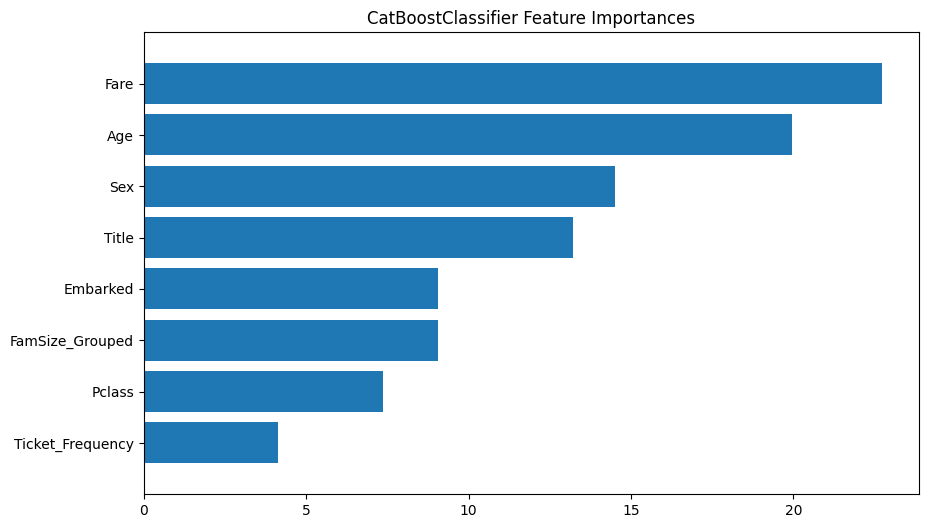

In [133]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cb_model = cb.CatBoostClassifier(**cb_trial.params,cat_features=cat_features)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cb_model.fit(X_train_agb, y_train_agb,
               early_stopping_rounds = 30,
               eval_set = (X_train_agb,y_train_agb),
               verbose = False)
    y_pred_cb = cb_model.predict(X_test_agb)
    

cb_accuracy = metrics.accuracy_score(y_test_agb, y_pred_cb)

feature_importances = cb_model.feature_importances_
features = X_train_agb.columns

indices = np.argsort(feature_importances)[::]

plt.figure(figsize=(10, 6))
plt.title("CatBoostClassifier Feature Importances")
plt.barh(range(X_train_agb.shape[1]), feature_importances[indices], align="center")
plt.yticks(range(X_train_agb.shape[1]), [features[i] for i in indices])
plt.ylim([-1, X_train_agb.shape[1]])
plt.show()

In [134]:
test_results = {
    "Gradient Boosting Classifier":gb_accuracy,
    "LightGBM":lgb_accuracy,
    "SVC":svc_accuracy,
    "XGBoost":xgb_accuracy,
    "CatBoostClassifier":cb_accuracy
}
df_results_tune['Test Accuracy'] = test_results

In [135]:
df_results_tune.sort_values(['Test Accuracy'], ascending=False)

,Cross Validation Score,Test Accuracy
XGBoost,0.812412,0.826816
CatBoostClassifier,0.818866,0.821229
Gradient Boosting Classifier,0.833393,0.815642
LightGBM,0.816290,0.815642
SVC,0.828348,0.815642


In [136]:
df_results_tune['Mean CV and Test Score'] = (df_results_tune['Cross Validation Score']+df_results_tune['Test Accuracy'])/2

In [137]:
df_results_tune.sort_values(['Mean CV and Test Score'], ascending=False)

,Cross Validation Score,Test Accuracy,Mean CV and Test Score
Gradient Boosting Classifier,0.833393,0.815642,0.824518
SVC,0.828348,0.815642,0.821995
CatBoostClassifier,0.818866,0.821229,0.820047
XGBoost,0.812412,0.826816,0.819614
LightGBM,0.816290,0.815642,0.815966


## Submission

In [138]:
df_test

,PassengerId,Pclass,Sex,Age,Fare,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,FamSize_Grouped,Ticket_Frequency,Embarked_C,Embarked_Q,Embarked_S
0,892,3,0,34.500000,7.8292,0,1,0,0,0,1,0,1,0
1,893,3,1,47.000000,7.0000,0,0,1,0,1,1,0,0,1
2,894,2,0,62.000000,9.6875,0,1,0,0,0,1,0,1,0
3,895,3,0,27.000000,8.6625,0,1,0,0,0,1,0,0,1
4,896,3,1,22.000000,12.2875,0,0,1,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,0,24.395931,8.0500,0,1,0,0,0,1,0,0,1
414,1306,1,1,39.000000,108.9000,0,0,0,1,0,1,1,0,0
415,1307,3,0,38.500000,7.2500,0,1,0,0,0,1,0,0,1
416,1308,3,0,24.395931,8.0500,0,1,0,0,0,1,0,0,1


In [139]:
exclude_columns = ['PassengerId', 'Survived']
features = [col for col in df_train.columns if col not in exclude_columns]
X = df_test[features]

In [140]:
features_agb = [col for col in df_train_agb.columns if col not in exclude_columns]
X_agb = df_test_agb[features_agb]
X_agb_cat = X_agb.copy()
for c in cat_features:
    X_agb_cat[c] = X_agb_cat[c].astype('category')

In [141]:
if df_results_tune[df_results_tune['Mean CV and Test Score']==max(df_results_tune['Mean CV and Test Score'])].index == 'XGBoost':
    test_pred = pd.Series(xgb_model.predict(X_agb_cat), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("xgb_best_titanic_submission.csv",index=False)
elif df_results_tune[df_results_tune['Mean CV and Test Score']==max(df_results_tune['Mean CV and Test Score'])].index == 'LightGBM':
    test_pred = pd.Series(lgb_model.predict(X_agb_cat), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("lgb_best_titanic_submission.csv",index=False)
elif df_results_tune[df_results_tune['Mean CV and Test Score']==max(df_results_tune['Mean CV and Test Score'])].index == 'CatBoostClassifier':
    test_pred = pd.Series(cb_model.predict(X_agb), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("cb_best_titanic_submission.csv",index=False)
elif df_results_tune[df_results_tune['Mean CV and Test Score']==max(df_results_tune['Mean CV and Test Score'])].index == 'SVC':
    test_pred = pd.Series(svc_pipe.predict(X), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("svc_best_titanic_submission.csv",index=False)
elif df_results_tune[df_results_tune['Mean CV and Test Score']==max(df_results_tune['Mean CV and Test Score'])].index == 'Gradient Boosting Classifier':
    test_pred = pd.Series(gb_pipe.predict(X), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("gb_best_titanic_submission.csv",index=False)
else:
    print('ERROR')

/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [142]:
if df_results_tune[df_results_tune['Mean CV and Test Score']==max(df_results_tune['Mean CV and Test Score'])].index == 'XGBoost':
    test_pred = pd.Series(lgb_model.predict(X_agb_cat), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("lgb_titanic_submission.csv",index=False)
    
    test_pred = pd.Series(cb_model.predict(X_agb), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("cb_titanic_submission.csv",index=False)
    
    test_pred = pd.Series(svc_pipe.predict(X), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("svc_titanic_submission.csv",index=False)
    
    test_pred = pd.Series(gb_pipe.predict(X), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("gb_titanic_submission.csv",index=False)
elif df_results_tune[df_results_tune['Mean CV and Test Score']==max(df_results_tune['Mean CV and Test Score'])].index == 'LightGBM':
    test_pred = pd.Series(xgb_model.predict(X_agb_cat), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("xgb_titanic_submission.csv",index=False)
    
    test_pred = pd.Series(cb_model.predict(X_agb), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("cb_titanic_submission.csv",index=False)
    
    test_pred = pd.Series(svc_pipe.predict(X), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("svc_titanic_submission.csv",index=False)
    
    test_pred = pd.Series(gb_pipe.predict(X), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("gb_titanic_submission.csv",index=False)
    
elif df_results_tune[df_results_tune['Mean CV and Test Score']==max(df_results_tune['Mean CV and Test Score'])].index == 'CatBoostClassifier':
    test_pred = pd.Series(xgb_model.predict(X_agb_cat), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("xgb_titanic_submission.csv",index=False)
    
    test_pred = pd.Series(lgb_model.predict(X_agb_cat), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("lgb_titanic_submission.csv",index=False)
    
    test_pred = pd.Series(svc_pipe.predict(X), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("svc_titanic_submission.csv",index=False)
    
    test_pred = pd.Series(gb_pipe.predict(X), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("gb_titanic_submission.csv",index=False)
elif df_results_tune[df_results_tune['Mean CV and Test Score']==max(df_results_tune['Mean CV and Test Score'])].index == 'SVC':
    test_pred = pd.Series(xgb_model.predict(X_agb_cat), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("xgb_titanic_submission.csv",index=False)
    
    test_pred = pd.Series(lgb_model.predict(X_agb_cat), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("lgb_titanic_submission.csv",index=False)
    
    test_pred = pd.Series(cb_model.predict(X_agb), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("cb_titanic_submission.csv",index=False)
    
    test_pred = pd.Series(gb_pipe.predict(X), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("gb_titanic_submission.csv",index=False)
elif df_results_tune[df_results_tune['Mean CV and Test Score']==max(df_results_tune['Mean CV and Test Score'])].index == 'Gradient Boosting Classifier':
    test_pred = pd.Series(xgb_model.predict(X_agb_cat), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("xgb_titanic_submission.csv",index=False)
    
    test_pred = pd.Series(lgb_model.predict(X_agb_cat), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("lgb_titanic_submission.csv",index=False)
    
    test_pred = pd.Series(cb_model.predict(X_agb), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("cb_titanic_submission.csv",index=False)
    
    test_pred = pd.Series(svc_pipe.predict(X), name="Survived")
    test_id = df_test['PassengerId']
    results = pd.concat([test_id,test_pred],axis=1)
    results.to_csv("svc_titanic_submission.csv",index=False)
else:
    print('ERROR')

/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
